In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format='retina'
import collections
import copy
from scipy import stats
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['mathtext.rm'] = 'serif'
rcParams['mathtext.it'] = 'serif:italic'
rcParams['mathtext.bf'] = 'serif:bold'
rcParams['axes.titlepad'] = 12

In [2]:
import processing_functions as pf

In [3]:
reload(pf)

<module 'processing_functions' from 'processing_functions.pyc'>

In [4]:
covtot_20p0 = pf.calc_covariance((np.load('Run_positive_Acen/jk_20p0_x.npz')['jkcov']+np.load('Run_positive_Acen/jk_20p0_y.npz')['jkcov']\
                             +np.load('Run_positive_Acen/jk_20p0_z.npz')['jkcov'])/3.,\
                             np.load('Run_positive_Acen/fidreal_20p0.npz')['func'],\
                             np.load('Run_positive_Acen/fidrandom_20p0.npz'))
cov_cut_20p0 = pf.cut_by_func_2D(covtot_20p0,funcidx={'w':range(1,30),'d':range(30,60),'v':range(60,90),\
                                           'c':range(90,120),'a':range(120,150),'r':range(150,180)})
invcov_cut_20p0 = pf.apply_to_dict(pf.inv_cov,cov_cut_20p0,rcond=1e-5)

In [5]:
pertfunc_dict_20p0,pertparam_20p0 = pf.load_pert('-20.0')
trim_mean_curves_20p0 = pf.trimmean_of_dict(pertfunc_dict_20p0)
func_cut_tm_20p0 = pf.cut_by_func_1D(trim_mean_curves_20p0,axis=1,funcidx={'w':range(1,30),'d':range(30,60),'v':range(60,90),\
                                           'c':range(90,120),'a':range(120,150),'r':range(150,180)})

In [6]:
gcv_alphas_tm_20p0 = pf.gcv_alphas(trim_mean_curves_20p0,pertparam_20p0)
gcv_alphas_cut_tm_20p0 = pf.cut_by_func_1D(gcv_alphas_tm_20p0,axis=1,funcidx={'w':range(1,30),'d':range(30,60),'v':range(60,90),\
                                           'c':range(90,120),'a':range(120,150),'r':range(150,180)})

In [7]:
def iterate_smooth(func_cut, gcv_alphas_cut, invcov_cut, pertparam, oneside, p0, combkey, amin, maxiter=5):  #for each combination separately
    it = 0
    iter_sigma = []
    iter_sigma.append(np.zeros(6))
    f = func_cut[combkey]
    alphas = np.ones((6,f.shape[1]))
    while it<maxiter:
        it += 1
        alphas = np.maximum(gcv_alphas_cut[combkey],alphas)
        alphas = np.maximum(alphas,(amin*np.ones((f.shape[1],6))).T)
        alphas = np.minimum(np.ones((6,f.shape[1])),alphas)
        dfdp = pf.locfit_comb(f,alphas,pertparam,p0)
        fisher = pf.calc_fisher(dfdp,invcov_cut[combkey])
        sigma = pf.calc_1sigma(fisher)
        iter_sigma.append(sigma)
        if np.all(iter_sigma[-2]<1.2*sigma) and np.all(iter_sigma[-2]>sigma/1.2):
            break
        if it<maxiter-1:
            alphas = (np.ones((f.shape[1],6))*pf.sigma_to_alpha(sigma,oneside)).T
    sigma_u = 1./np.sqrt(fisher.diagonal())
    return iter_sigma[-1], sigma_u, fisher, dfdp, alphas

In [8]:
klist = ['w','d','v','c','a','r',                                      # 0-5
         'wd','wv','wc','wa','wr',                                         # 6-10
         'dv','dc','da','dr',                                              # 11-14
         'vc','va','vr',                                                   # 15-17
         'ca','cr','ar',                                                   # 18-20
         #'wdv','wdc','wda','wdr','wvc','wva','wvr','wca','wcr','war',      # 21-30
         #'dvc','dva','dvr','dca','dcr','dar',                              # 31-36
         #'vca','vcr','var','car',                                          # 37-40
         #'wdvc','wdva','wdvr','wdca','wdcr','wdar',                        # 41-46
         #'wvca','wvcr','wvar','wcar',                                      # 47-50
         #'dvca','dvcr','dvar','dcar','vcar',                               # 51-55
         #'wdvca','wdvcr','wdvar','wdcar','wvcar','dvcar',                  # 56-61
         'wdvcar']                                                         # 62 -> 21

In [9]:
sigma_tm_20p0 = {}
sigma_u_tm_20p0 = {}
fisher_tm_20p0 = {}
dfdp_tm_20p0 = {}
alphas_tm_20p0 = {}
for k in klist:
    sigma_tm_20p0[k], sigma_u_tm_20p0[k], fisher_tm_20p0[k], dfdp_tm_20p0[k], alphas_tm_20p0[k] = \
    iterate_smooth(func_cut_tm_20p0,gcv_alphas_cut_tm_20p0,invcov_cut_20p0,pertparam_20p0,\
                   pf.oneside_ranges[2],pf.p20p0,k,np.array((0.35,0,0.55,0.5,0.75,0.6)))

In [10]:
param_list = [r'$\alpha$', r'$\log{M_\mathrm{1}}$', r'$\sigma_{\log{M}}$',  r'$\log{M_{\rm{min}}}$',\
              r'$A_{\rm{cen}}$', r'$A_{\rm{sat}}$']
r_wp = np.logspace(-1,1.5,30)
r_wp = (r_wp[1:]+r_wp[:-1])/2.

r_ds = np.logspace(-1,1.5,31)
r_ds = np.sqrt(0.5*(r_ds[1:]**2 + r_ds[:-1]**2))

r_vpf = np.logspace(0,1,30)

cic_bin = np.concatenate([np.arange(10),np.around(np.logspace(1,np.log10(150),30-10)).astype(np.int)])
cia_bin = np.concatenate([np.arange(10),np.around(np.logspace(1,np.log10(200),30-10)).astype(np.int)])

ratio_bin = np.linspace(0,1,31)

obs_list = [r'$n_{\mathrm{gal}}$',]+\
            list([r'$w_{\mathrm{p}}(r_{\mathrm{p}}= %.2f h^{-1}\mathrm{Mpc})$'%r for r in r_wp])+\
            list([r'$\Delta \Sigma(r_{\mathrm{p}}=%.2f h^{-1}\mathrm{Mpc})$'%r for r in r_ds])+\
            list([r'$\mathrm{VPF}(r=%.2f h^{-1}\mathrm{Mpc})$'%r for r in r_vpf])+\
            list([r'$P(N_{\mathrm{CIC}}=%d)$'%i for i in range(10)])+\
            list([r'$P(%d\leq N_{\mathrm{CIC}}<%d)$'%(cic_bin[i],cic_bin[i+1]) for i in range(10,29)])+\
            [r'$P(N_{\mathrm{CIC}} \geq %d)$'%cic_bin[-1],]+\
            list([r'$P(N_{\mathrm{CIA}}=%d)$'%i for i in range(10)])+\
            list([r'$P(%d\leq N_{\mathrm{CIA}}<%d)$'%(cia_bin[i],cia_bin[i+1]) for i in range(10,29)])+\
            [r'$P(N_{\mathrm{CIA}} \geq %d)$'%cia_bin[-1],]+\
            list([r'$P(%.3f<N_2/N_5<%.3f)$'%(ratio_bin[i],ratio_bin[i+1]) for i in range(30)])
Nparam = pf.Nparam

In [11]:
sigma_Acen_20p0 = []
sigma_Asat_20p0 = []

for k in klist:
    sigma_Acen_20p0.append(sigma_tm_20p0[k][-2])
    sigma_Asat_20p0.append(sigma_tm_20p0[k][-1])
sigma_Acen_20p0 = np.array(sigma_Acen_20p0)    
sigma_Asat_20p0 = np.array(sigma_Asat_20p0)    

rank_Acen_20p0 = np.argsort(-sigma_Acen_20p0)
rank_Asat_20p0 = np.argsort(-sigma_Asat_20p0)

In [12]:
sigma_Acen_20p0_2 = sigma_Acen_20p0[6:21]
rank_Acen_20p0_2 = np.argsort(-sigma_Acen_20p0_2)
sigma_Asat_20p0_2 = sigma_Asat_20p0[6:21]
rank_Asat_20p0_2 = np.argsort(-sigma_Asat_20p0_2)

In [13]:
comblist_1 = [r'$w_\mathrm{p}(r_\mathrm{p})$',r'$\Delta\Sigma(r_\mathrm{p})$',\
            r'$VPF(r)$',r'$P(N_{\rm{CIC}})$',\
            r'$P(N_{\rm{CIA}})$',r'$P(N_{\mathrm{2}}/N_{\mathrm{5}})$']

In [14]:
comblist_2 = [comblist_1[0]+'+'+comblist_1[1],comblist_1[0]+'+'+comblist_1[2],\
              comblist_1[0]+'+'+comblist_1[3],comblist_1[0]+'+'+comblist_1[4],\
              comblist_1[0]+'+'+comblist_1[5],comblist_1[1]+'+'+comblist_1[2],\
              comblist_1[1]+'+'+comblist_1[3],comblist_1[1]+'+'+comblist_1[4],\
              comblist_1[1]+'+'+comblist_1[5],comblist_1[2]+'+'+comblist_1[3],\
              comblist_1[2]+'+'+comblist_1[4],comblist_1[2]+'+'+comblist_1[5],\
              comblist_1[3]+'+'+comblist_1[4],comblist_1[3]+'+'+comblist_1[5],\
              comblist_1[4]+'+'+comblist_1[5]]

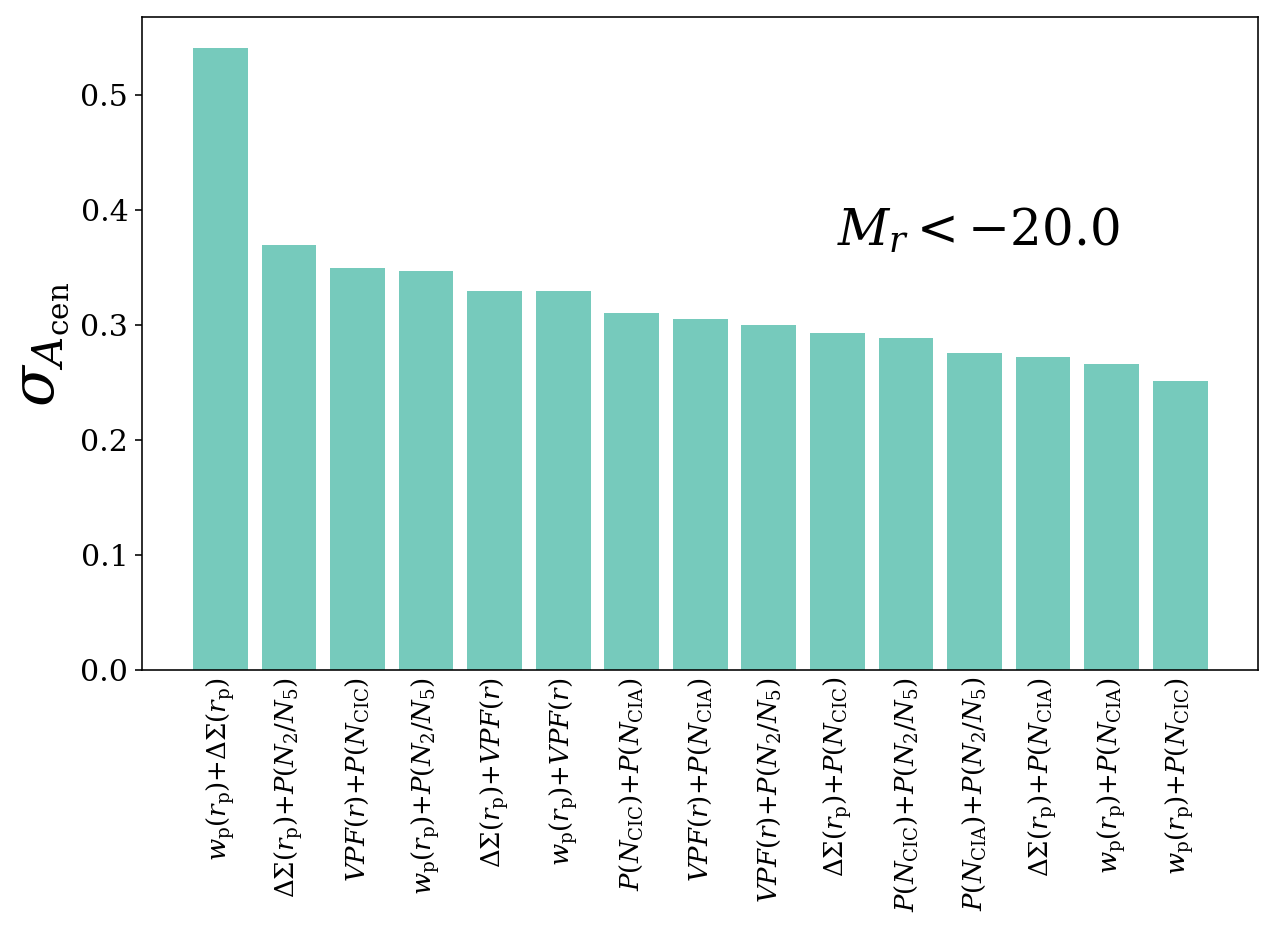

In [15]:
plt.figure(figsize=(10,6))
plt.tick_params(axis='x',length=0)
plt.bar(range(15),sigma_Acen_20p0_2[rank_Acen_20p0_2],color=cm.YlGnBu(100))
plt.xticks([],[])
plt.xticks(range(15),np.array(comblist_2)[rank_Acen_20p0_2],rotation=90,fontsize=13);
plt.yticks(fontsize=15)
plt.text(9,0.37,r'$M_r<-20.0$',fontsize=25)
plt.ylabel(r'$\sigma_{A_{\rm{cen}}}}$',fontsize=30)

In [16]:
print np.array(klist[6:21])[rank_Acen_20p0_2]
print np.array(klist[6:21])[rank_Asat_20p0_2]

['wd' 'dr' 'vc' 'wr' 'dv' 'wv' 'ca' 'va' 'vr' 'dc' 'cr' 'ar' 'da' 'wa' 'wc']
['va' 'vr' 'wv' 'wd' 'ar' 'dv' 'wa' 'da' 'dr' 'wr' 'vc' 'dc' 'cr' 'wc' 'ca']


In [17]:
['vc' 'wd' 'vr' 'dr' 'dv' 'ca' 'wv' 'ar' 'wr' 'va' 'cr' 'dc' 'da' 'wa' 'wc']
['va' 'wv' 'vr' 'wd' 'dv' 'wa' 'da' 'ar' 'dr' 'wr' 'vc' 'cr' 'dc' 'ca' 'wc']

['vawvvrwddvwadaardrwrvccrdccawc']

In [18]:
klist_bar = ['w','wd','wv','wc','wa','wr','wdvcar']

In [19]:
comblist = [r'$w_\mathrm{p}(r_\mathrm{p})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+\Delta\Sigma(r_\mathrm{p})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+VPF(r)$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{CIC}})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{CIA}})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\mathrm{2}}/N_{\mathrm{5}})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+\Delta\Sigma(r_\mathrm{p})+VPF(r)+$'+'\n'+r'$P(N_{\rm{CIC}})+P(N_{\rm{CIA}})+P(N_{\mathrm{2}}/N_{\mathrm{5}})$']

In [20]:
comblist_bar = [comblist_1[0],\
                comblist_1[0]+'+'+comblist_1[1],comblist_1[0]+'+'+comblist_1[2],\
                comblist_1[0]+'+'+comblist_1[3],comblist_1[0]+'+'+comblist_1[4],\
                comblist_1[0]+'+'+comblist_1[5],
                comblist_1[0]+'+'+comblist_1[1]+'+'+comblist_1[2]+'+'+'\n'+comblist_1[3]+'+'+comblist_1[4]+'+'+comblist_1[5]]

In [21]:
sigmalist_20p0 = []

for k in klist_bar:
    sigmalist_20p0.append(sigma_tm_20p0[k])
    
sigmalist_20p0 = np.array(sigmalist_20p0)

<Container object of 7 artists>

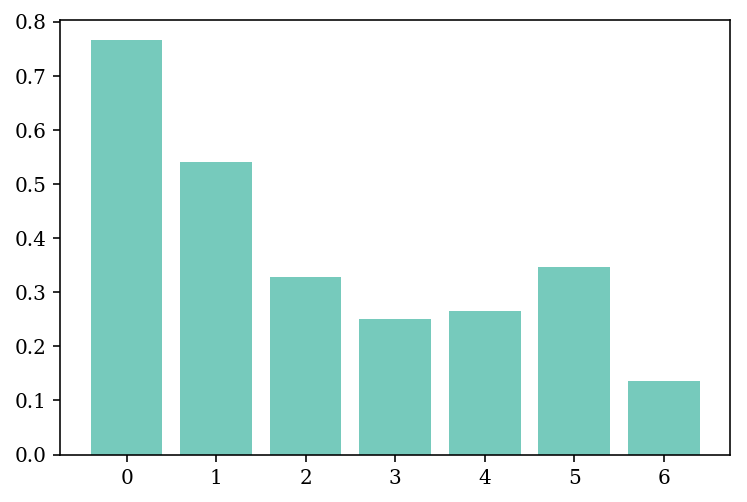

In [22]:
plt.bar(range(7),sigmalist_20p0[:,4], color=cm.YlGnBu(100))

In [11]:
def plot_curve_fit_diffsmooth(i,j,p0,pertparam,oneside,curve_tm,alphas_dict,dfdp_dict,flag=0,save=0,folder=None):
    if j<30:
        kset = ['w','wd','wdv','wc','wcar','wdvcar']
        idxset = [j,j,j,j,j,j]
    elif j>29 and j<60:
        kset = ['d','wd','wdv','wdvcar']
        idxset = [j-30,j,j,j]
    elif j>59 and j<90:
        kset = ['v','wdv','wdvcar']
        idxset = [j-60,j,j]
    elif j>89 and j<120:
        kset = ['c','wc','ca','car','wcar','wdvcar']
        idxset = [j-90,j-60,j-90,j-90,j-60,j]
    elif j>119 and j<150:
        kset = ['a','wa','ca','car','wcar','wdvcar']
        if flag==1:
            idxset = [j-120,j-90,j-92,j-92,j-62,j-2]
        elif flag==2:
            idxset = [j-120,j-90,j-96,j-96,j-66,j-6]
        else:
            idxset = [j-120,j-90,j-90,j-90,j-60,j]
    else:
        kset = ['r','wr','car','wcar','wdvcar']
        if flag==1:
            idxset = [j-150,j-120,j-94,j-64,j-4]
        elif flag==2:
            idxset = [j-150,j-120,j-102,j-72,j-12]
        else:
            idxset = [j-150,j-120,j-90,j-60,j]
    fig = plt.figure(figsize=(13,10))
    plt.xlabel(r'$\mathrm{d}$'+param_list[i],fontsize=30)
    plt.ylabel(r'$\mathrm{d}$'+obs_list[j],fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(pertparam[i]-p0[i],(curve_tm[Nparam*i:Nparam*i+Nparam,j]-curve_tm[Nparam*i+Nparam/2,j]),\
             'k-',lw=2.5)
    plt.axvline(0,c='k',ls='--')
    for l,k in enumerate(kset):
        plt.plot(pertparam[i]-p0[i],(pertparam[i]-p0[i])*dfdp_dict[k][i,idxset[l]],'--',c=cm.Paired(2*l+1),lw=2.5,label=k)
        plt.axvspan(-alphas_dict[k][i,idxset[l]]*oneside[i],alphas_dict[k][i,idxset[l]]*oneside[i],ymin=1./len(kset)*l,ymax=1./len(kset)*(l+1),color=cm.Paired(2*l+1),alpha=0.3)
    plt.legend(frameon=False,fontsize=15)
    if save:
        fig.savefig(folder+'p'+str(i)+'_f'+str(j)+'.png',bbox_inches = 'tight')
        plt.close(fig)

In [13]:
for i in range(6):
    for j in np.concatenate((range(120),range(120,150),range(150,180))):
        plot_curve_fit_diffsmooth(i,j,pf.p20p0,pertparam_20p0,pf.oneside_ranges[2],trim_mean_curves_20p0,alphas_tm_20p0,\
                          dfdp_tm_20p0,save=1,folder='Fit_alphas_20p0_pA/')

In [38]:
def plot_relative_df(i,j,save=0):
    fig = plt.figure(figsize=(13,10))
    plt.xlabel(r'$\mathrm{d}$'+param_list[i],fontsize=30)
    plt.ylabel(r'$\mathrm{d}$'+obs_list[j]+r'$/\sigma$',fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(pertparam_19p0[i]-pf.p19p0[i],(trim_mean_curves_19p0[Nparam*i:Nparam*i+Nparam,j]-trim_mean_curves_19p0[Nparam*i+Nparam/2,j])/np.sqrt(covtot_19p0[j,j]),\
             '-',c=cm.YlGnBu(250),lw=2.5,label=r'$-19.0$')
    #plt.plot(dp_19p0[i],dp_19p0[i]*dfdp_19p0[i,j],'--',c=cm.YlGnBu(250),lw=2.5)
    plt.axvline(0,c='k',ls='--')
    #plt.axvspan(-gcv_alpha_19p0[i,j]*oneside_ranges[0,i],gcv_alpha_19p0[i,j]*oneside_ranges[0,i],ymin=0,ymax=0.25,color=cm.YlGnBu(250),alpha=0.3)

    plt.plot(pertparam_19p5[i]-pf.p19p5[i],(trim_mean_curves_19p5[Nparam*i:Nparam*i+Nparam,j]-trim_mean_curves_19p5[Nparam*i+Nparam/2,j])/np.sqrt(covtot_19p5[j,j]),\
             '-',c=cm.YlGnBu(180),lw=2.5,label=r'$-19.5$')
    #plt.plot(dp_19p5[i],dp_19p5[i]*dfdp_19p5[i,j],'--',c=cm.YlGnBu(180),lw=2.5)
    plt.axvline(0,c='k',ls='--')
    #plt.axvspan(-gcv_alpha_19p5[i,j]*oneside_ranges[1,i],gcv_alpha_19p5[i,j]*oneside_ranges[1,i],ymin=0.25,ymax=0.5,color=cm.YlGnBu(180),alpha=0.3)

    plt.plot(pertparam_20p0[i]-pf.p20p0[i],(trim_mean_curves_20p0[Nparam*i:Nparam*i+Nparam,j]-trim_mean_curves_20p0[Nparam*i+Nparam/2,j])/np.sqrt(covtot_20p0[j,j]),\
             '-',c=cm.YlGnBu(120),lw=2.5,label=r'$-20.0$')
    #plt.plot(dp_20p0[i],dp_20p0[i]*dfdp_20p0[i,j],'--',c=cm.YlGnBu(120),lw=2.5)
    plt.axvline(0,c='k',ls='--')
    #plt.axvspan(-gcv_alpha_20p0[i,j]*oneside_ranges[2,i],gcv_alpha_20p0[i,j]*oneside_ranges[2,i],ymin=0.5,ymax=0.75,color=cm.YlGnBu(120),alpha=0.3)

    plt.plot(pertparam_20p5[i]-pf.p20p5[i],(trim_mean_curves_20p5[Nparam*i:Nparam*i+Nparam,j]-trim_mean_curves_20p5[Nparam*i+Nparam/2,j])/np.sqrt(covtot_20p5[j,j]),\
             '-',c=cm.YlGnBu(60),lw=2.5,label=r'$-20.5$')
    #plt.plot(dp_20p5[i],dp_20p5[i]*dfdp_20p5[i,j],'--',c=cm.YlGnBu(60),lw=2.5)
    plt.axvline(0,c='k',ls='--')
    #plt.axvspan(-gcv_alpha_20p5[i,j]*oneside_ranges[3,i],gcv_alpha_20p5[i,j]*oneside_ranges[3,i],ymin=0.75,ymax=1,color=cm.YlGnBu(60),alpha=0.3)

    plt.legend(frameon=False,fontsize=20)
    if save:
        fig.savefig('Diagnostic_plots_nA/p'+str(i)+'_f'+str(j)+'.png',bbox_inches = 'tight')
        plt.close(fig)

In [39]:
for i in range(6):
    for j in range(180):
        plot_relative_df(i,j,save=1)

/home/kuw8/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in divide
/home/kuw8/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in divide
/home/kuw8/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in divide
/home/kuw8/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in divide


In [14]:
comblist = [r'$w_\mathrm{p}(r_\mathrm{p})$',r'$\Delta\Sigma(r_\mathrm{p})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+\Delta\Sigma(r_\mathrm{p})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+\Delta\Sigma(r_\mathrm{p})+VPF(r)$',\
            r'$\rm{CIC}+\rm{CIA}$',\
            r'$\rm{CIC}+\rm{CIA}+P(N_{\mathrm{1}}/N_{\mathrm{2}})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+\rm{CIC}$',r'$w_\mathrm{p}(r_\mathrm{p})+\rm{CIA}$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\mathrm{1}}/N_{\mathrm{2}})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+\rm{CIC}+\rm{CIA}+P(N_{\mathrm{1}}/N_{\mathrm{2}})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+\Delta\Sigma(r_\mathrm{p})+VPF(r)+$'+'\n'+r'$\rm{CIC}+\rm{CIA}+P(N_{\mathrm{1}}/N_{\mathrm{2}})$']

In [15]:
combidx = [0,1,6,7,11,12,8,9,10,17,18]
np.array(klist)[combidx]

array(['w', 'd', 'wd', 'wdv', 'ca', 'car', 'wc', 'wa', 'wr', 'wcar',
       'wdvcar'],
      dtype='|S6')

In [16]:
sigmalist_20p0 = []

for k in klist:
    sigmalist_20p0.append(sigma_tm_20p0[k])
    
sigmalist_20p0 = np.array(sigmalist_20p0)

In [18]:
for k in klist:
    print k,sigma_tm_20p0[k]

w [ 0.02962039  0.0283651   0.36299578  0.13307374  0.56953873  0.36399318]
d [ 0.07527913  0.08947344  0.4457054   0.22556198  0.84129076  0.36551088]
v [ 0.76162664  0.19423411  0.16221822  0.09296664  0.48817641  3.12451913]
c [ 0.05099473  0.06809961  0.25761531  0.05611119  0.66521314  0.1029191 ]
a [ 0.0723233   0.07370513  0.24413985  0.07854015  0.61324345  0.3811838 ]
r [ 0.03926583  0.03253556  0.11735722  0.04144996  0.49403171  0.30571427]
wd [ 0.02063381  0.01929319  0.10564188  0.03938462  0.43771633  0.24212987]
wdv [ 0.01806547  0.01301489  0.05323774  0.02319536  0.25549096  0.1618666 ]
wc [ 0.01454318  0.01300859  0.05747337  0.02317856  0.23030239  0.08432304]
wa [ 0.01664843  0.01640764  0.0848009   0.03042297  0.25090239  0.20999635]
wr [ 0.01606916  0.0145864   0.06386043  0.02569143  0.28111047  0.15348714]
ca [ 0.02387546  0.02513562  0.08841342  0.03338578  0.33981233  0.08805854]
car [ 0.01972992  0.01882943  0.06957618  0.02505569  0.21809088  0.08053316]
wdc

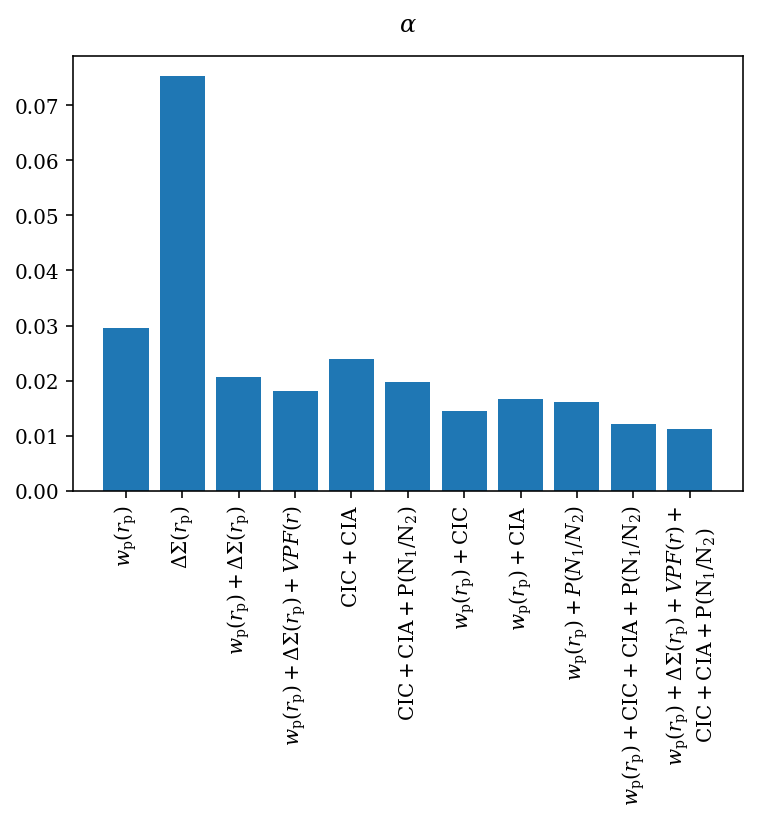

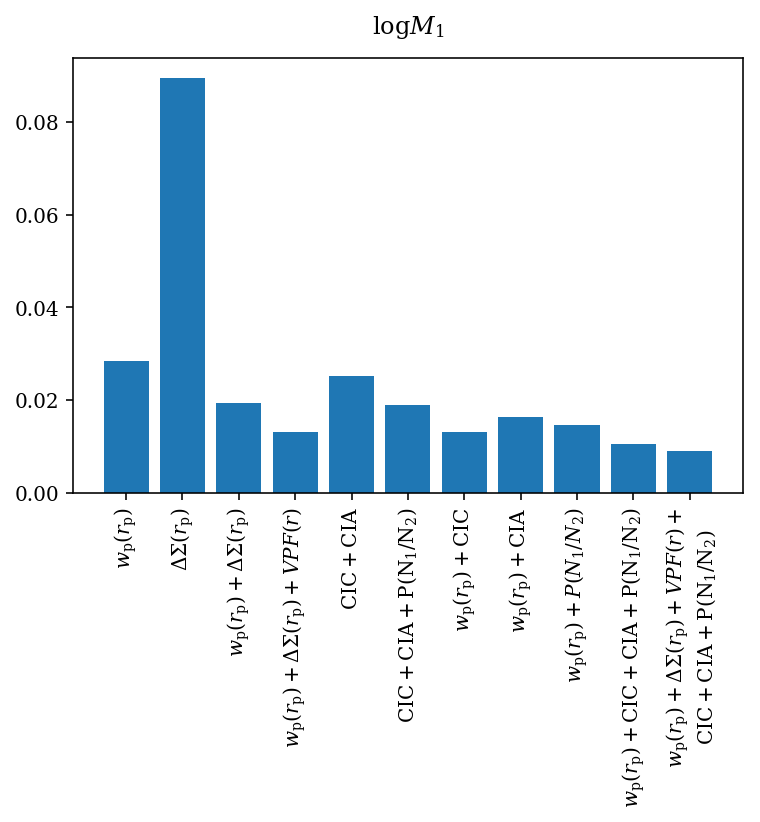

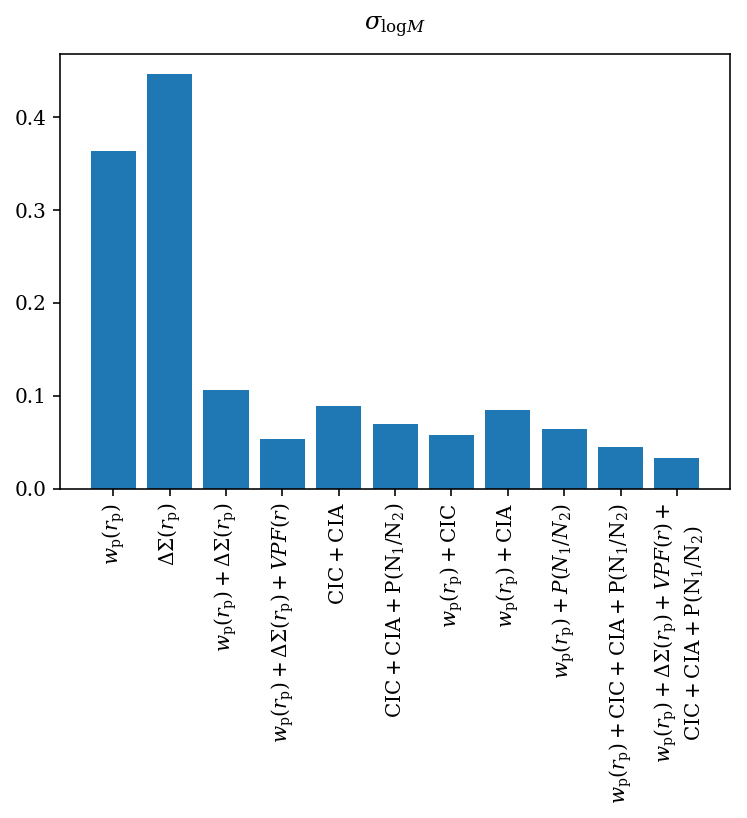

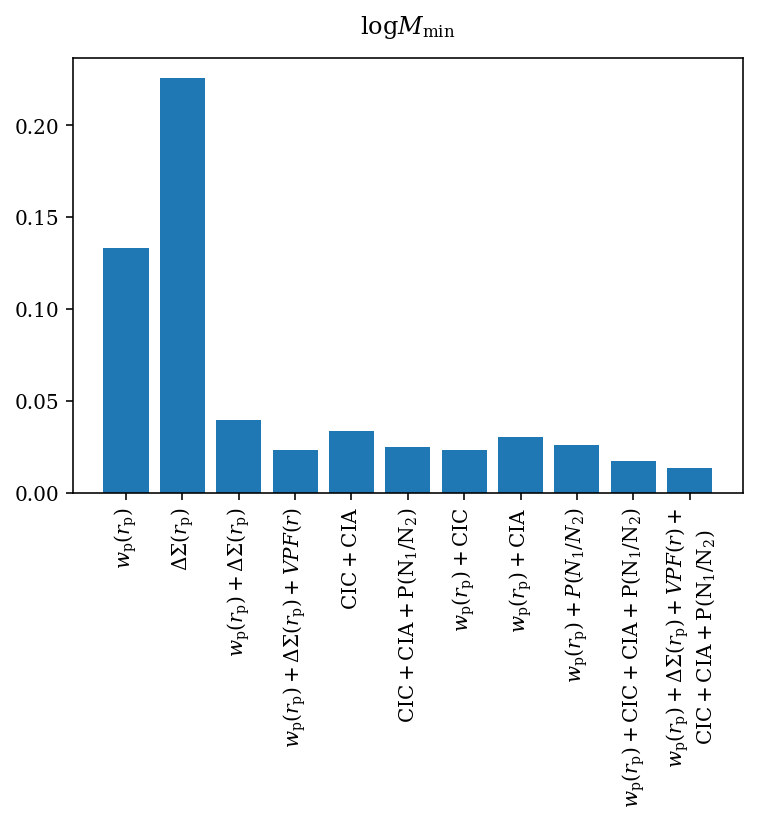

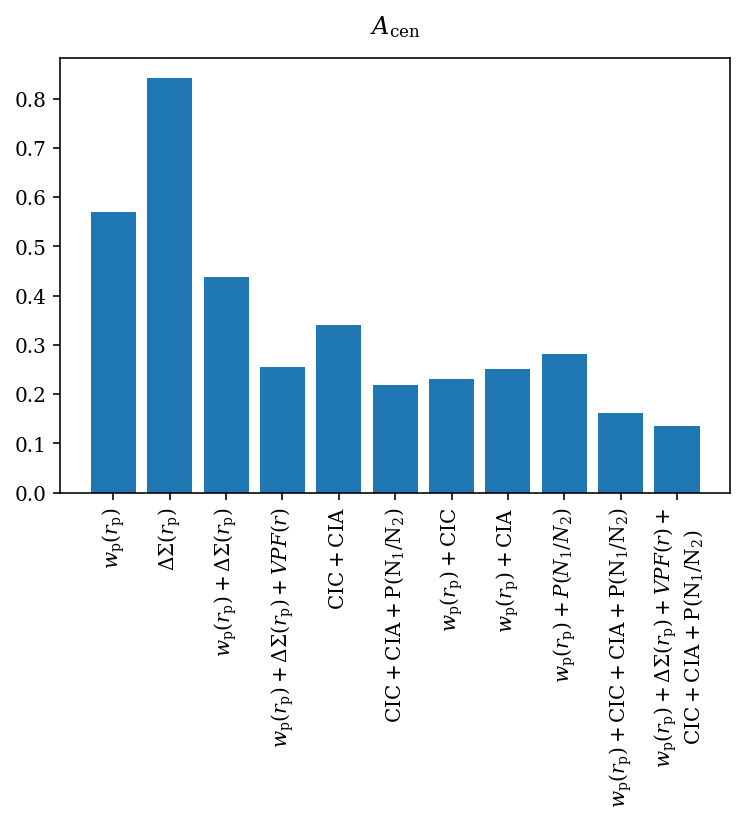

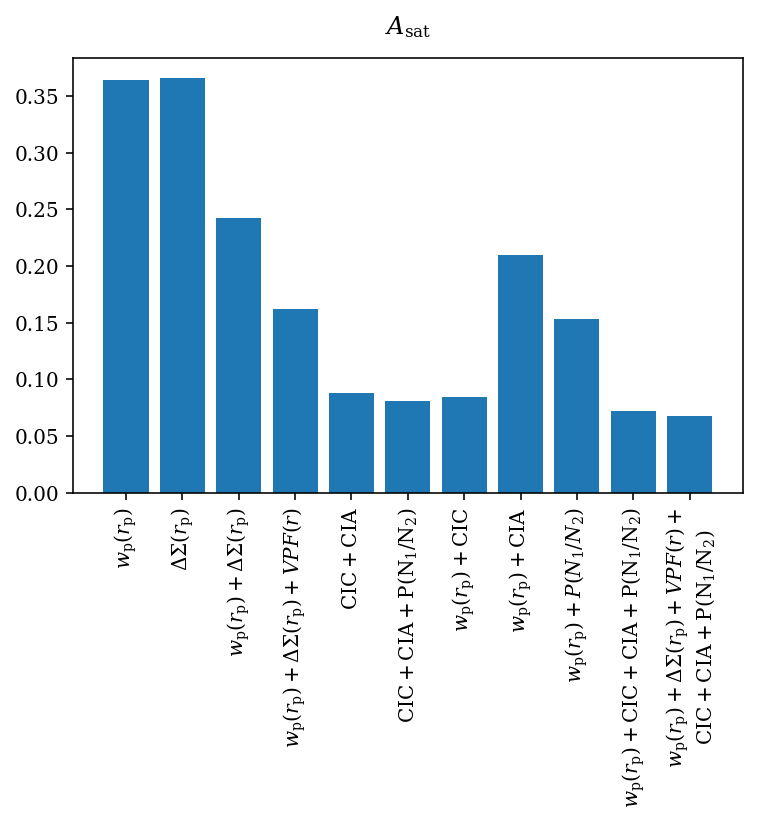

In [24]:
for i in range(6):
    plt.figure()
    plt.title(param_list[i])
    plt.bar(range(11),sigmalist_20p0[combidx,i])
    plt.xticks(range(11),comblist,rotation=90)

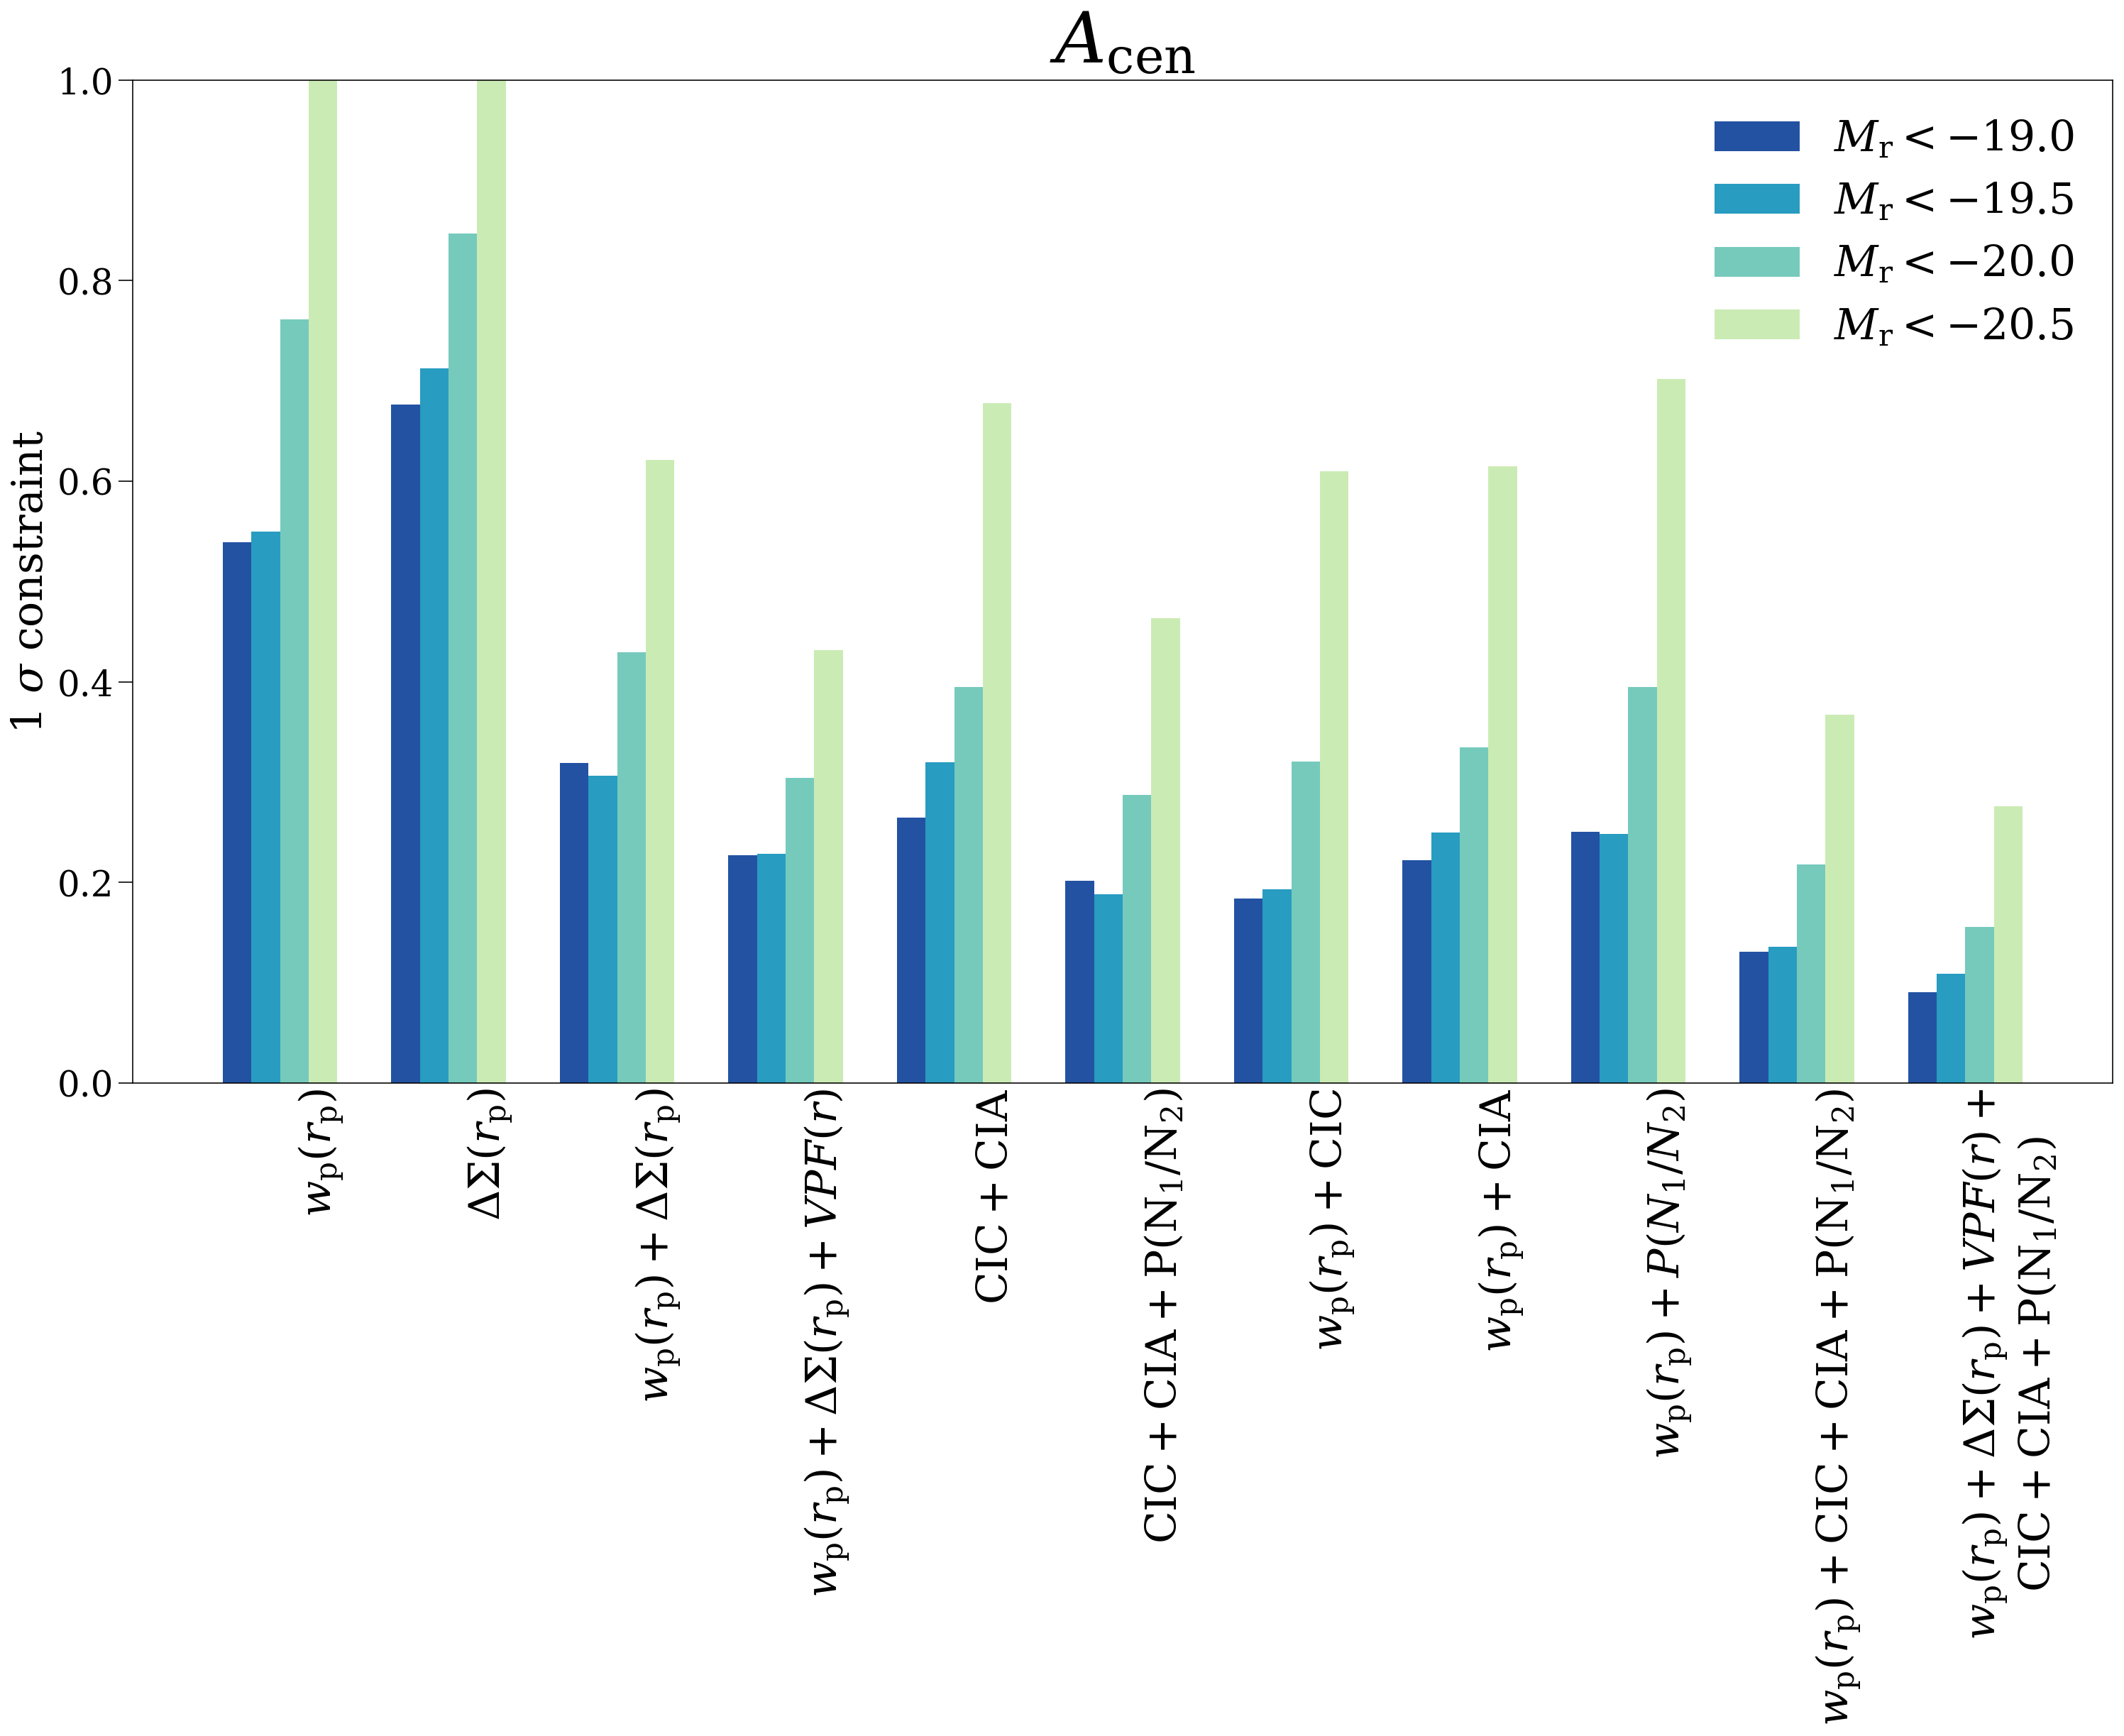

In [18]:
N = 11

ind = np.arange(N)  # the x locations for the groups
width = 0.17       # the width of the bars

fig, ax = plt.subplots(figsize=(25,13))
rects1 = ax.bar(ind, sigmalist_19p0[combidx,4], width, color=cm.YlGnBu(200))
rects2 = ax.bar(ind+width, sigmalist_19p5[combidx,4], width, color=cm.YlGnBu(150))
rects3 = ax.bar(ind+width*2, sigmalist_20p0[combidx,4], width, color=cm.YlGnBu(100))
rects4 = ax.bar(ind+width*3, sigmalist_20p5[combidx,4], width, color=cm.YlGnBu(60))

# add some text for labels, title and axes ticks
ax.set_ylabel(r'$1\ \sigma\ \rm{constraint}$',fontsize=30)
ax.set_title(param_list[4],fontsize=50)
ax.set_xticks(np.arange(N)+0.5)
ax.set_xticklabels(comblist,rotation=90,fontsize=30)
ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=25)
ax.tick_params(axis='x',length=0)
ax.tick_params(axis='y',length=10)


ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),\
          (r'$M_{\rm{r}}<-19.0$',r'$M_{\rm{r}}<-19.5$',r'$M_{\rm{r}}<-20.0$',r'$M_{\rm{r}}<-20.5$'),frameon=False,fontsize=30)

ax.set_ylim(0,1.0)

plt.show()

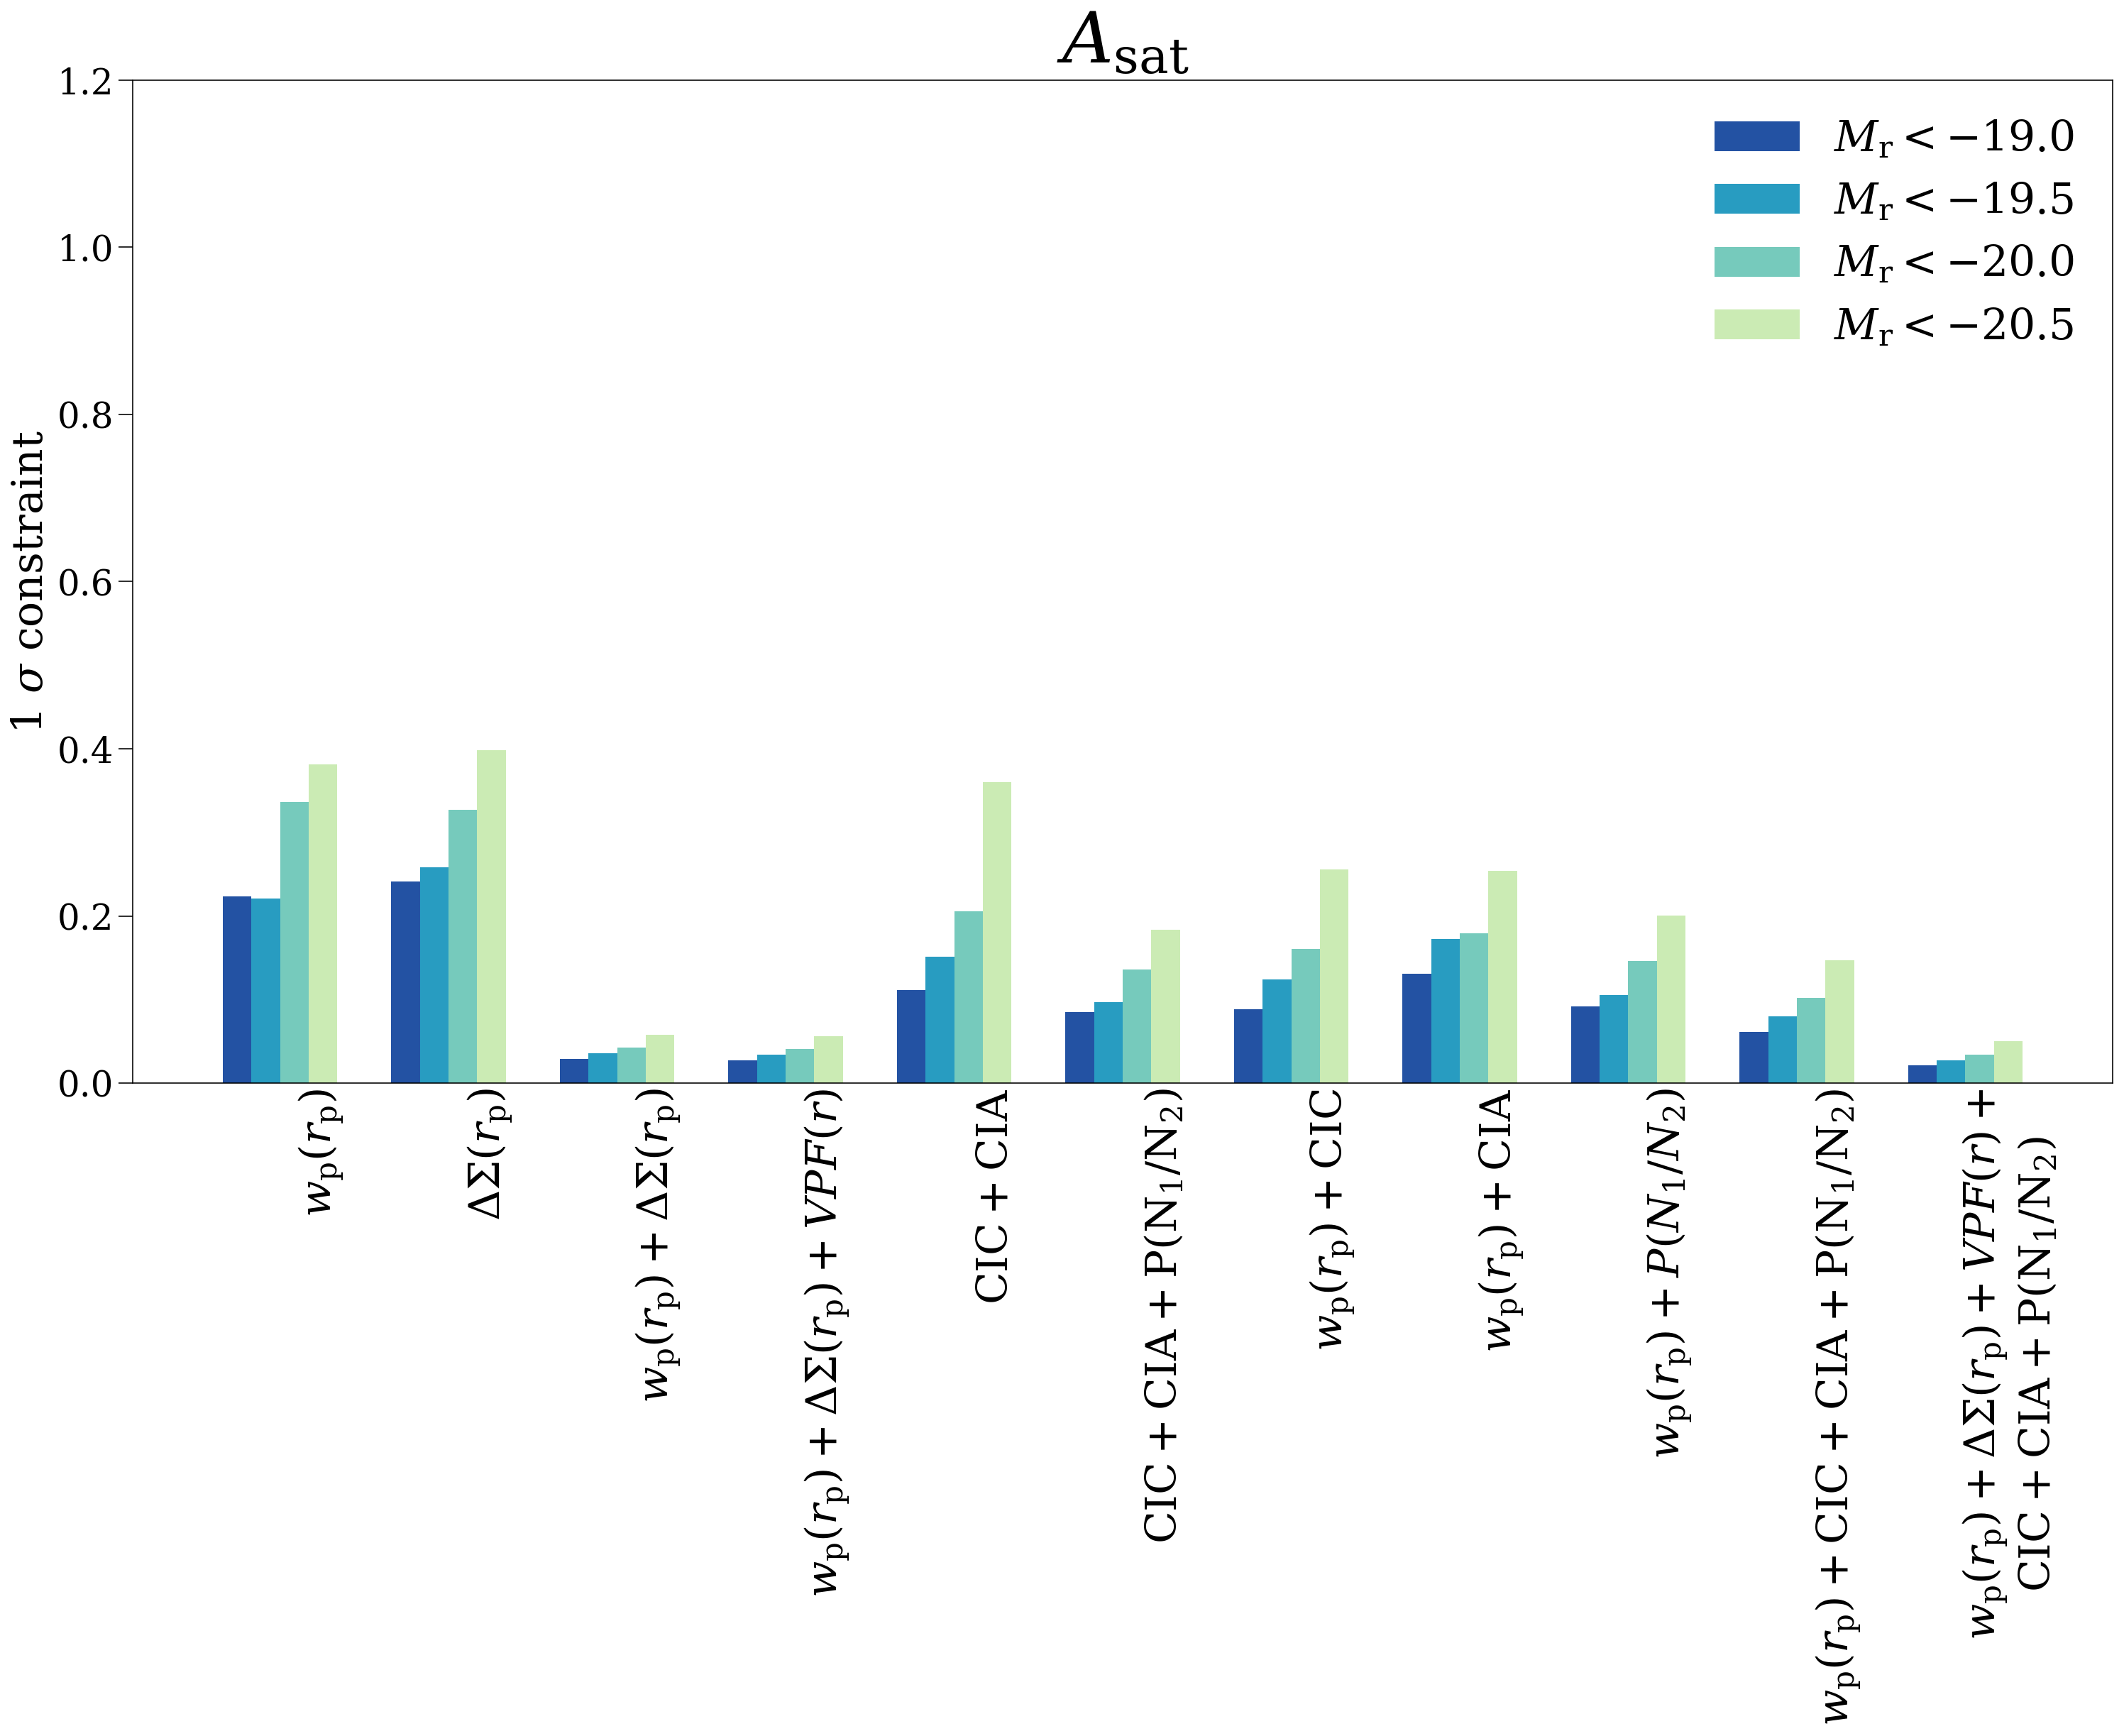

In [19]:
N = 11

ind = np.arange(N)  # the x locations for the groups
width = 0.17       # the width of the bars

fig, ax = plt.subplots(figsize=(25,13))
rects1 = ax.bar(ind, sigmalist_19p0[combidx,5], width, color=cm.YlGnBu(200))
rects2 = ax.bar(ind+width, sigmalist_19p5[combidx,5], width, color=cm.YlGnBu(150))
rects3 = ax.bar(ind+width*2, sigmalist_20p0[combidx,5], width, color=cm.YlGnBu(100))
rects4 = ax.bar(ind+width*3, sigmalist_20p5[combidx,5], width, color=cm.YlGnBu(60))

# add some text for labels, title and axes ticks
ax.set_ylabel(r'$1\ \sigma\ \rm{constraint}$',fontsize=30)
ax.set_title(param_list[5],fontsize=50)
ax.set_xticks(np.arange(N)+0.5)
ax.set_xticklabels(comblist,rotation=90,fontsize=30)
ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0,1.2],fontsize=25)
ax.tick_params(axis='x',length=0)
ax.tick_params(axis='y',length=10)


ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),\
          (r'$M_{\rm{r}}<-19.0$',r'$M_{\rm{r}}<-19.5$',r'$M_{\rm{r}}<-20.0$',r'$M_{\rm{r}}<-20.5$'),frameon=False,fontsize=30)

ax.set_ylim(0,1.2)

plt.show()

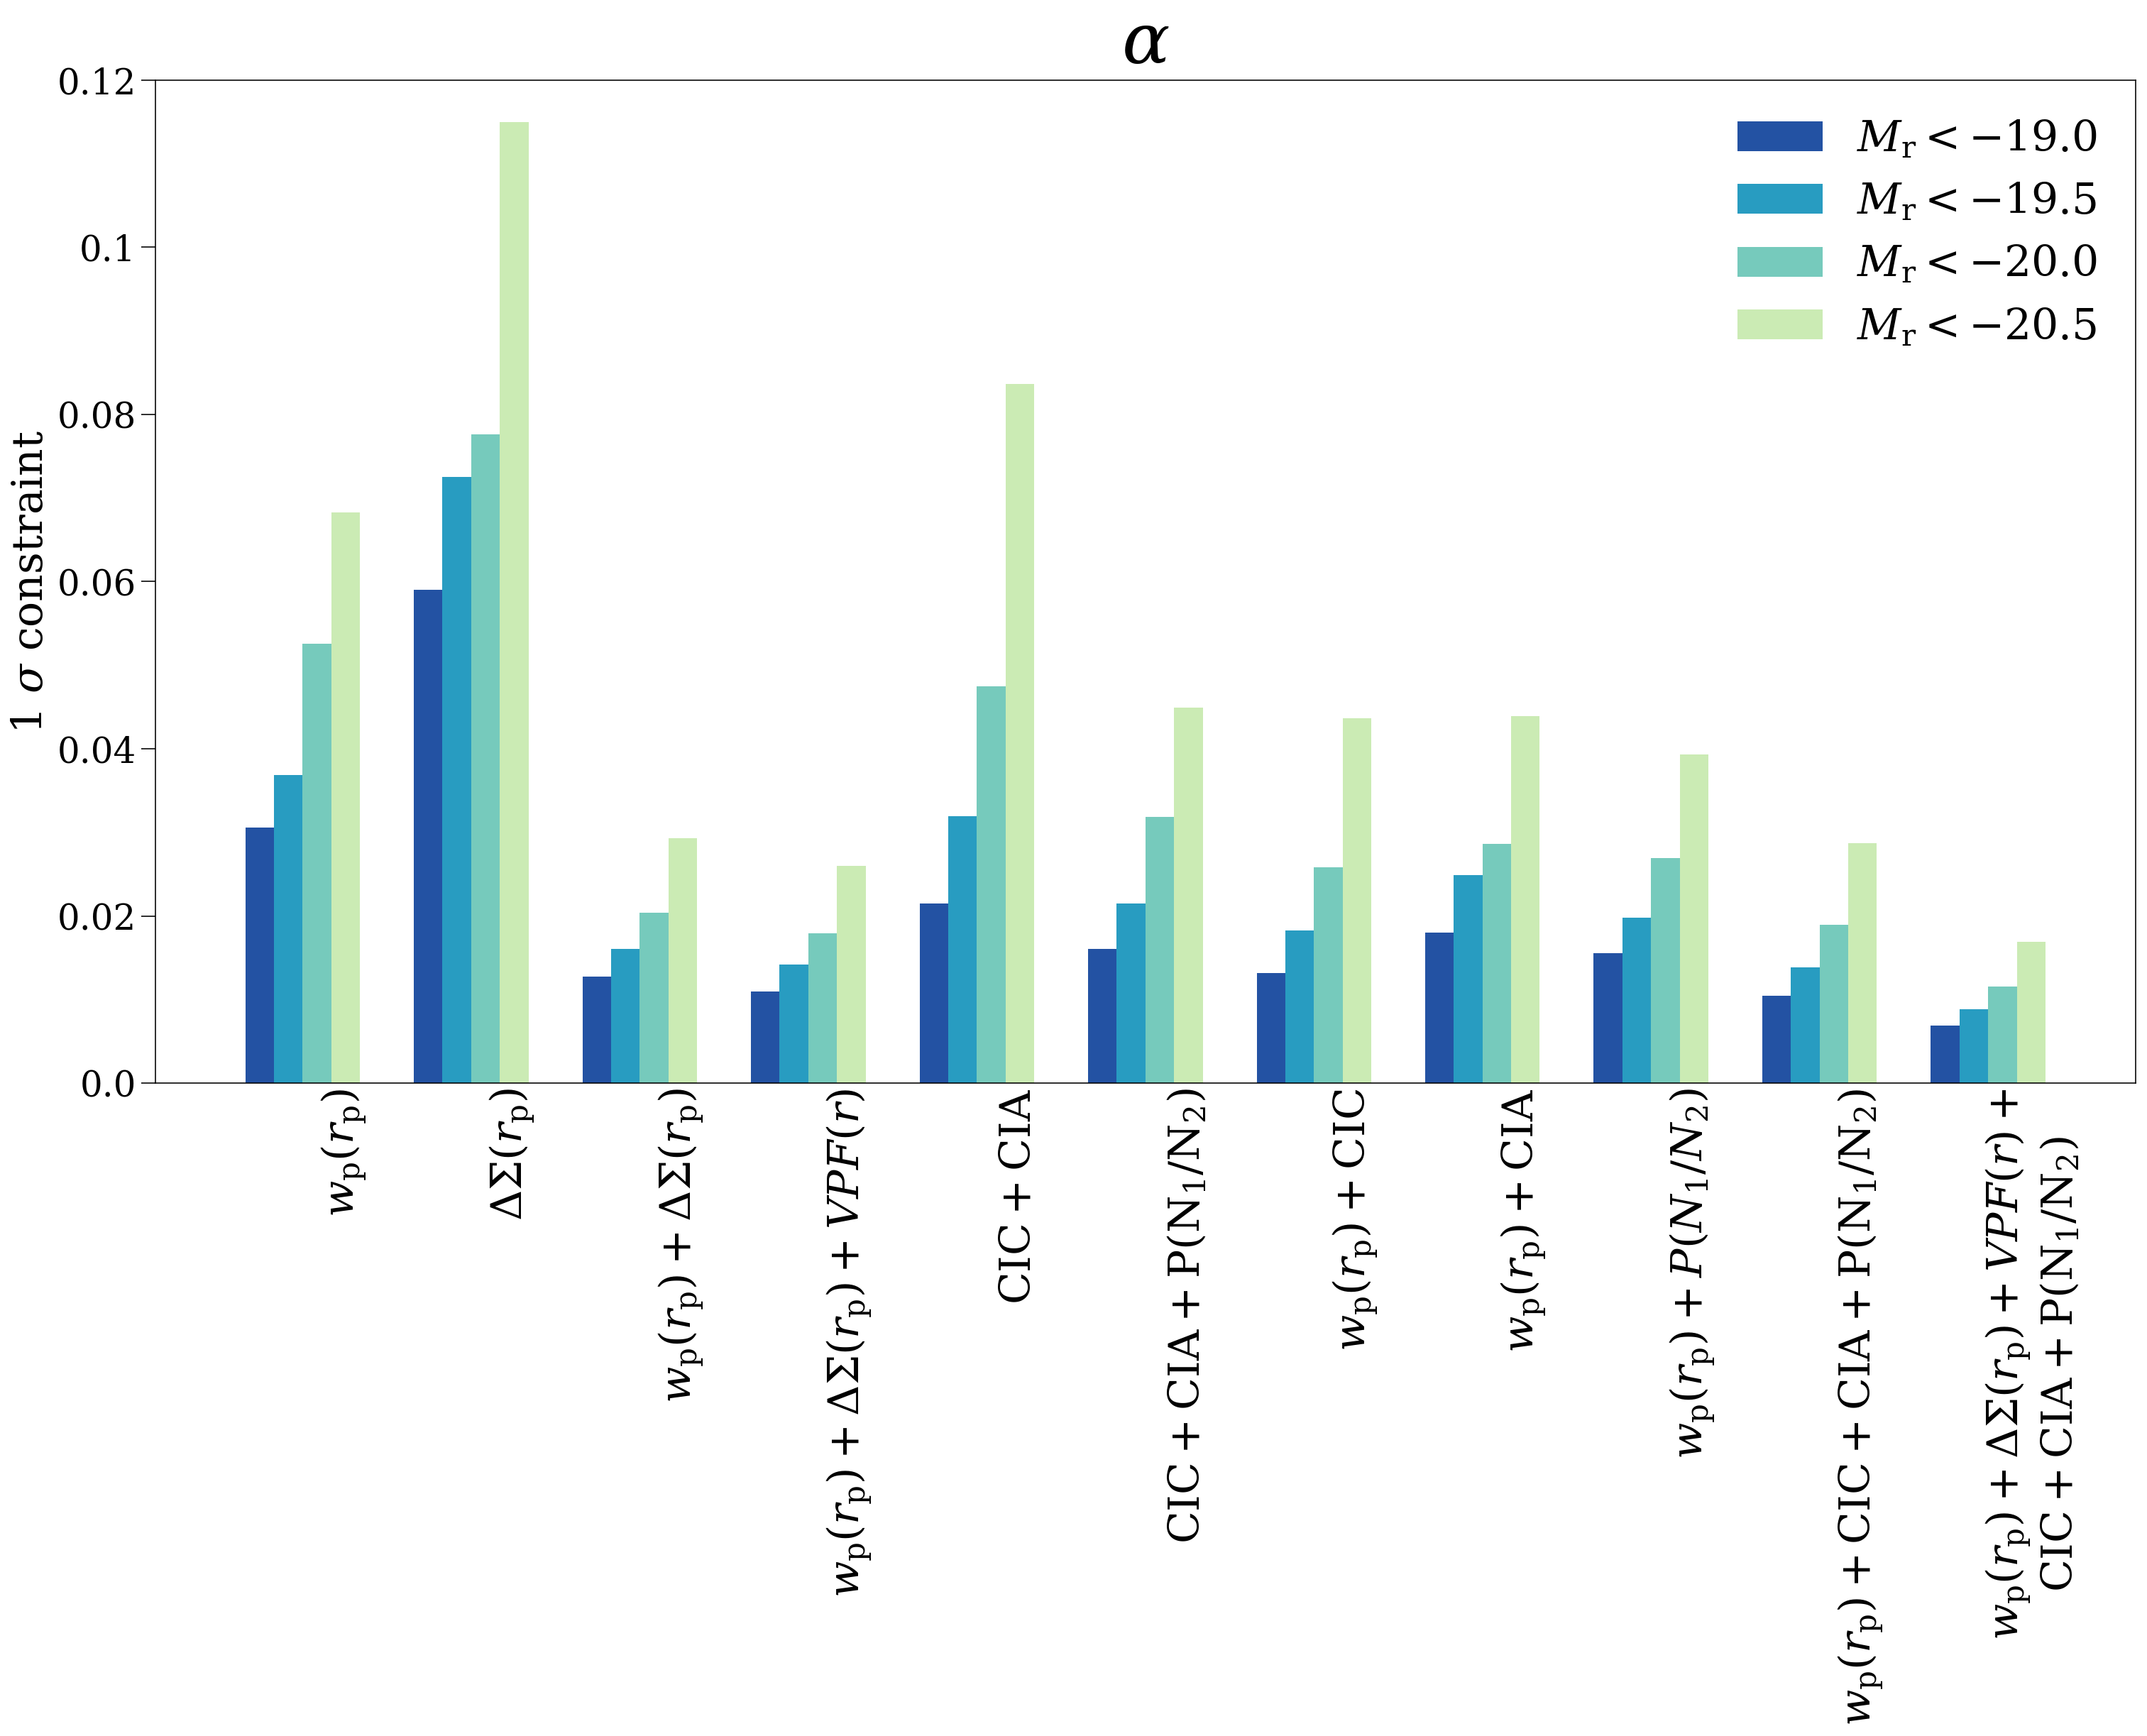

In [20]:
N = 11

ind = np.arange(N)  # the x locations for the groups
width = 0.17       # the width of the bars

fig, ax = plt.subplots(figsize=(25,13))
rects1 = ax.bar(ind, sigmalist_19p0[combidx,0], width, color=cm.YlGnBu(200))
rects2 = ax.bar(ind+width, sigmalist_19p5[combidx,0], width, color=cm.YlGnBu(150))
rects3 = ax.bar(ind+width*2, sigmalist_20p0[combidx,0], width, color=cm.YlGnBu(100))
rects4 = ax.bar(ind+width*3, sigmalist_20p5[combidx,0], width, color=cm.YlGnBu(60))

# add some text for labels, title and axes ticks
ax.set_ylabel(r'$1\ \sigma\ \rm{constraint}$',fontsize=30)
ax.set_title(param_list[0],fontsize=50)
ax.set_xticks(np.arange(N)+0.5)
ax.set_xticklabels(comblist,rotation=90,fontsize=30)
ax.set_yticklabels([0.0,0.02,0.04,0.06,0.08,0.10,0.12],fontsize=25)
ax.tick_params(axis='x',length=0)
ax.tick_params(axis='y',length=10)


ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),\
          (r'$M_{\rm{r}}<-19.0$',r'$M_{\rm{r}}<-19.5$',r'$M_{\rm{r}}<-20.0$',r'$M_{\rm{r}}<-20.5$'),frameon=False,fontsize=30)

ax.set_ylim(0,0.12)

plt.show()

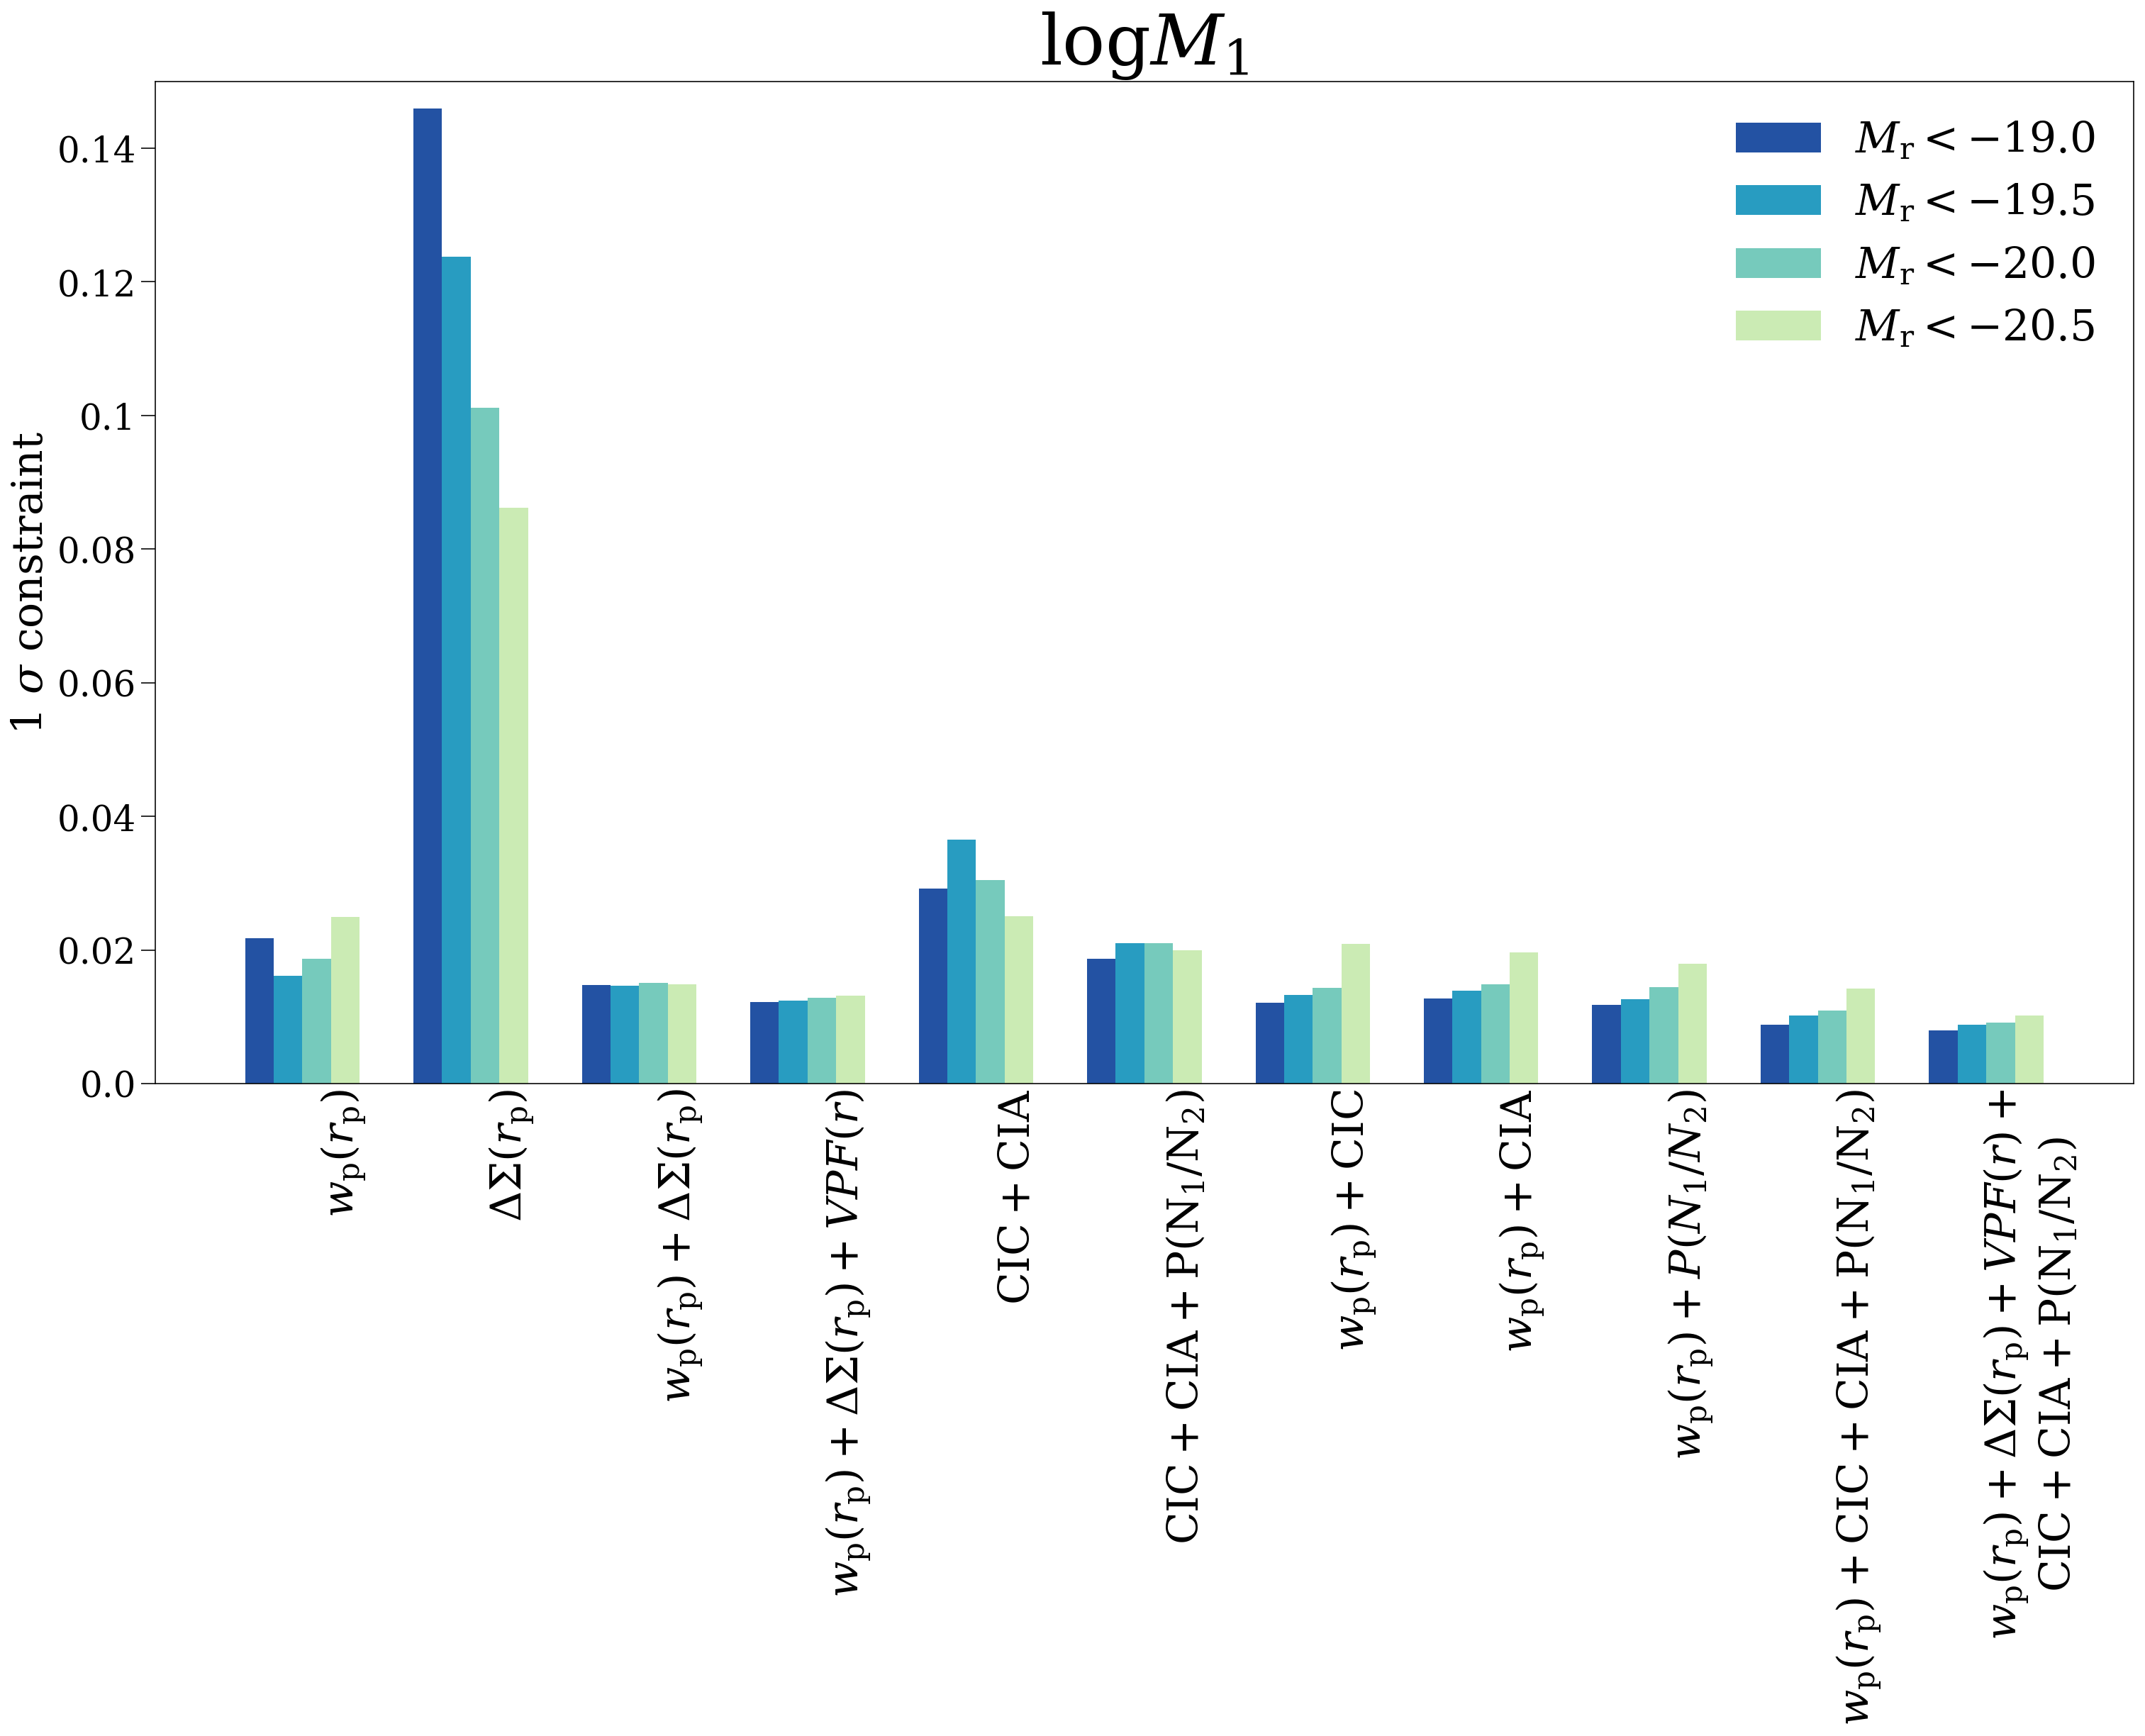

In [21]:
N = 11

ind = np.arange(N)  # the x locations for the groups
width = 0.17       # the width of the bars

fig, ax = plt.subplots(figsize=(25,13))
rects1 = ax.bar(ind, sigmalist_19p0[combidx,1], width, color=cm.YlGnBu(200))
rects2 = ax.bar(ind+width, sigmalist_19p5[combidx,1], width, color=cm.YlGnBu(150))
rects3 = ax.bar(ind+width*2, sigmalist_20p0[combidx,1], width, color=cm.YlGnBu(100))
rects4 = ax.bar(ind+width*3, sigmalist_20p5[combidx,1], width, color=cm.YlGnBu(60))

# add some text for labels, title and axes ticks
ax.set_ylabel(r'$1\ \sigma\ \rm{constraint}$',fontsize=30)
ax.set_title(param_list[1],fontsize=50)
ax.set_xticks(np.arange(N)+0.5)
ax.set_xticklabels(comblist,rotation=90,fontsize=30)
ax.set_yticklabels([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14],fontsize=25)
ax.tick_params(axis='x',length=0)
ax.tick_params(axis='y',length=10)


ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),\
          (r'$M_{\rm{r}}<-19.0$',r'$M_{\rm{r}}<-19.5$',r'$M_{\rm{r}}<-20.0$',r'$M_{\rm{r}}<-20.5$'),frameon=False,fontsize=30)

ax.set_ylim(0,0.15)

plt.show()

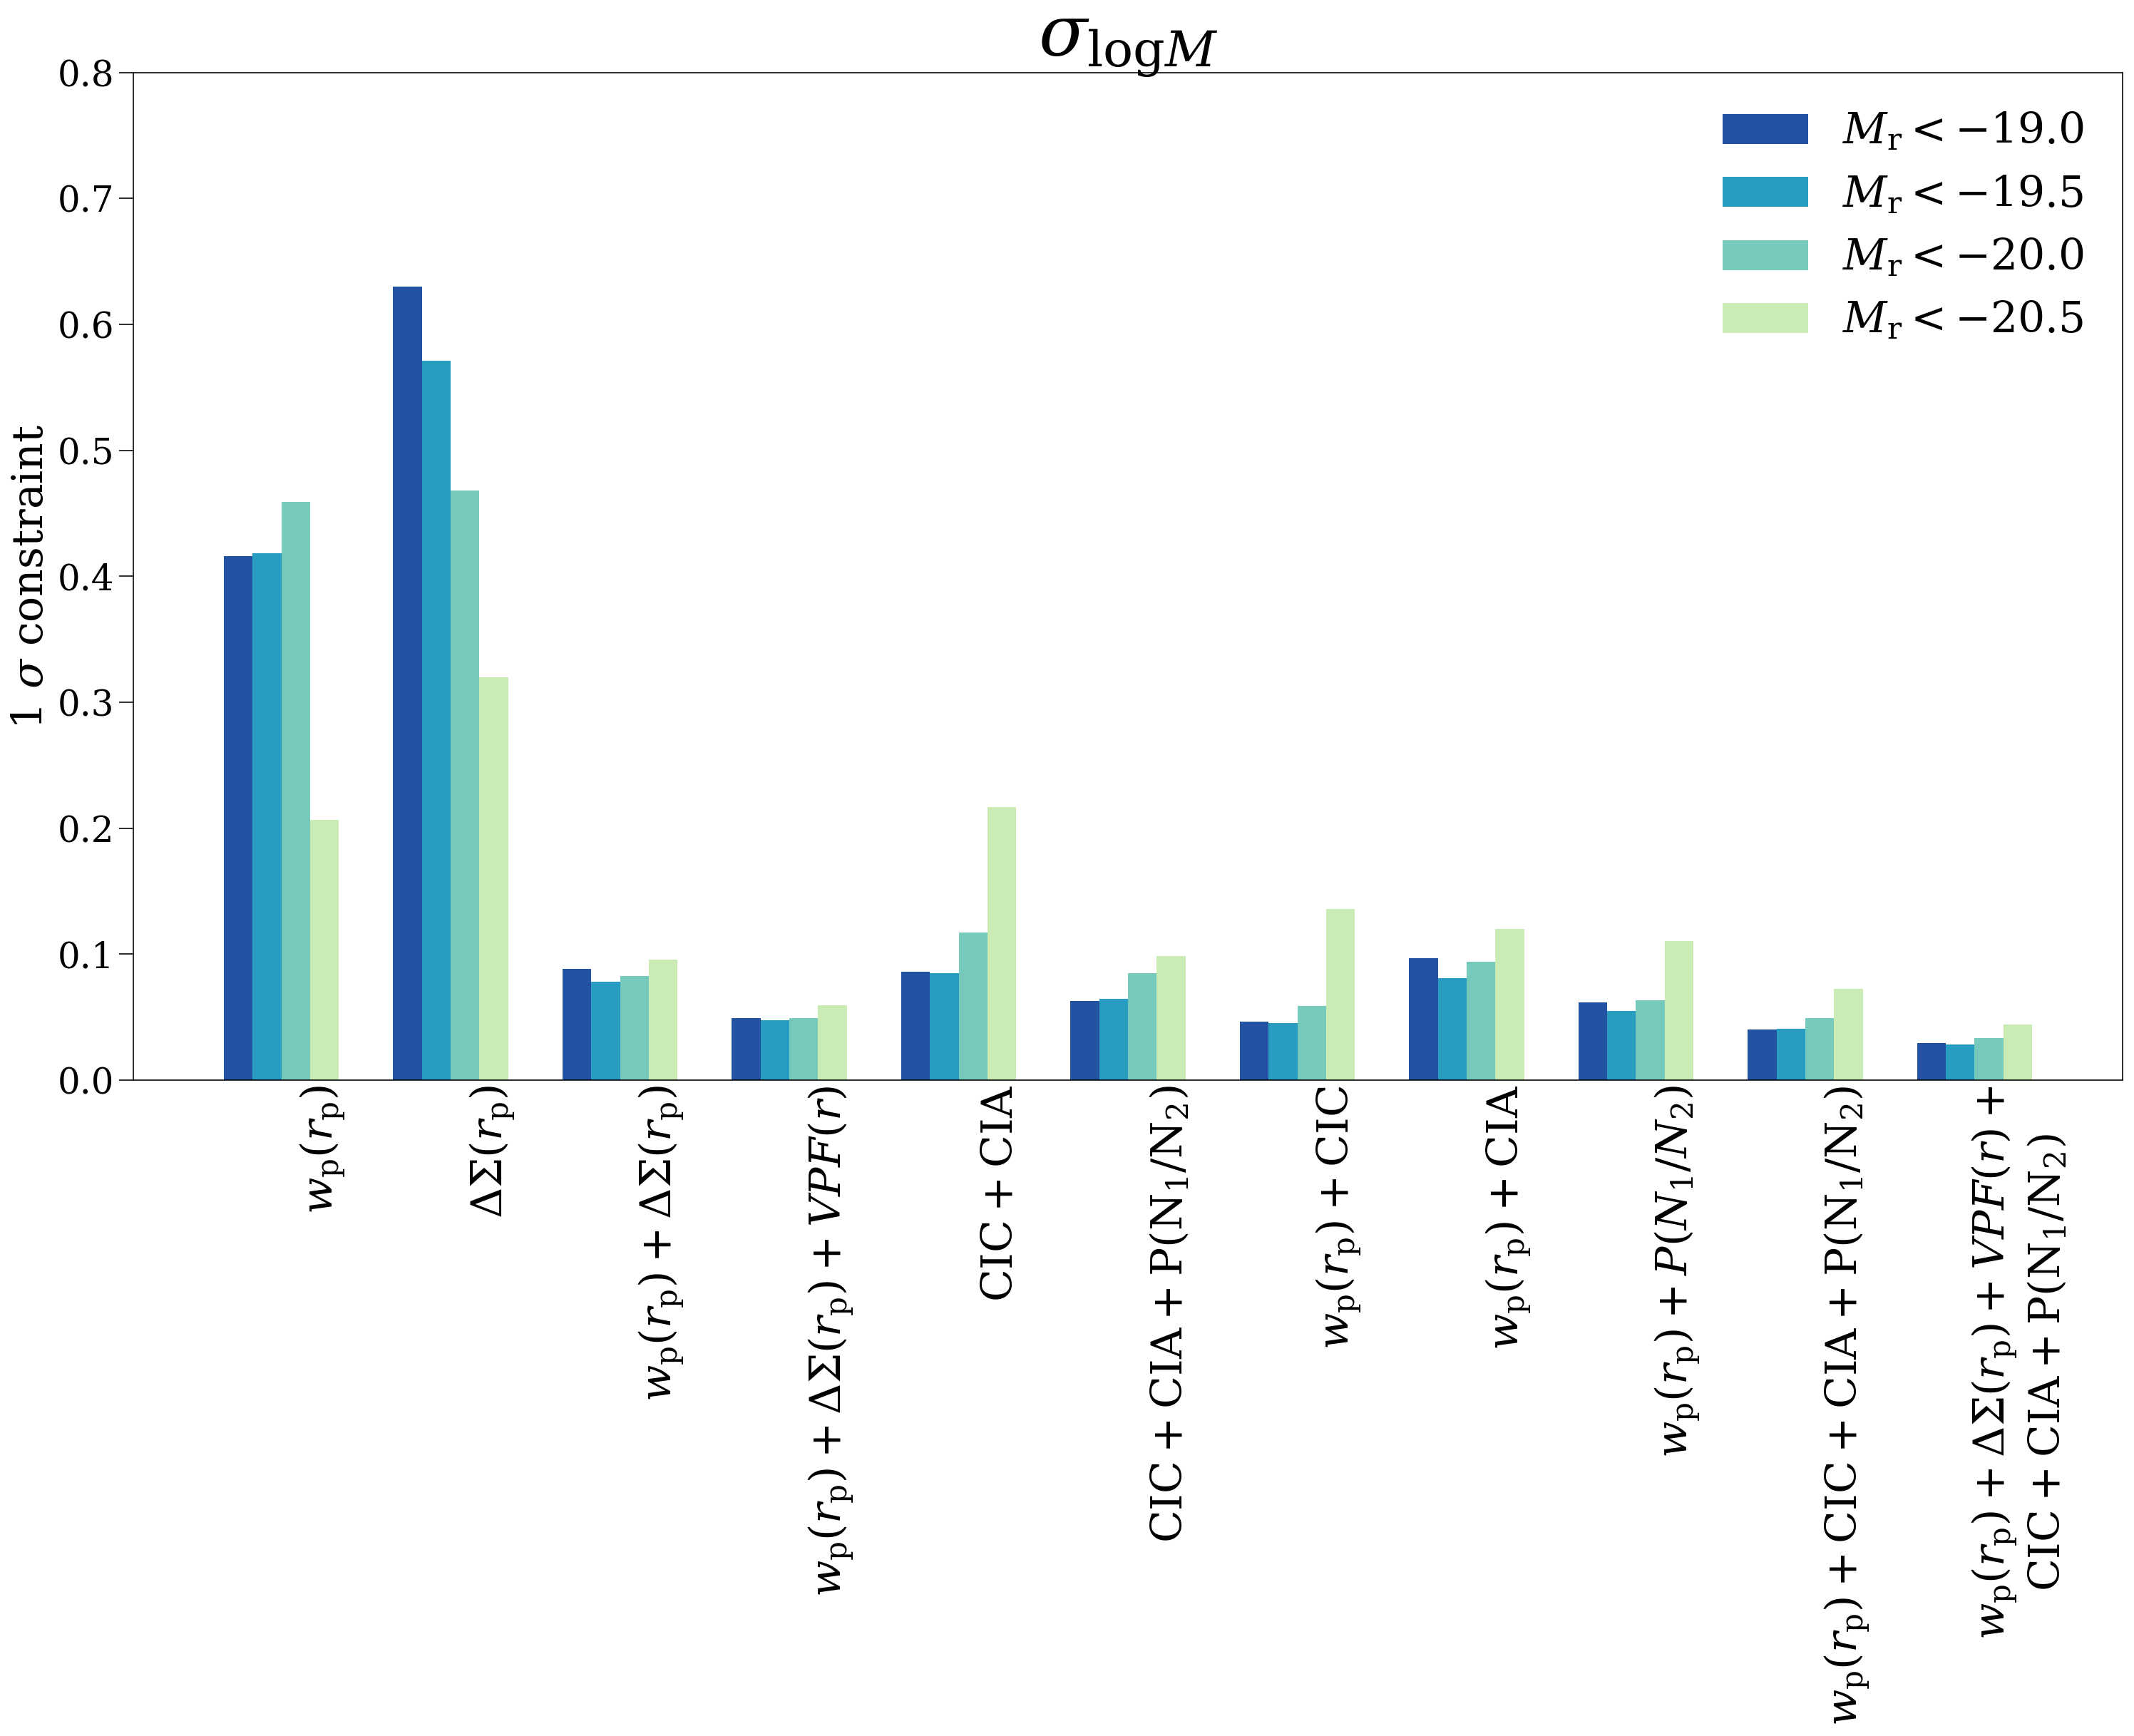

In [22]:
N = 11

ind = np.arange(N)  # the x locations for the groups
width = 0.17       # the width of the bars

fig, ax = plt.subplots(figsize=(25,13))
rects1 = ax.bar(ind, sigmalist_19p0[combidx,2], width, color=cm.YlGnBu(200))
rects2 = ax.bar(ind+width, sigmalist_19p5[combidx,2], width, color=cm.YlGnBu(150))
rects3 = ax.bar(ind+width*2, sigmalist_20p0[combidx,2], width, color=cm.YlGnBu(100))
rects4 = ax.bar(ind+width*3, sigmalist_20p5[combidx,2], width, color=cm.YlGnBu(60))

# add some text for labels, title and axes ticks
ax.set_ylabel(r'$1\ \sigma\ \rm{constraint}$',fontsize=30)
ax.set_title(param_list[2],fontsize=50)
ax.set_xticks(np.arange(N)+0.5)
ax.set_xticklabels(comblist,rotation=90,fontsize=30)
ax.set_yticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],fontsize=25)
ax.tick_params(axis='x',length=0)
ax.tick_params(axis='y',length=10)


ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),\
          (r'$M_{\rm{r}}<-19.0$',r'$M_{\rm{r}}<-19.5$',r'$M_{\rm{r}}<-20.0$',r'$M_{\rm{r}}<-20.5$'),frameon=False,fontsize=30)

ax.set_ylim(0,0.8)

plt.show()

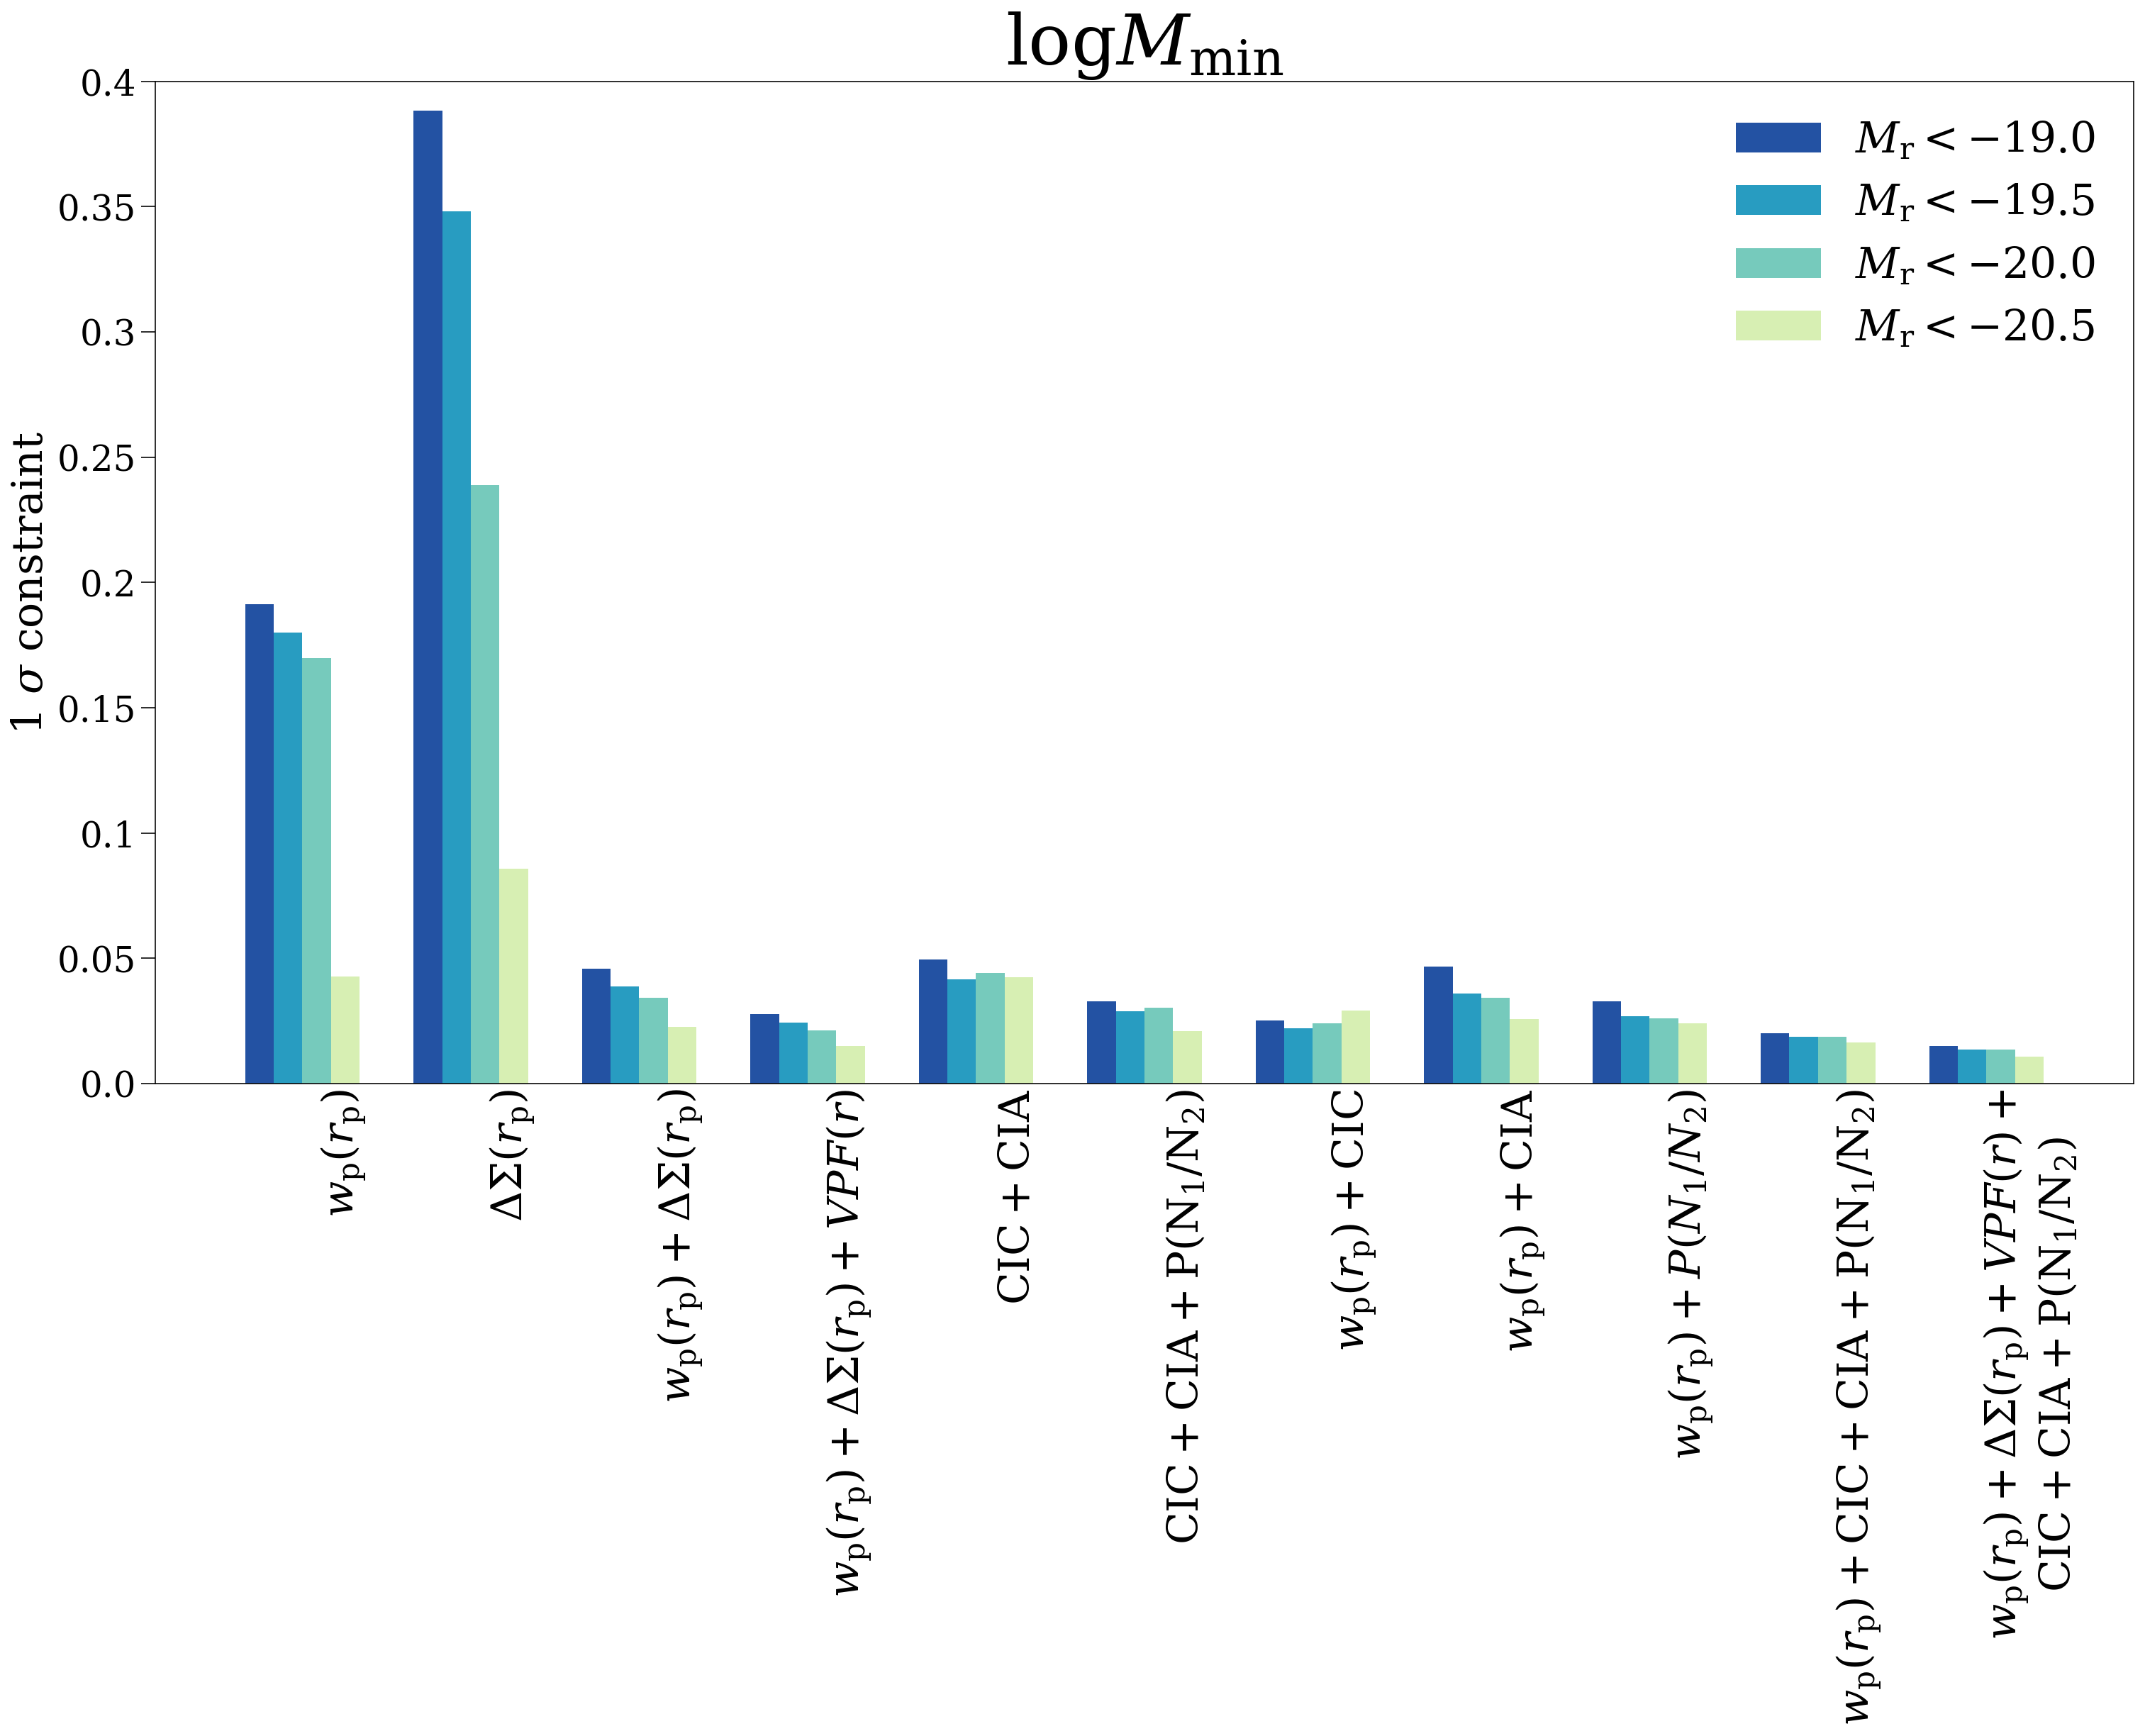

In [23]:
N = 11

ind = np.arange(N)  # the x locations for the groups
width = 0.17       # the width of the bars

fig, ax = plt.subplots(figsize=(25,13))
rects1 = ax.bar(ind, sigmalist_19p0[combidx,3], width, color=cm.YlGnBu(200))
rects2 = ax.bar(ind+width, sigmalist_19p5[combidx,3], width, color=cm.YlGnBu(150))
rects3 = ax.bar(ind+width*2, sigmalist_20p0[combidx,3], width, color=cm.YlGnBu(100))
rects4 = ax.bar(ind+width*3, sigmalist_20p5[combidx,3], width, color=cm.YlGnBu(50))

# add some text for labels, title and axes ticks
ax.set_ylabel(r'$1\ \sigma\ \rm{constraint}$',fontsize=30)
ax.set_title(param_list[3],fontsize=50)
ax.set_xticks(np.arange(N)+0.5)
ax.set_xticklabels(comblist,rotation=90,fontsize=30)
ax.set_yticklabels([0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4],fontsize=25)
ax.tick_params(axis='x',length=0)
ax.tick_params(axis='y',length=10)


ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),\
          (r'$M_{\rm{r}}<-19.0$',r'$M_{\rm{r}}<-19.5$',r'$M_{\rm{r}}<-20.0$',r'$M_{\rm{r}}<-20.5$'),frameon=False,fontsize=30)

ax.set_ylim(0,0.4)

plt.show()

In [24]:
sigmalist_u_19p0 = []
sigmalist_u_19p5 = []
sigmalist_u_20p0 = []
sigmalist_u_20p5 = []

for k in klist:
    sigmalist_u_19p0.append(sigma_u_tm_19p0[k])
    sigmalist_u_19p5.append(sigma_u_tm_19p5[k])
    sigmalist_u_20p0.append(sigma_u_tm_20p0[k])
    sigmalist_u_20p5.append(sigma_u_tm_20p5[k])
    
sigmalist_u_19p0 = np.array(sigmalist_u_19p0)
sigmalist_u_19p5 = np.array(sigmalist_u_19p5)
sigmalist_u_20p0 = np.array(sigmalist_u_20p0)
sigmalist_u_20p5 = np.array(sigmalist_u_20p5)

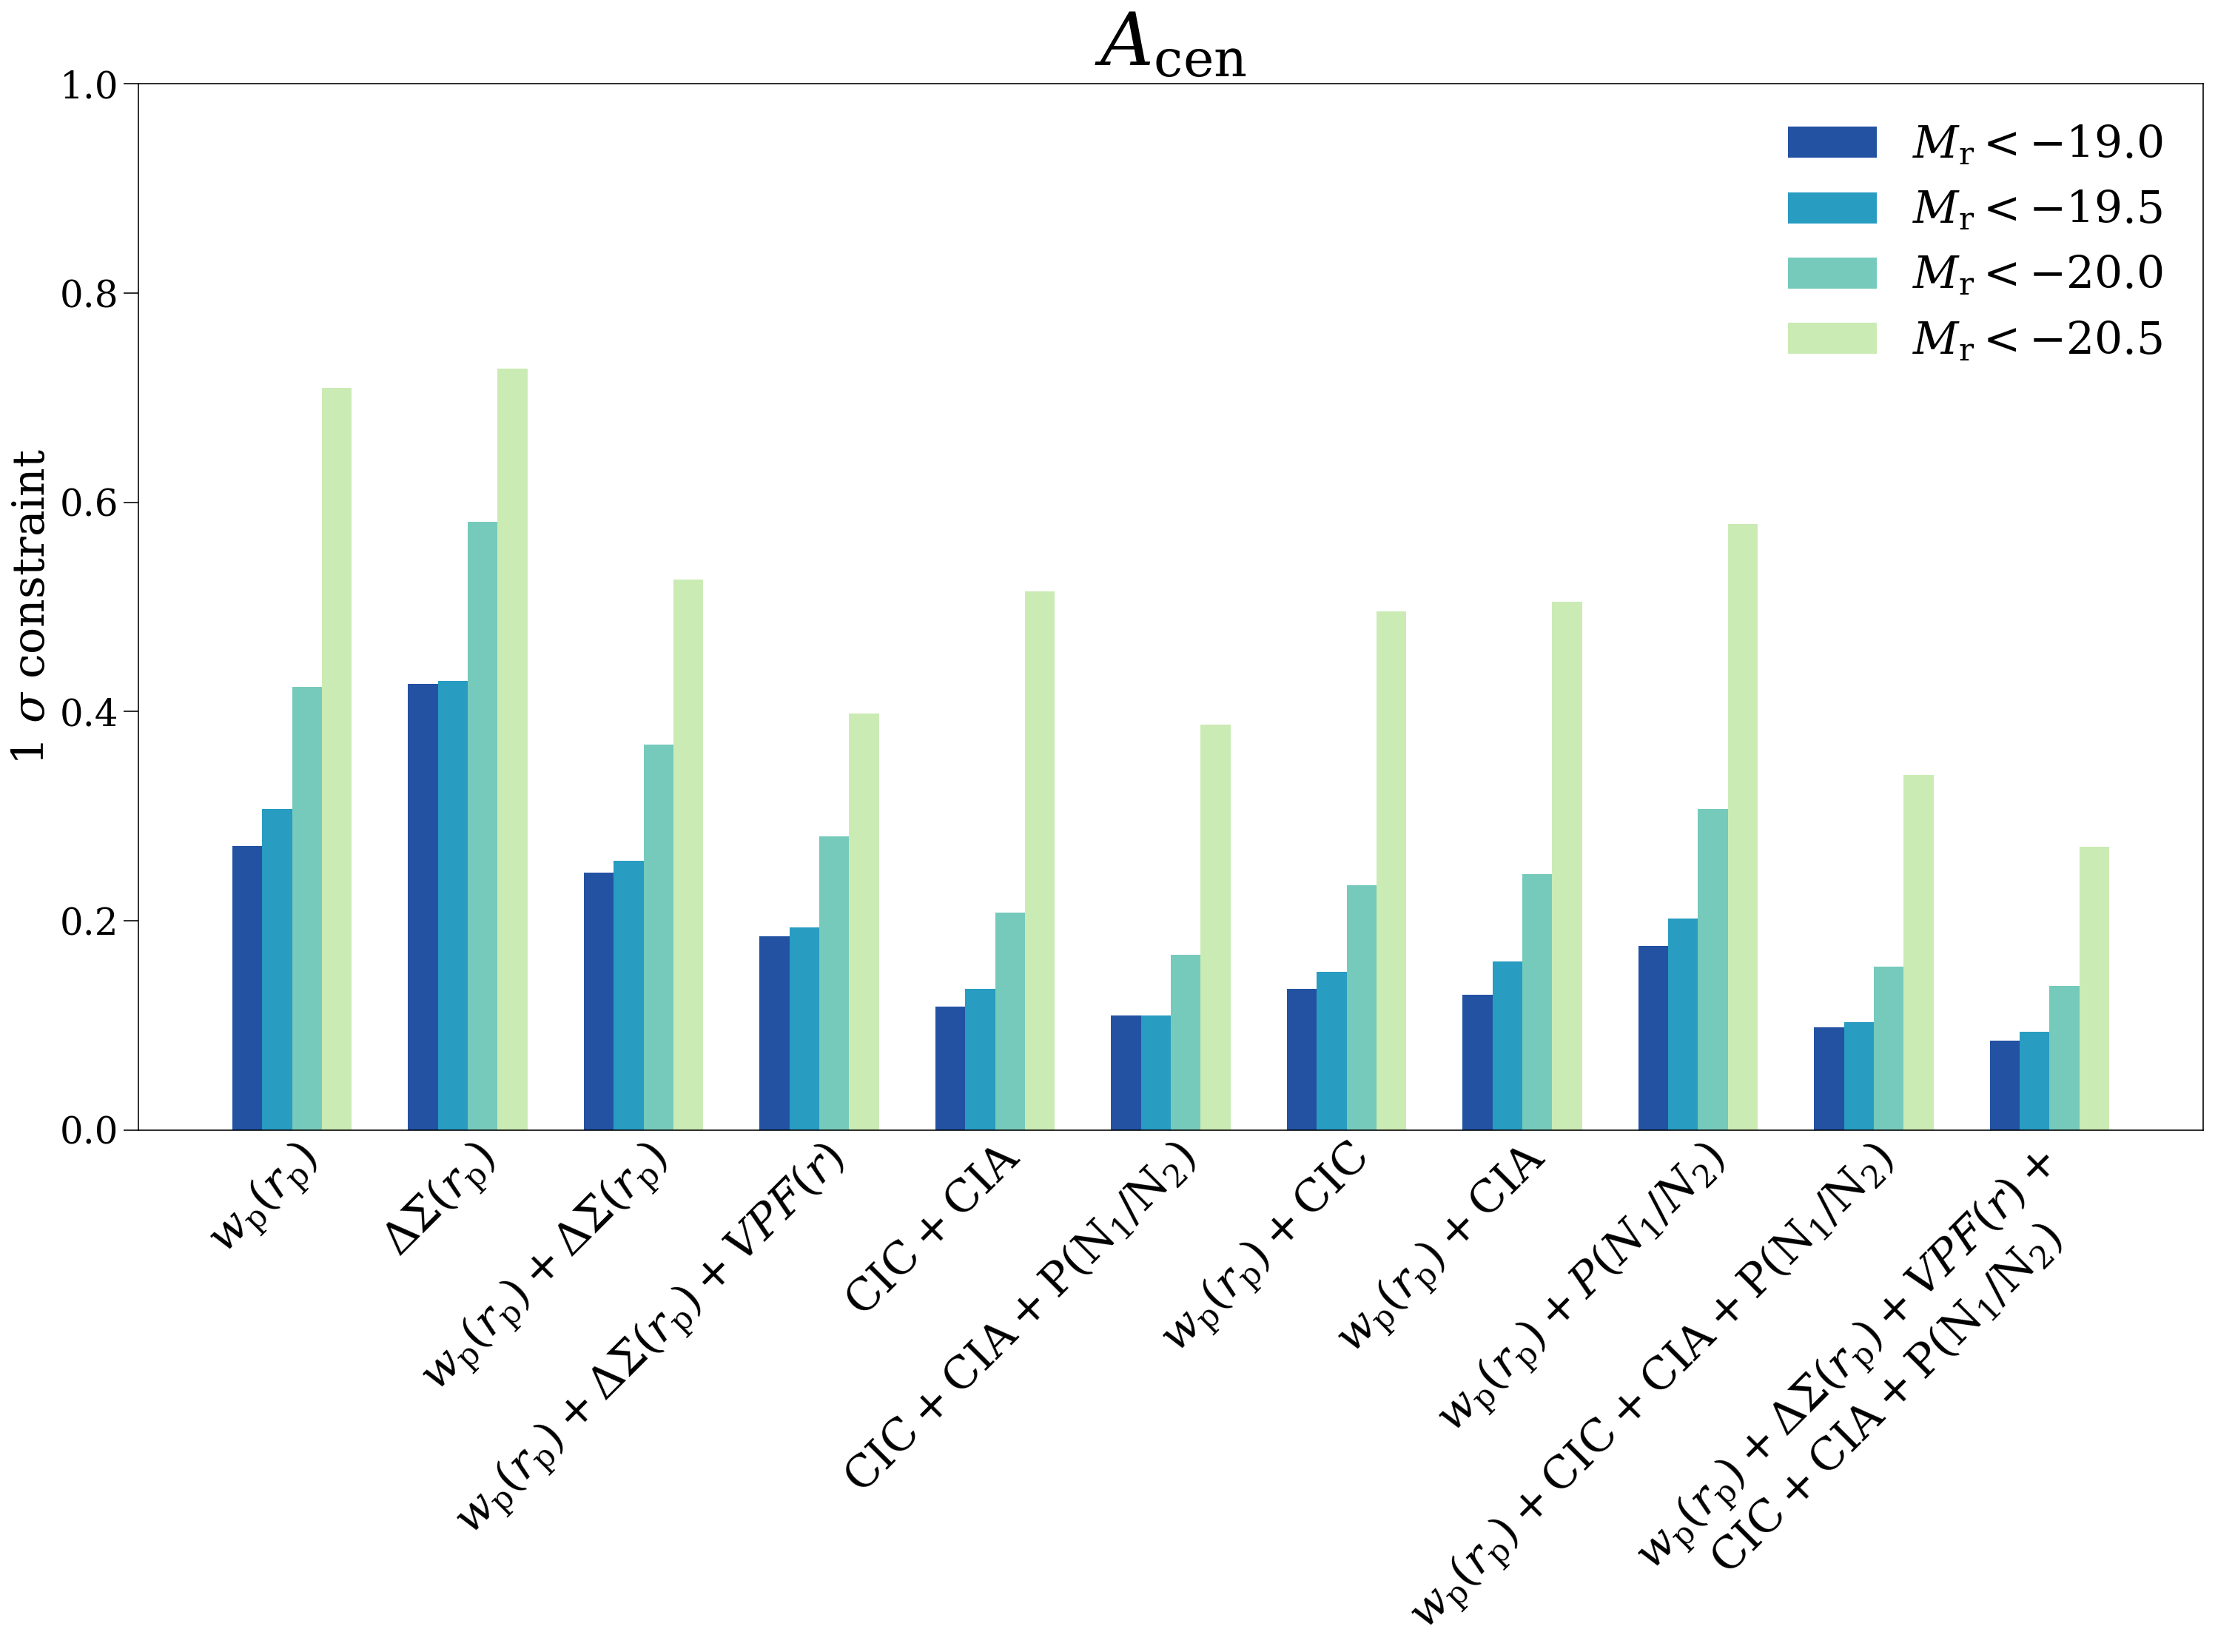

In [25]:
N = 11

ind = np.arange(N)  # the x locations for the groups
width = 0.17       # the width of the bars

fig, ax = plt.subplots(figsize=(25,13))
rects1 = ax.bar(ind, sigmalist_u_19p0[combidx,4], width, color=cm.YlGnBu(200))
rects2 = ax.bar(ind+width, sigmalist_u_19p5[combidx,4], width, color=cm.YlGnBu(150))
rects3 = ax.bar(ind+width*2, sigmalist_u_20p0[combidx,4], width, color=cm.YlGnBu(100))
rects4 = ax.bar(ind+width*3, sigmalist_u_20p5[combidx,4], width, color=cm.YlGnBu(60))

# add some text for labels, title and axes ticks
ax.set_ylabel(r'$1\ \sigma\ \rm{constraint}$',fontsize=30)
ax.set_title(param_list[4],fontsize=50)
ax.set_xticks([0.1,1.1,1.7,2.3,3.9,4.4,5.8,6.8,7.6,8,9.2])
ax.set_xticklabels(comblist,rotation=45,fontsize=30)
ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=25)
ax.tick_params(axis='x',length=0)
ax.tick_params(axis='y',length=10)


ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),\
          (r'$M_{\rm{r}}<-19.0$',r'$M_{\rm{r}}<-19.5$',r'$M_{\rm{r}}<-20.0$',r'$M_{\rm{r}}<-20.5$'),frameon=False,fontsize=30)

ax.set_ylim(0,1.0)

plt.show()

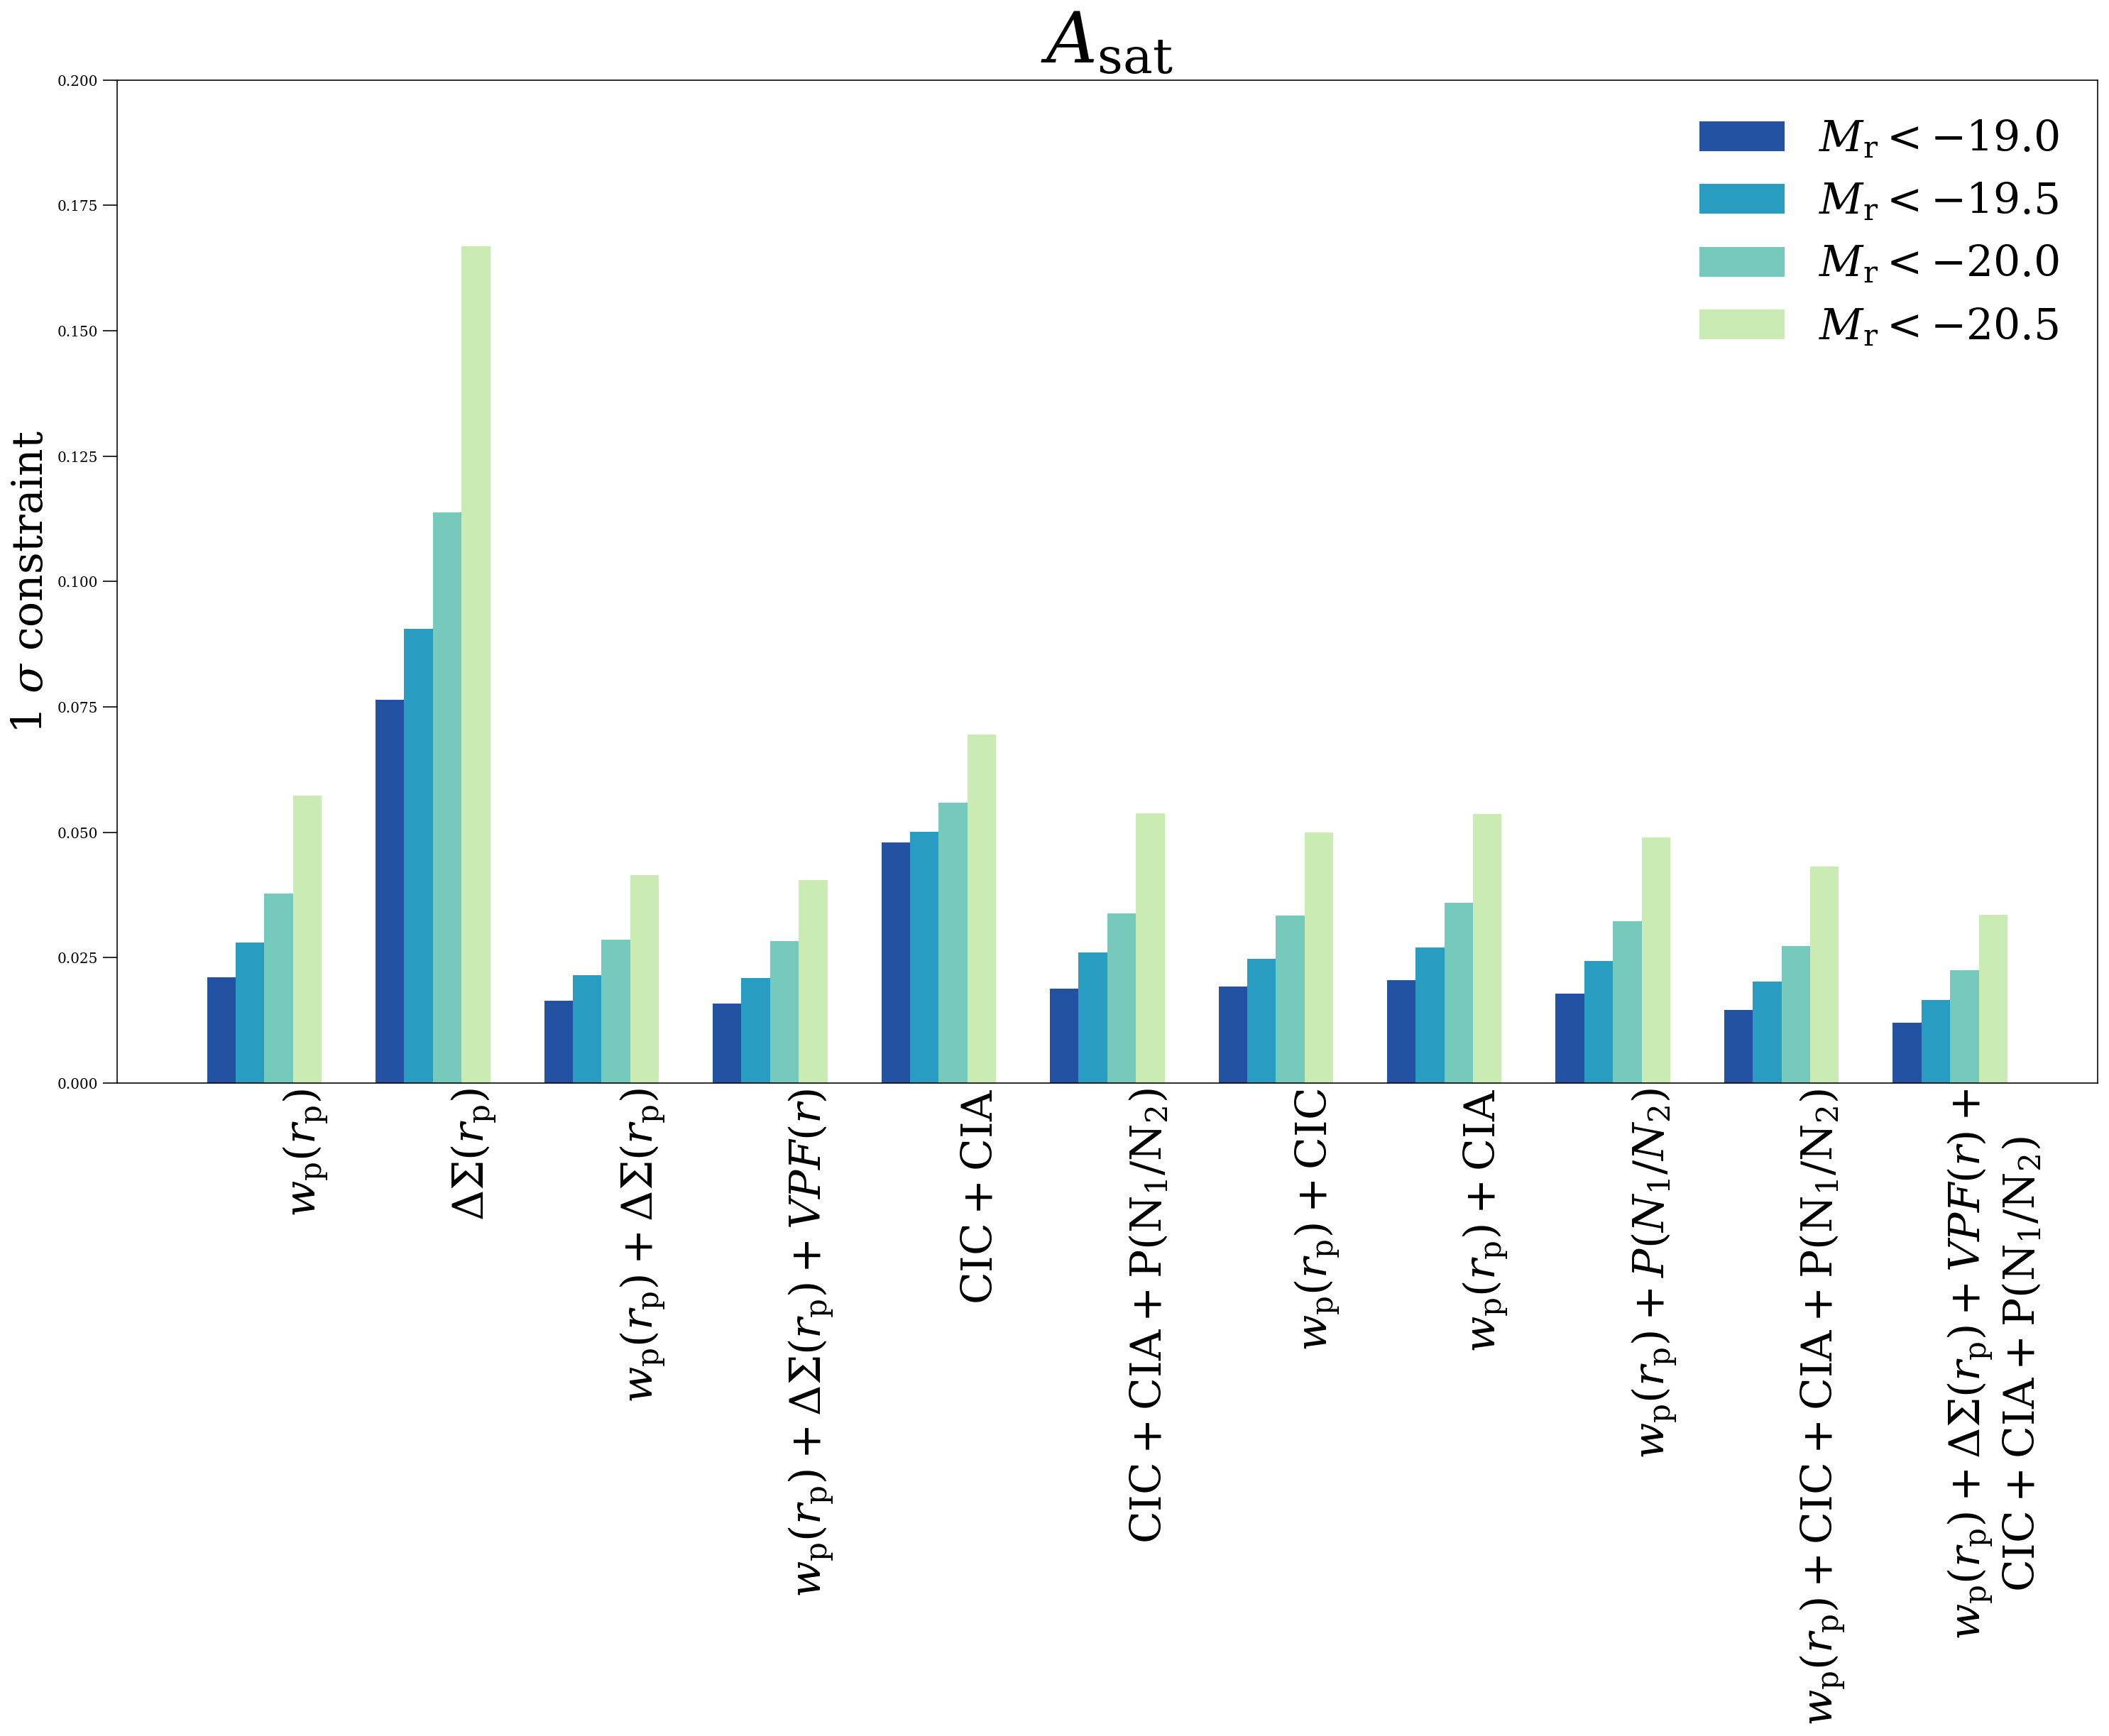

In [28]:
N = 11

ind = np.arange(N)  # the x locations for the groups
width = 0.17       # the width of the bars

fig, ax = plt.subplots(figsize=(25,13))
rects1 = ax.bar(ind, sigmalist_u_19p0[combidx,5], width, color=cm.YlGnBu(200))
rects2 = ax.bar(ind+width, sigmalist_u_19p5[combidx,5], width, color=cm.YlGnBu(150))
rects3 = ax.bar(ind+width*2, sigmalist_u_20p0[combidx,5], width, color=cm.YlGnBu(100))
rects4 = ax.bar(ind+width*3, sigmalist_u_20p5[combidx,5], width, color=cm.YlGnBu(60))

# add some text for labels, title and axes ticks
ax.set_ylabel(r'$1\ \sigma\ \rm{constraint}$',fontsize=30)
ax.set_title(param_list[5],fontsize=50)
ax.set_xticks(np.arange(N)+0.5)
ax.set_xticklabels(comblist,rotation=90,fontsize=30)
#ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=25)
ax.tick_params(axis='x',length=0)
ax.tick_params(axis='y',length=10)


ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),\
          (r'$M_{\rm{r}}<-19.0$',r'$M_{\rm{r}}<-19.5$',r'$M_{\rm{r}}<-20.0$',r'$M_{\rm{r}}<-20.5$'),frameon=False,fontsize=30)

ax.set_ylim(0,0.2)

plt.show()

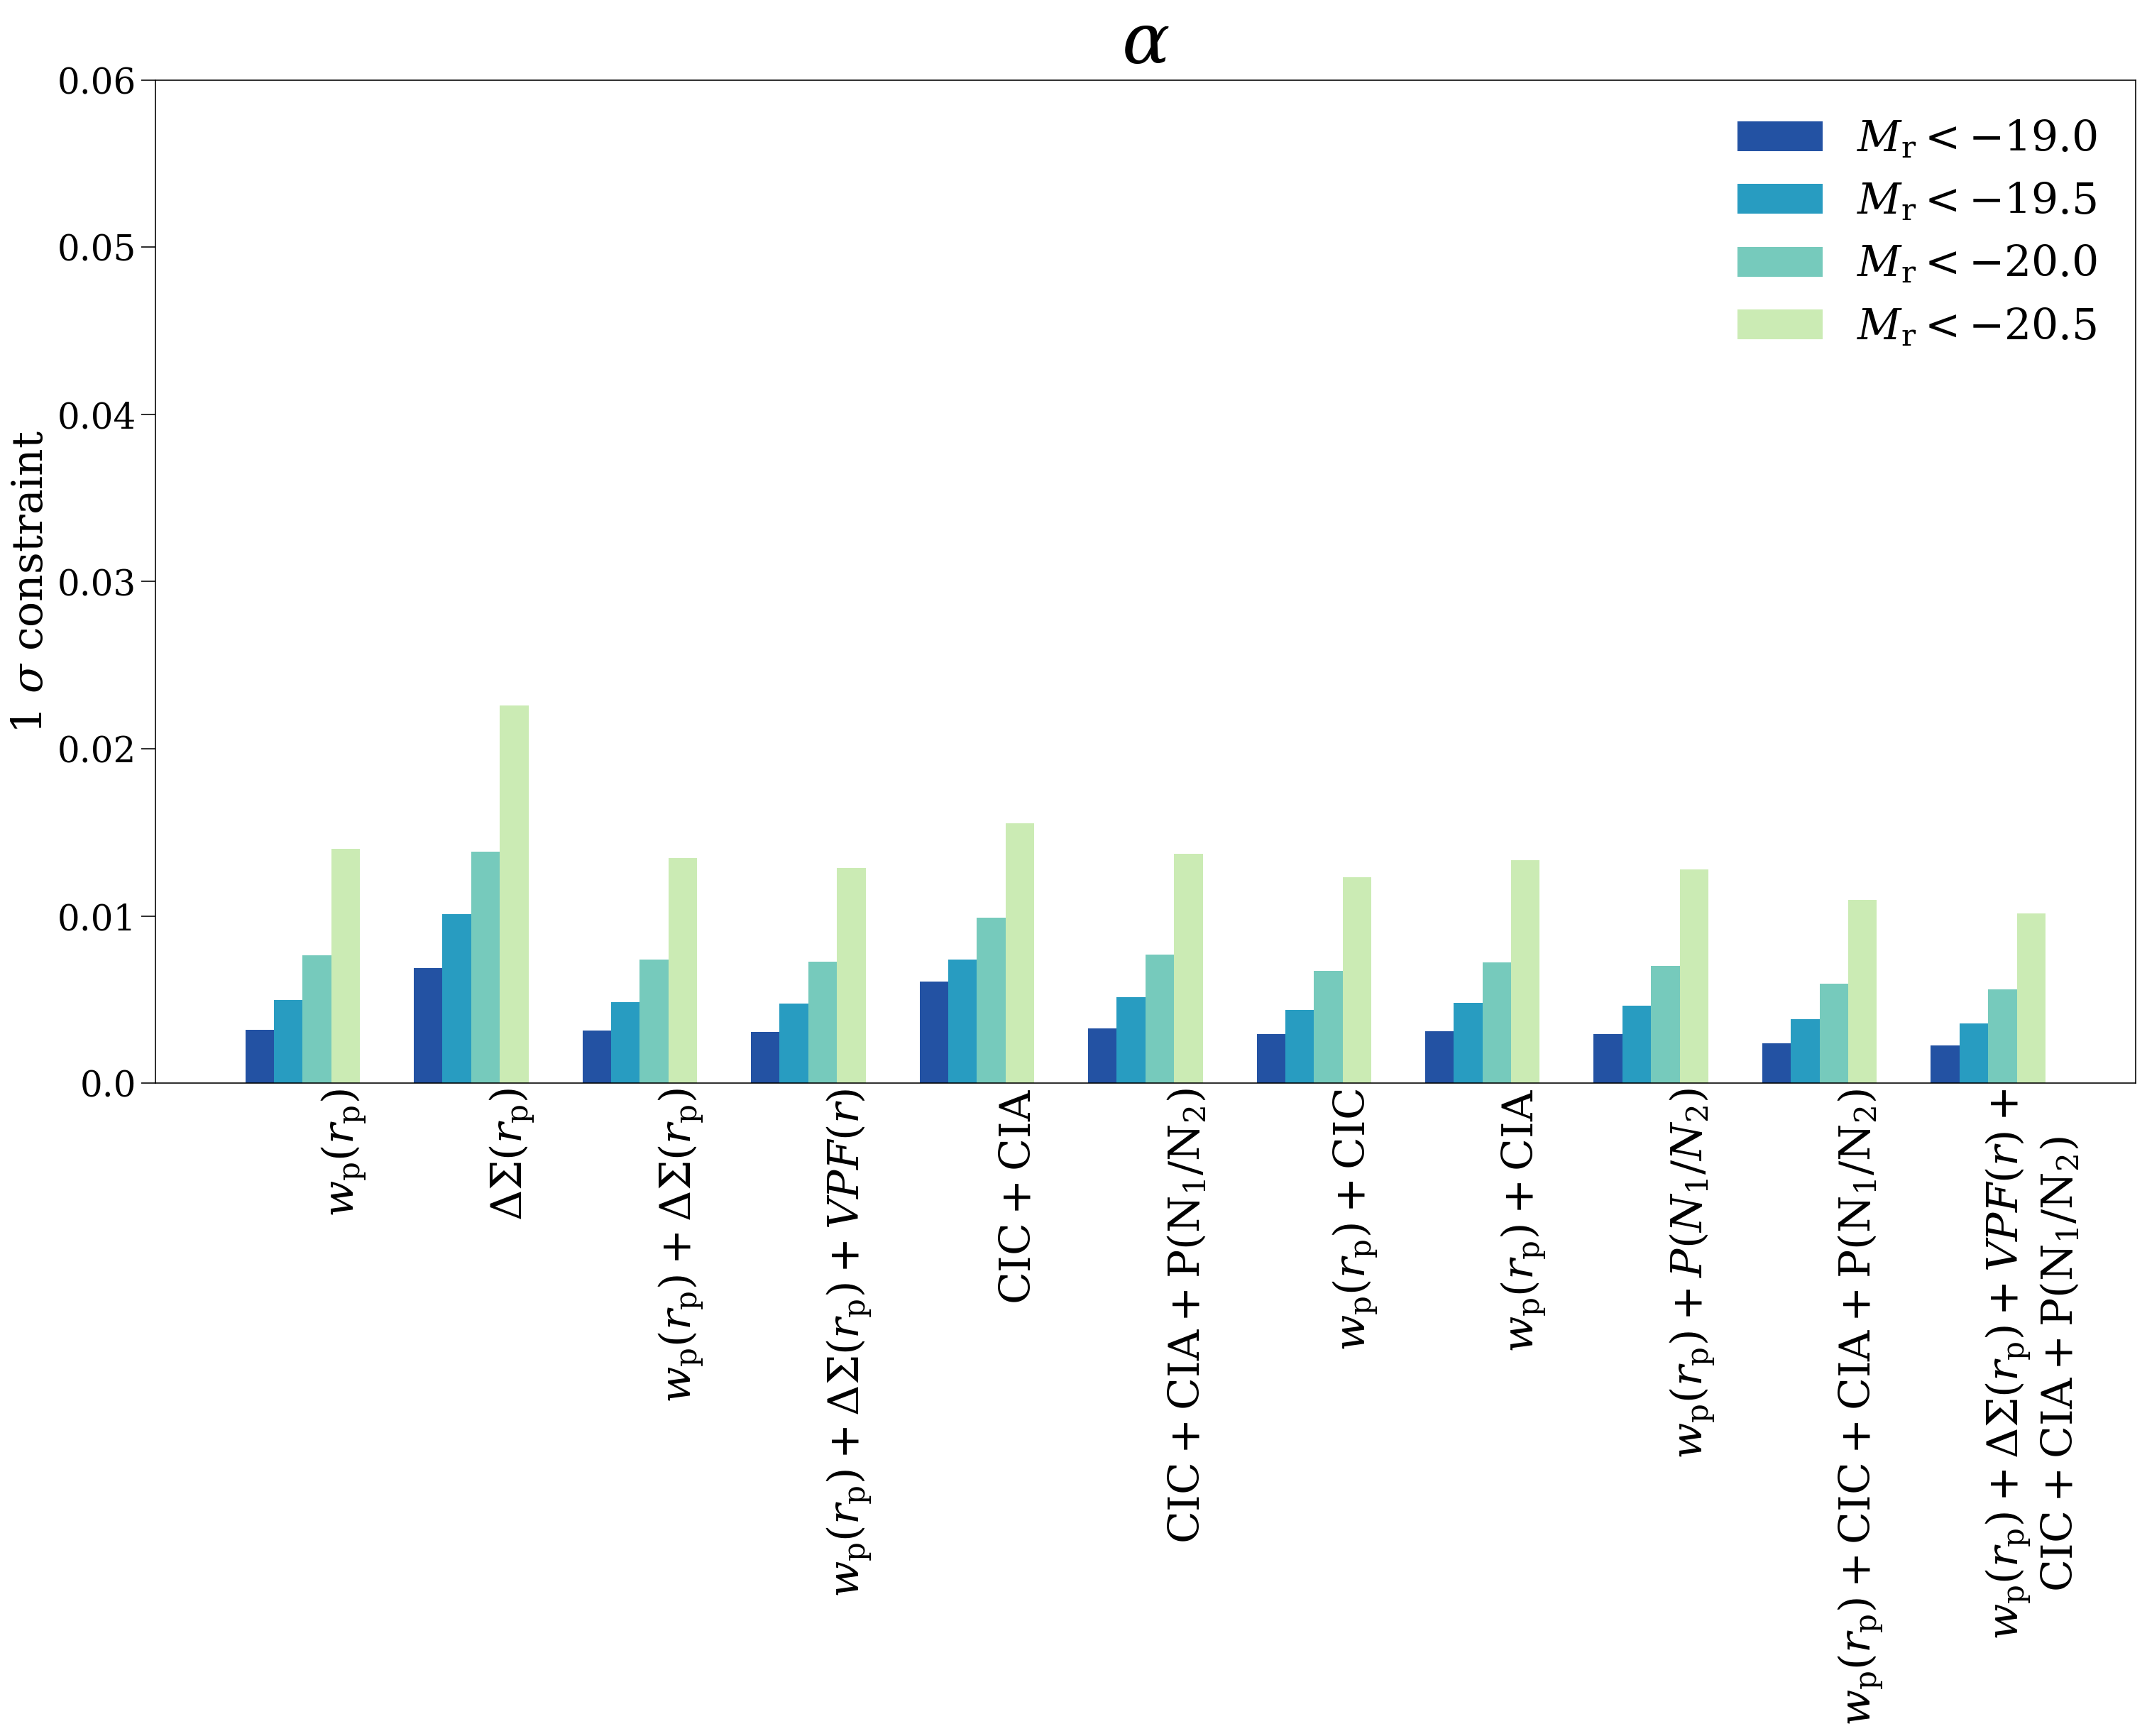

In [29]:
N = 11

ind = np.arange(N)  # the x locations for the groups
width = 0.17       # the width of the bars

fig, ax = plt.subplots(figsize=(25,13))
rects1 = ax.bar(ind, sigmalist_u_19p0[combidx,0], width, color=cm.YlGnBu(200))
rects2 = ax.bar(ind+width, sigmalist_u_19p5[combidx,0], width, color=cm.YlGnBu(150))
rects3 = ax.bar(ind+width*2, sigmalist_u_20p0[combidx,0], width, color=cm.YlGnBu(100))
rects4 = ax.bar(ind+width*3, sigmalist_u_20p5[combidx,0], width, color=cm.YlGnBu(60))

# add some text for labels, title and axes ticks
ax.set_ylabel(r'$1\ \sigma\ \rm{constraint}$',fontsize=30)
ax.set_title(param_list[0],fontsize=50)
ax.set_xticks(np.arange(N)+0.5)
ax.set_xticklabels(comblist,rotation=90,fontsize=30)
ax.set_yticklabels([0.0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize=25)
ax.tick_params(axis='x',length=0)
ax.tick_params(axis='y',length=10)


ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),\
          (r'$M_{\rm{r}}<-19.0$',r'$M_{\rm{r}}<-19.5$',r'$M_{\rm{r}}<-20.0$',r'$M_{\rm{r}}<-20.5$'),frameon=False,fontsize=30)

ax.set_ylim(0,0.06)

plt.show()

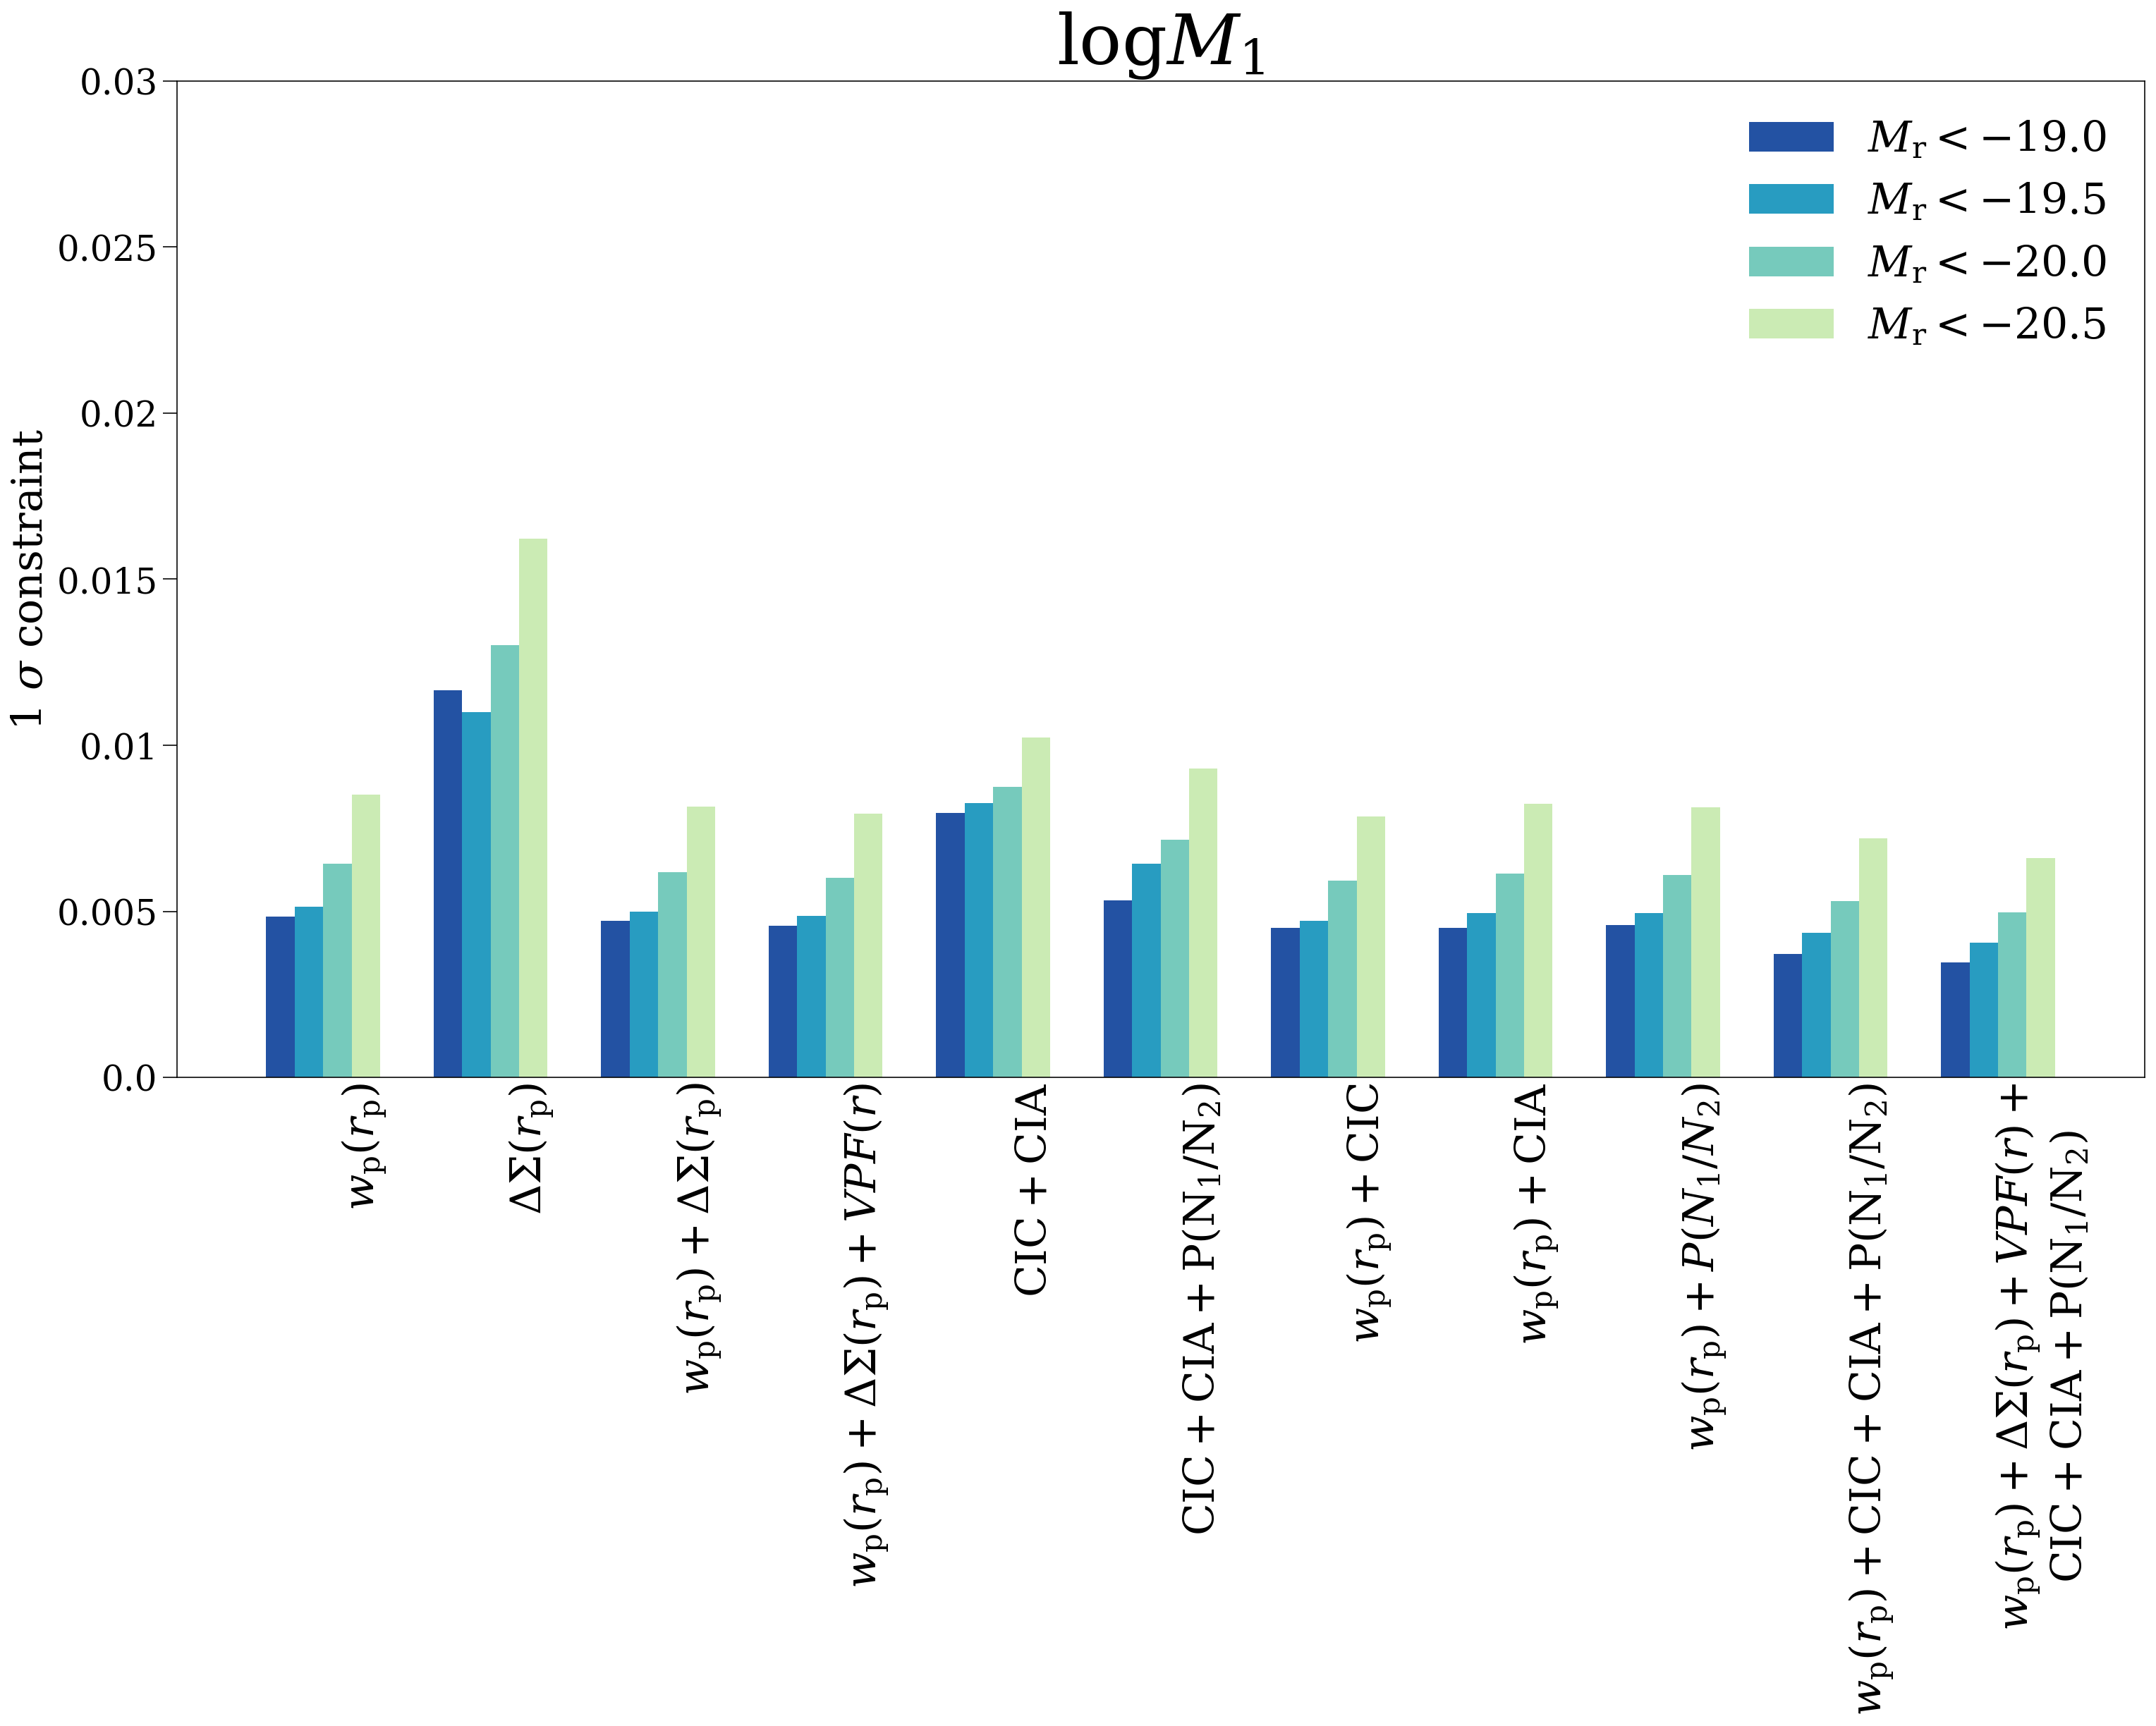

In [30]:
N = 11

ind = np.arange(N)  # the x locations for the groups
width = 0.17       # the width of the bars

fig, ax = plt.subplots(figsize=(25,13))
rects1 = ax.bar(ind, sigmalist_u_19p0[combidx,1], width, color=cm.YlGnBu(200))
rects2 = ax.bar(ind+width, sigmalist_u_19p5[combidx,1], width, color=cm.YlGnBu(150))
rects3 = ax.bar(ind+width*2, sigmalist_u_20p0[combidx,1], width, color=cm.YlGnBu(100))
rects4 = ax.bar(ind+width*3, sigmalist_u_20p5[combidx,1], width, color=cm.YlGnBu(60))

# add some text for labels, title and axes ticks
ax.set_ylabel(r'$1\ \sigma\ \rm{constraint}$',fontsize=30)
ax.set_title(param_list[1],fontsize=50)
ax.set_xticks(np.arange(N)+0.5)
ax.set_xticklabels(comblist,rotation=90,fontsize=30)
ax.set_yticklabels([0.0,0.005,0.01,0.015,0.02,0.025,0.03],fontsize=25)
ax.tick_params(axis='x',length=0)
ax.tick_params(axis='y',length=10)


ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),\
          (r'$M_{\rm{r}}<-19.0$',r'$M_{\rm{r}}<-19.5$',r'$M_{\rm{r}}<-20.0$',r'$M_{\rm{r}}<-20.5$'),frameon=False,fontsize=30)

ax.set_ylim(0,0.03)

plt.show()

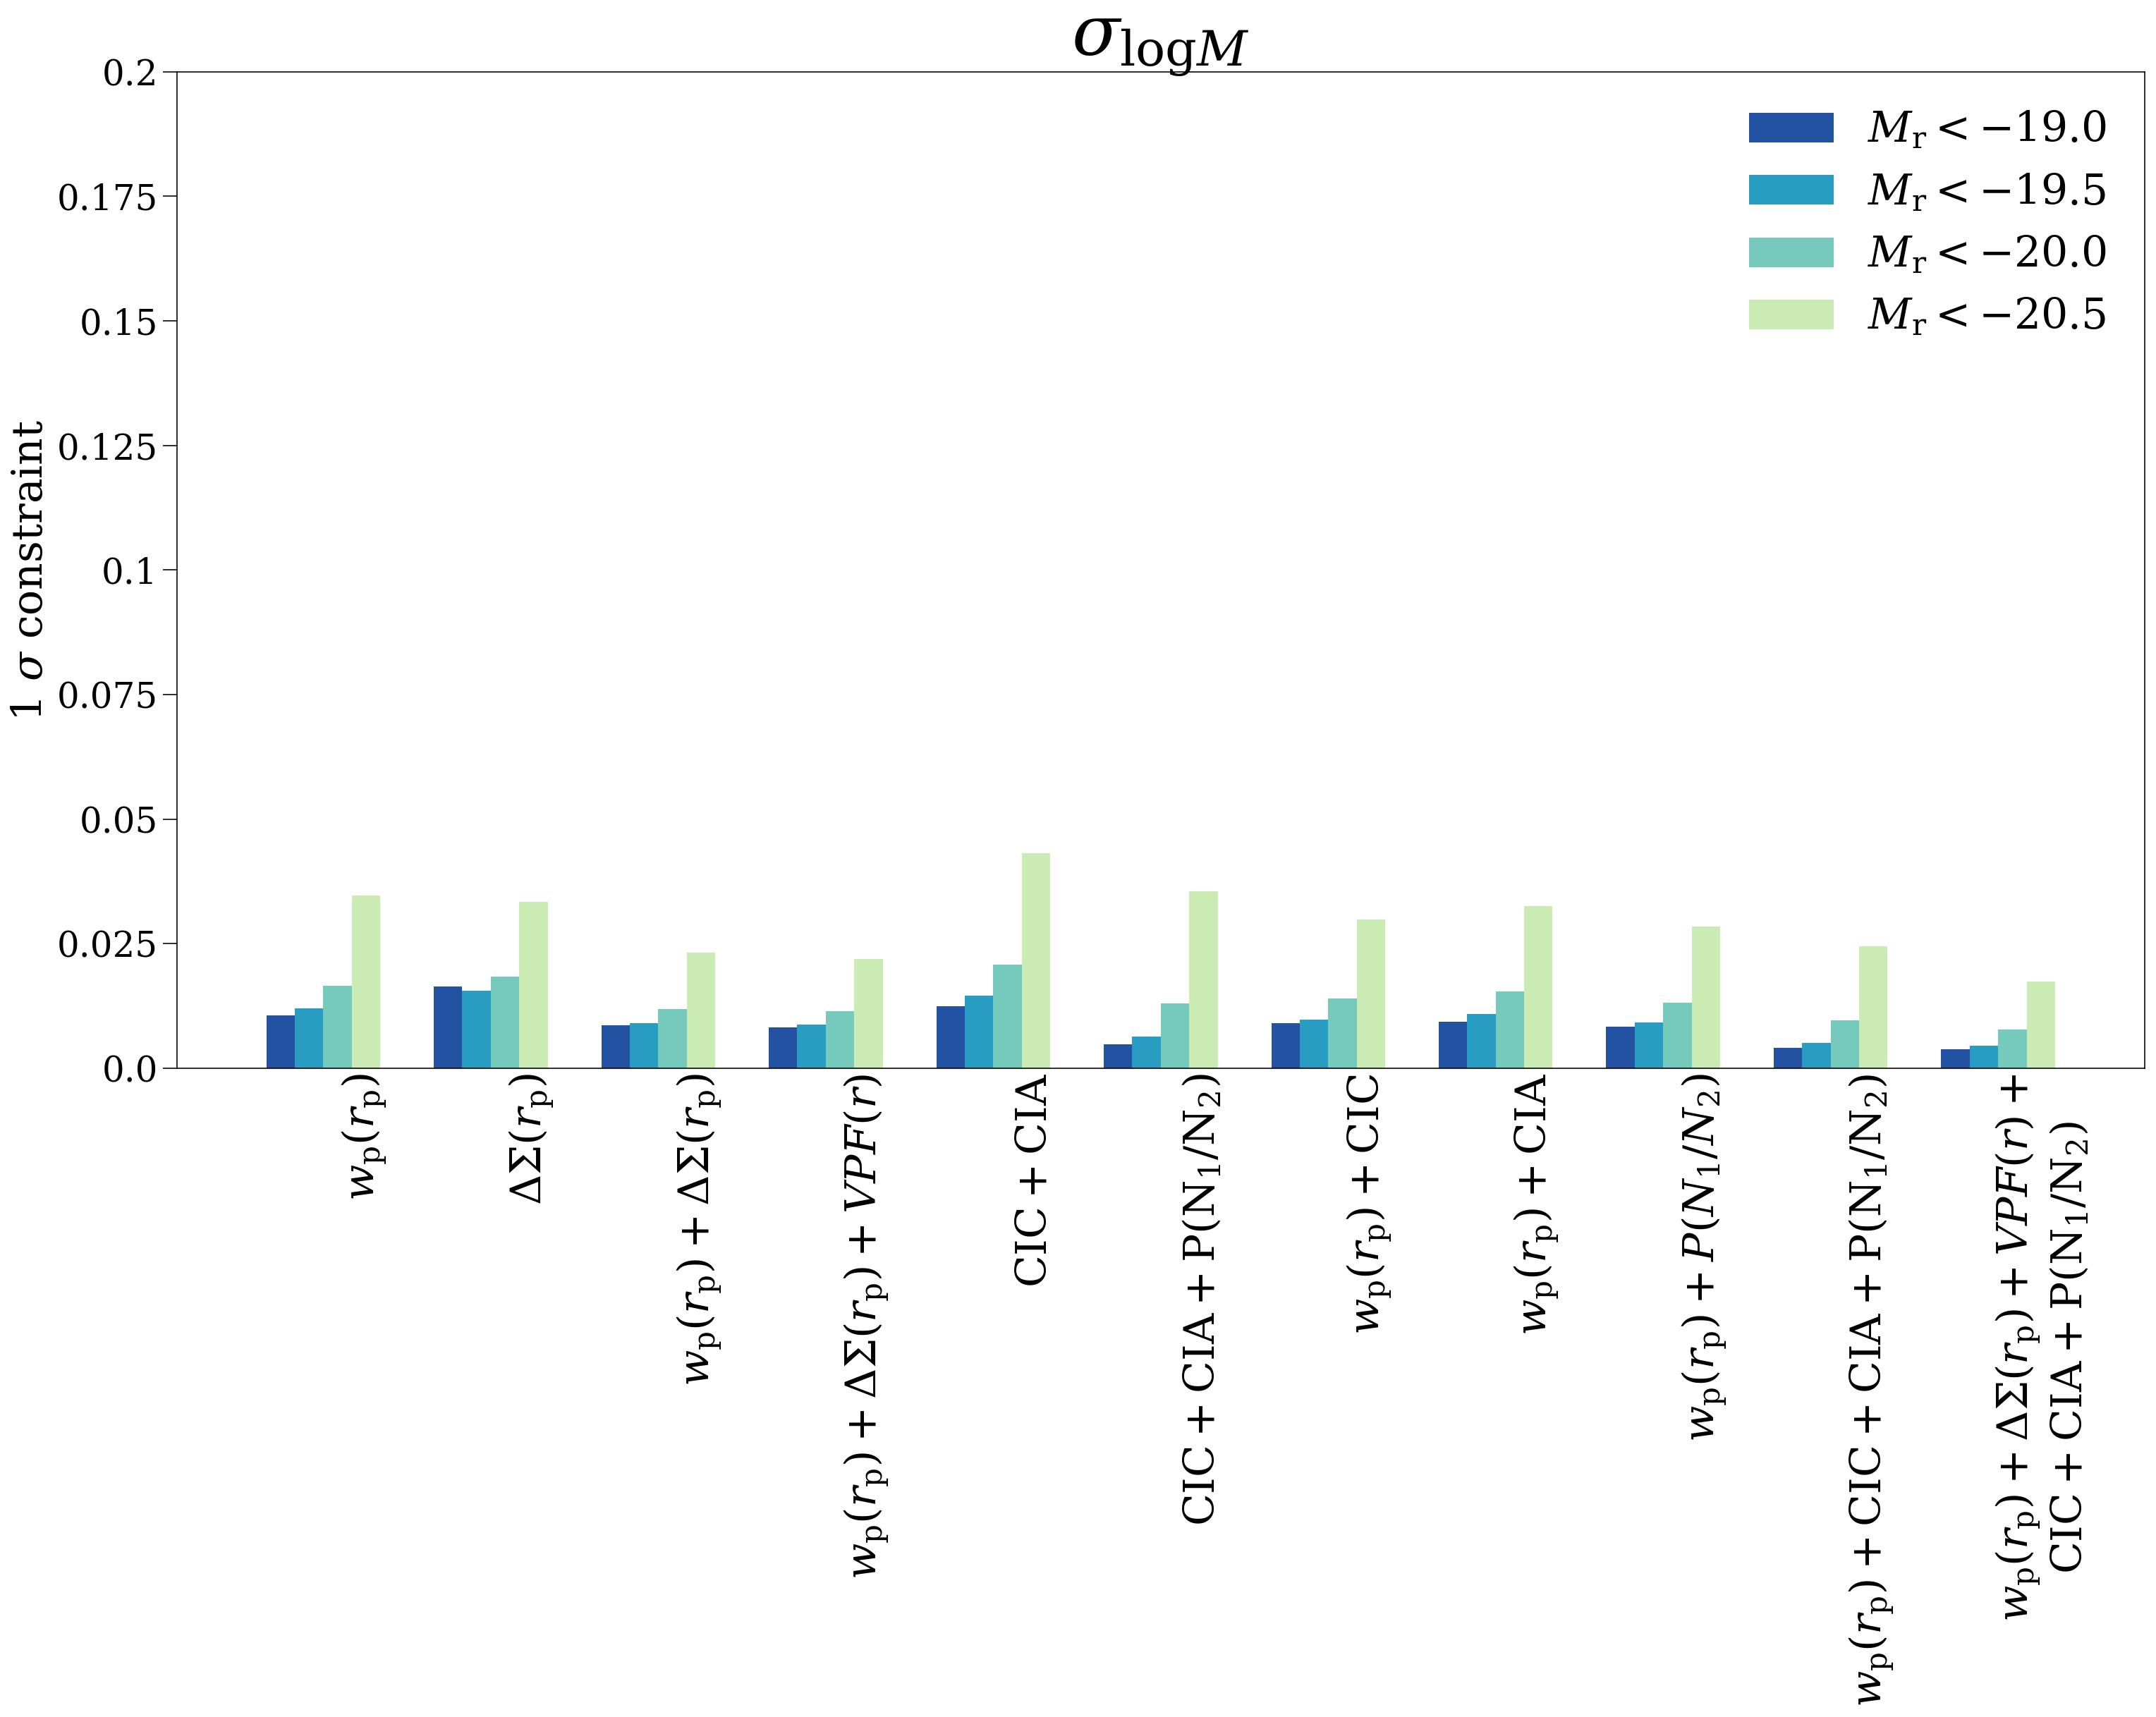

In [31]:
N = 11

ind = np.arange(N)  # the x locations for the groups
width = 0.17       # the width of the bars

fig, ax = plt.subplots(figsize=(25,13))
rects1 = ax.bar(ind, sigmalist_u_19p0[combidx,2], width, color=cm.YlGnBu(200))
rects2 = ax.bar(ind+width, sigmalist_u_19p5[combidx,2], width, color=cm.YlGnBu(150))
rects3 = ax.bar(ind+width*2, sigmalist_u_20p0[combidx,2], width, color=cm.YlGnBu(100))
rects4 = ax.bar(ind+width*3, sigmalist_u_20p5[combidx,2], width, color=cm.YlGnBu(60))

# add some text for labels, title and axes ticks
ax.set_ylabel(r'$1\ \sigma\ \rm{constraint}$',fontsize=30)
ax.set_title(param_list[2],fontsize=50)
ax.set_xticks(np.arange(N)+0.5)
ax.set_xticklabels(comblist,rotation=90,fontsize=30)
ax.set_yticklabels([0.0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2],fontsize=25)
ax.tick_params(axis='x',length=0)
ax.tick_params(axis='y',length=10)


ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),\
          (r'$M_{\rm{r}}<-19.0$',r'$M_{\rm{r}}<-19.5$',r'$M_{\rm{r}}<-20.0$',r'$M_{\rm{r}}<-20.5$'),frameon=False,fontsize=30)

ax.set_ylim(0,0.2)

plt.show()

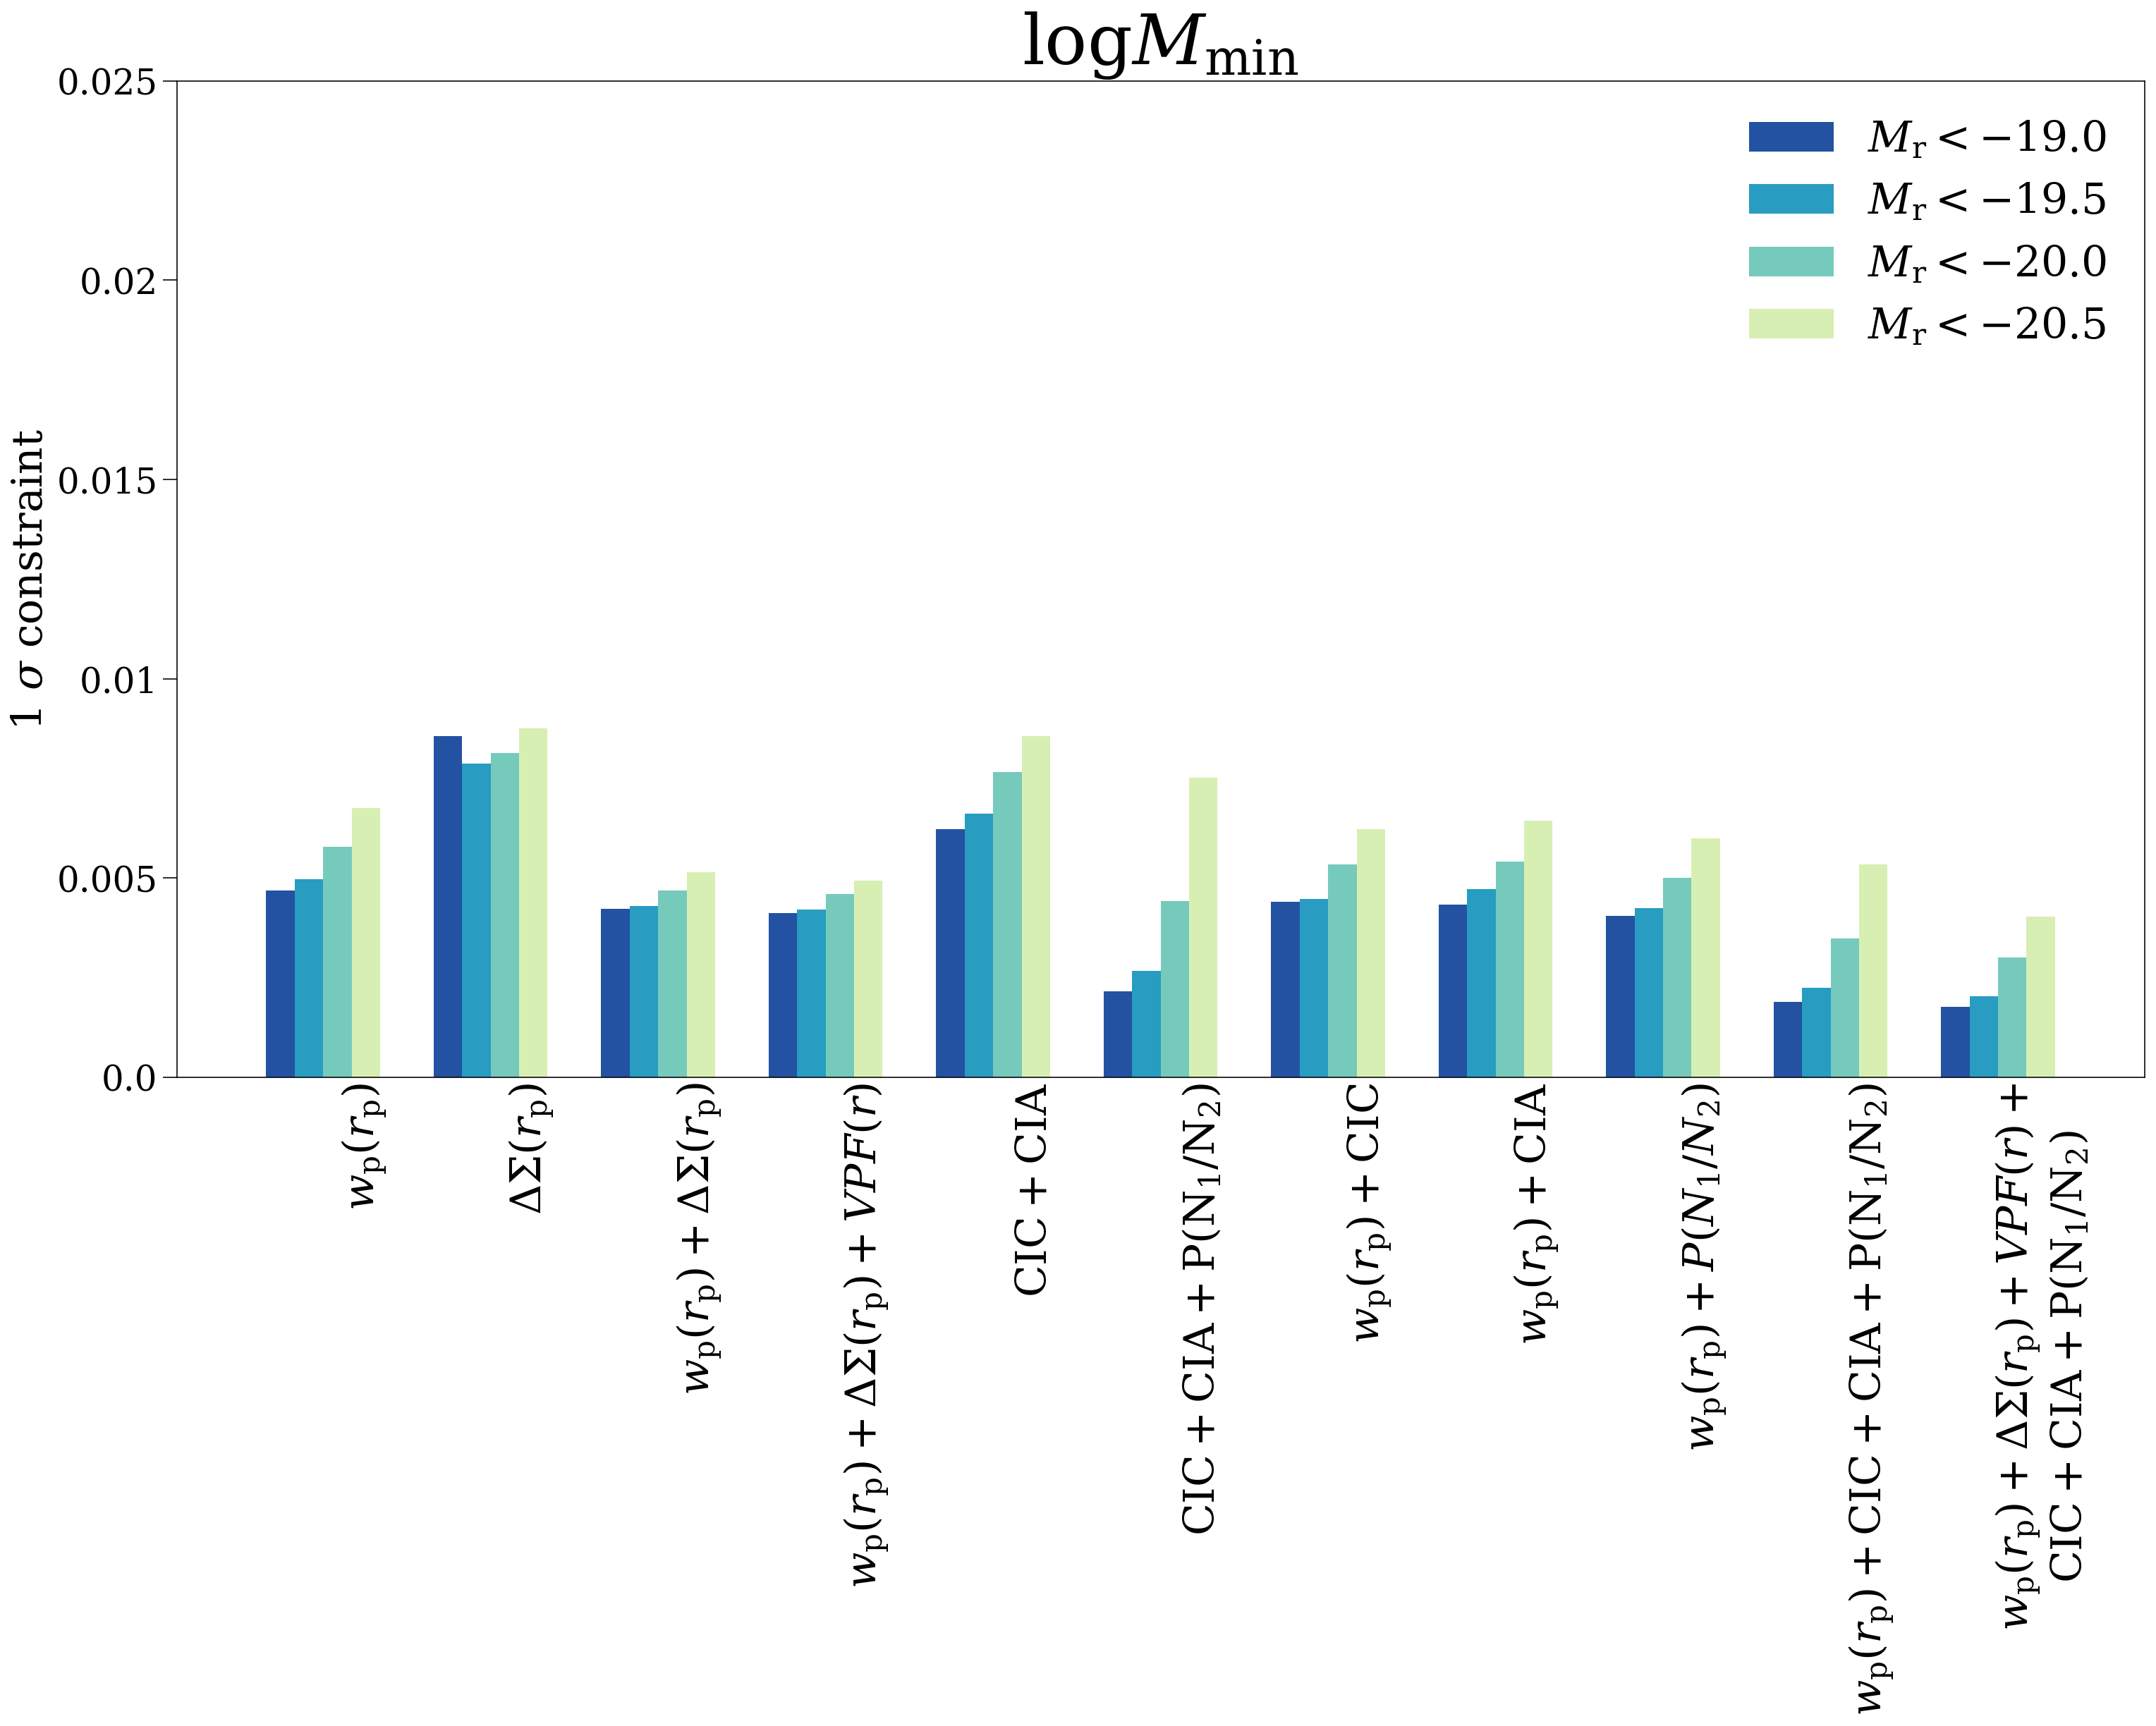

In [32]:
N = 11

ind = np.arange(N)  # the x locations for the groups
width = 0.17       # the width of the bars

fig, ax = plt.subplots(figsize=(25,13))
rects1 = ax.bar(ind, sigmalist_u_19p0[combidx,3], width, color=cm.YlGnBu(200))
rects2 = ax.bar(ind+width, sigmalist_u_19p5[combidx,3], width, color=cm.YlGnBu(150))
rects3 = ax.bar(ind+width*2, sigmalist_u_20p0[combidx,3], width, color=cm.YlGnBu(100))
rects4 = ax.bar(ind+width*3, sigmalist_u_20p5[combidx,3], width, color=cm.YlGnBu(50))

# add some text for labels, title and axes ticks
ax.set_ylabel(r'$1\ \sigma\ \rm{constraint}$',fontsize=30)
ax.set_title(param_list[3],fontsize=50)
ax.set_xticks(np.arange(N)+0.5)
ax.set_xticklabels(comblist,rotation=90,fontsize=30)
ax.set_yticklabels([0.000,0.005,0.010,0.015,0.020,0.025],fontsize=25)
ax.tick_params(axis='x',length=0)
ax.tick_params(axis='y',length=10)


ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),\
          (r'$M_{\rm{r}}<-19.0$',r'$M_{\rm{r}}<-19.5$',r'$M_{\rm{r}}<-20.0$',r'$M_{\rm{r}}<-20.5$'),frameon=False,fontsize=30)

ax.set_ylim(0,0.025)

plt.show()

In [25]:
def plot_ellipse(x_cen, y_cen, half_x, half_y, cclockwise_angle_x, ax, fill=0, label=None, color='b', linestyle='-', npoints=200): 
    #rotation angle in rad
    t = np.linspace(0, 2*np.pi, npoints)
    Ell = np.array([half_x*np.cos(t) , half_y*np.sin(t)])
    R_rot = np.array([[np.cos(cclockwise_angle_x) , -np.sin(cclockwise_angle_x)],\
                      [np.sin(cclockwise_angle_x) , np.cos(cclockwise_angle_x)]])  #2-D rotation matrix
    Ell_rot = np.dot(R_rot,Ell)
    if fill:
        line1, = ax.fill(x_cen+Ell_rot[0] , y_cen+Ell_rot[1], linestyle=linestyle, color=color, label=label)
        line2, = ax.plot(x_cen+Ell_rot[0] , y_cen+Ell_rot[1], linestyle=linestyle, color='k',lw=0.5)
        return line1,line2
    else:
        line, = ax.plot(x_cen+Ell_rot[0] , y_cen+Ell_rot[1], linestyle=linestyle, color=color,lw=2,label=label)
        return line

def ellipse_from_cov(mean, cov, ax, fill=0, label=None, color='b', linestyle='-',npoints=200):
    x_cen = mean[0]
    y_cen = mean[1]
    if cov[1][0]==0:
        if np.abs(cov[0][1])>1e-5:
            raise ValueError('covariance matrix must be symmetric')
    elif cov[0][1]/cov[1][0]<1.-1e-5 or cov[0][1]/cov[1][0]>1.+1e-5:
        raise ValueError('covariance matrix must be symmetric')
    sxsx = cov[0][0]
    sysy = cov[1][1]
    sxy = cov[0][1]
    half_x = np.sqrt((sxsx+sysy)/2.+np.sqrt(((sxsx-sysy)**2)/4.+sxy*sxy))
    half_y = np.sqrt((sxsx+sysy)/2.-np.sqrt(((sxsx-sysy)**2)/4.+sxy*sxy))
    if sxsx==sysy:
        cclockwise_angle_x = 0.5*np.arctan(np.inf)
    else:
        cclockwise_angle_x = 0.5*np.arctan(2.*sxy/(sxsx-sysy))
    if sxsx<sysy:
        cclockwise_angle_x += np.pi/2.
    return plot_ellipse(x_cen,y_cen,half_x,half_y,cclockwise_angle_x,ax,fill=fill,label=label,\
                        color=color,linestyle=linestyle,npoints=npoints)

def cov_ij(cov, i, j):
    covij = np.array(((cov[i,i],cov[i,j]),(cov[j,i],cov[j,j])))
    return covij

p19p0 = np.array((1.04029, 12.80315, 0.51193, 11.64354, 0.5, 0.))
p19p5 = np.array((1.11553, 13.06008, 0.44578, 11.75068, 0.5, 0.))
p20p0 = np.array((1.14385, 13.28584, 0.34846, 11.97186, 0.5, 0.))
p20p5 = np.array((1.19652, 13.59169, 0.18536, 12.25470, 0.5, 0.))

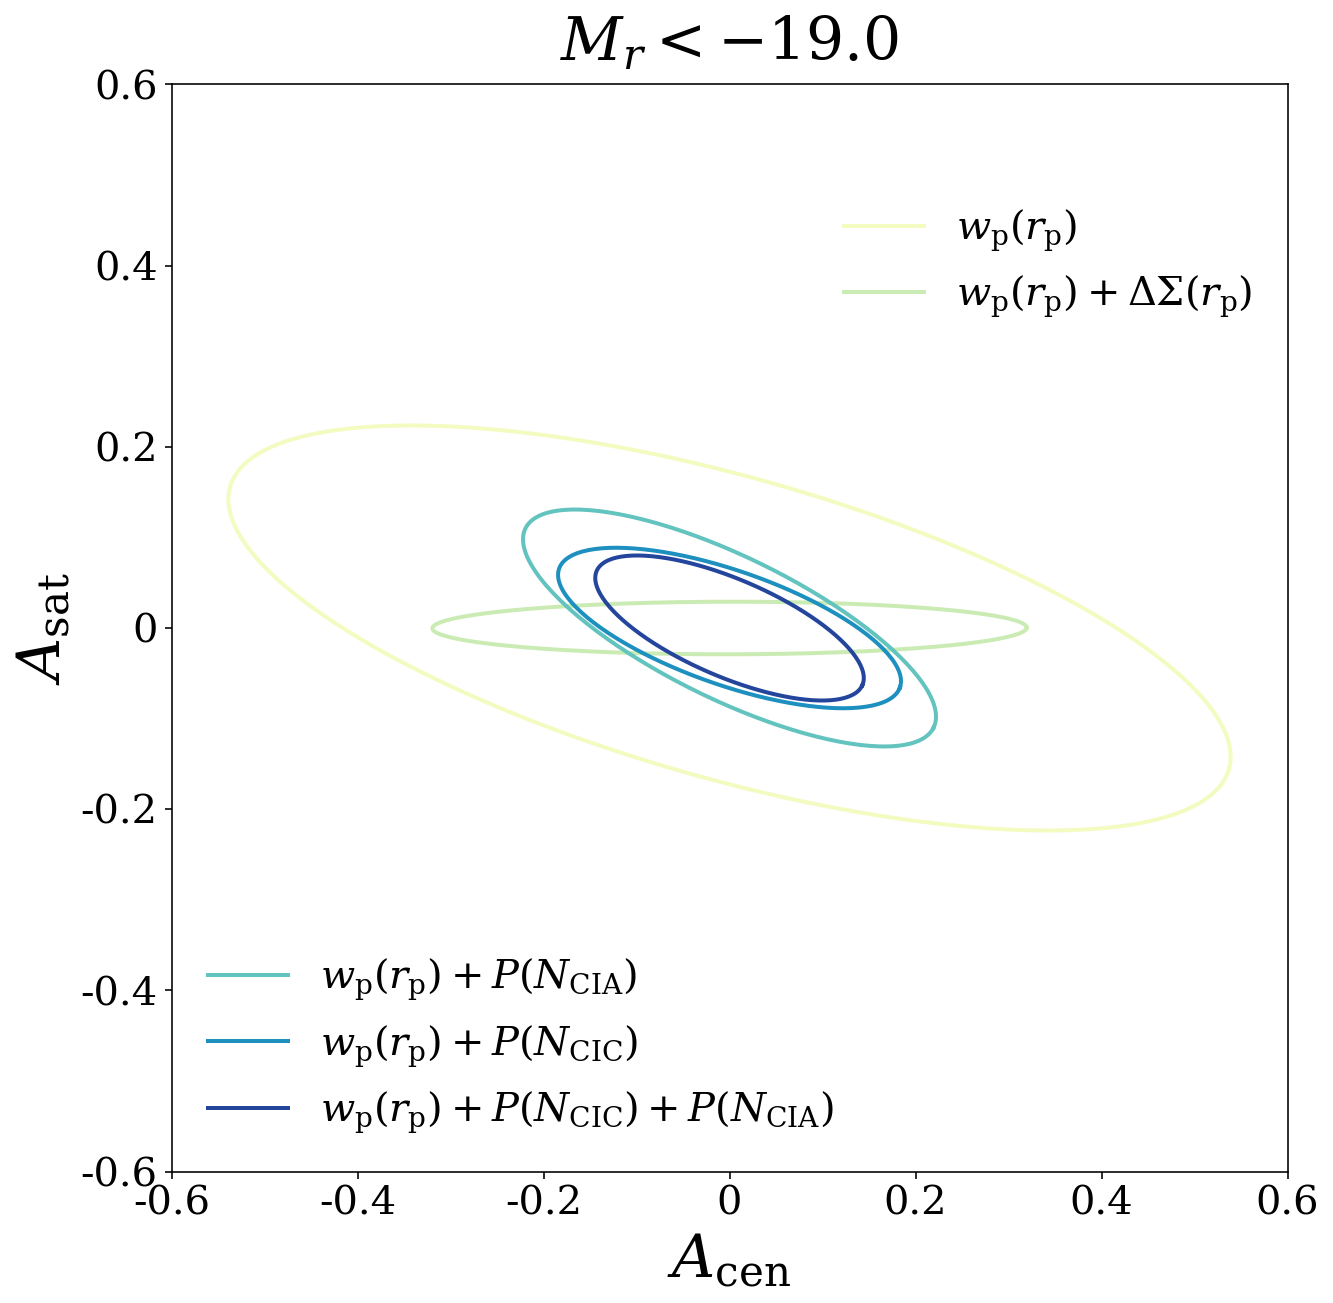

In [35]:
mean_aa = np.zeros(2)
cov_w_19p0 = np.linalg.inv(fisher_tm_19p0['w'])[4:,4:]
cov_wd_19p0 = np.linalg.inv(fisher_tm_19p0['wd'])[4:,4:]
cov_wc_19p0 = np.linalg.inv(fisher_tm_19p0['wc'])[4:,4:]
cov_wa_19p0 = np.linalg.inv(fisher_tm_19p0['wa'])[4:,4:]
cov_wca_19p0 = np.linalg.inv(fisher_tm_19p0['wca'])[4:,4:]

fig,ax = plt.subplots(figsize=(10,10))
label_list = [r'$w_\mathrm{p}(r_\mathrm{p})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+\Delta\Sigma(r_\mathrm{p})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{CIC}})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{CIA}})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{CIC}})+P(N_{\rm{CIA}})$']
e1 = ellipse_from_cov(mean_aa, cov_w_19p0, ax, label=label_list[0], color=cm.YlGnBu(20))
e2 = ellipse_from_cov(mean_aa, cov_wd_19p0, ax, label=label_list[1], color=cm.YlGnBu(60))
e3 = ellipse_from_cov(mean_aa, cov_wa_19p0, ax, label=label_list[3], color=cm.YlGnBu(110))
e4 = ellipse_from_cov(mean_aa, cov_wc_19p0, ax, label=label_list[2], color=cm.YlGnBu(160))
e5 = ellipse_from_cov(mean_aa, cov_wca_19p0, ax, label=label_list[4], color=cm.YlGnBu(210))

l1 = plt.legend([e1,e2], [label_list[0],label_list[1]], bbox_to_anchor=[0.57,0.75], fontsize=20, frameon=False)
ax.legend([e3,e4,e5], [label_list[3],label_list[2],label_list[4]], loc=3, fontsize=20, frameon=False) # this removes l1 from the axes.
plt.gca().add_artist(l1)
ax.set_xlabel(param_list[4],fontsize=30)
ax.set_ylabel(param_list[5],fontsize=30)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(-0.6,0.6)
ax.set_xticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6],fontsize=20)
ax.set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6],fontsize=20)
ax.set_title(r'$M_r<-19.0$',fontsize=30)

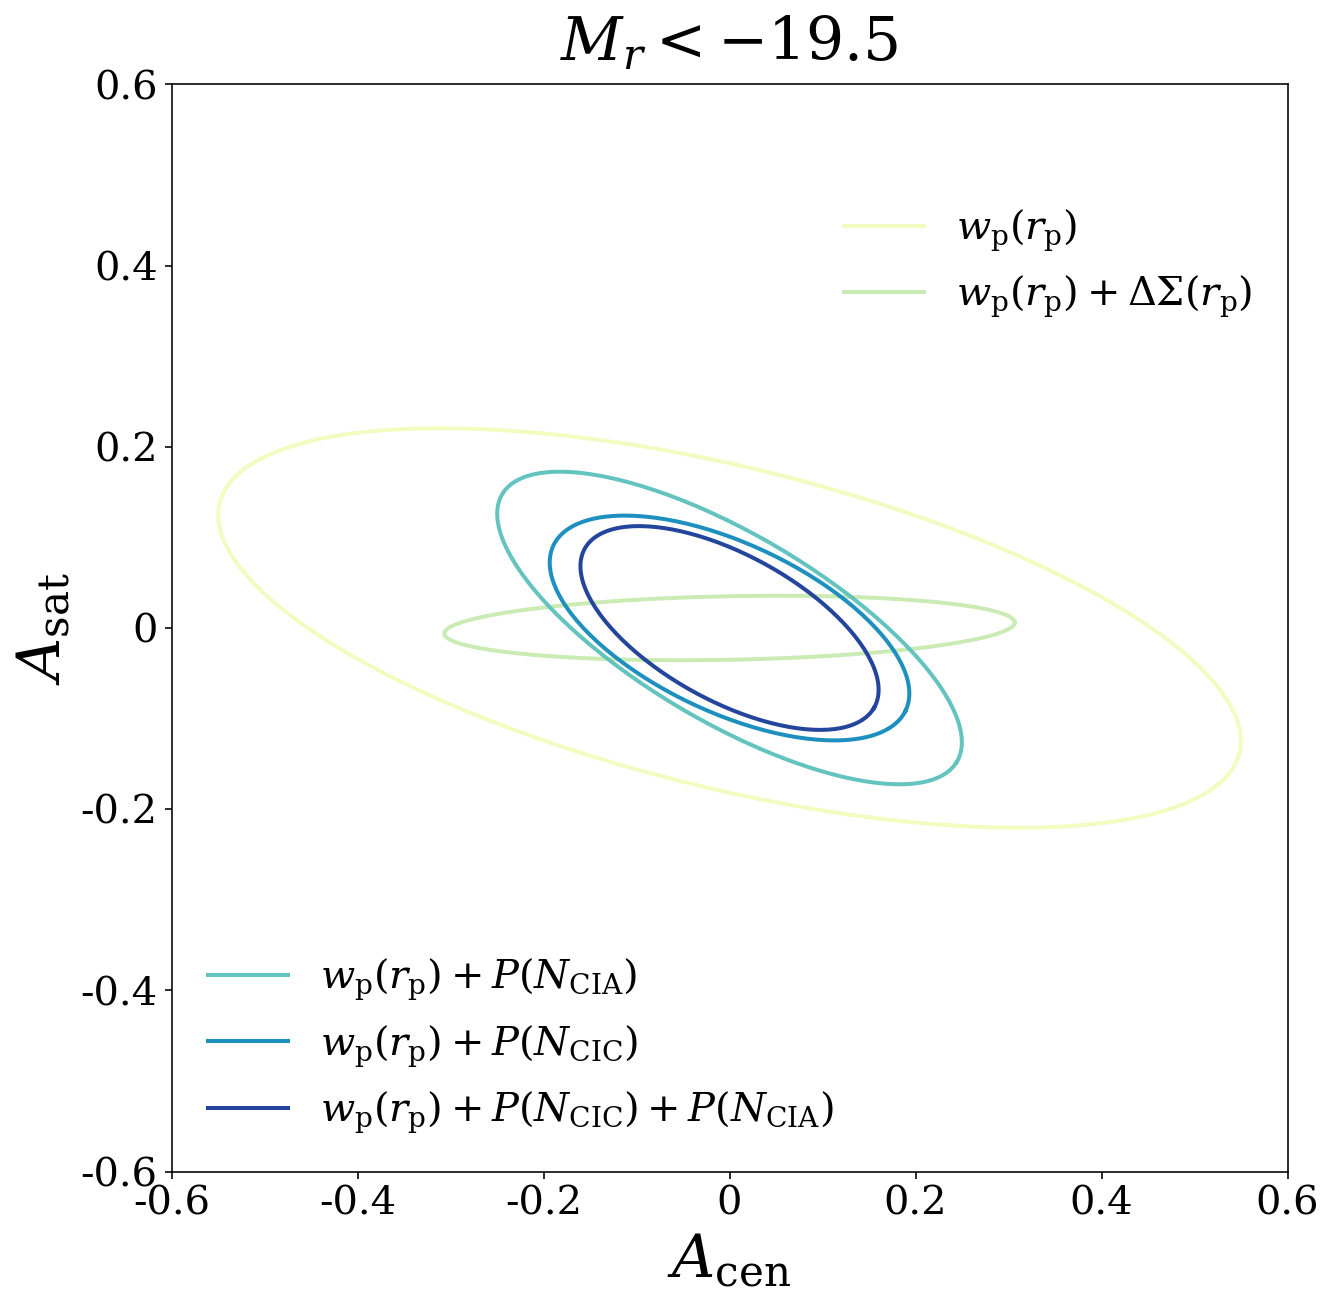

In [36]:
mean_aa = np.zeros(2)
cov_w_19p5 = np.linalg.inv(fisher_tm_19p5['w'])[4:,4:]
cov_wd_19p5 = np.linalg.inv(fisher_tm_19p5['wd'])[4:,4:]
cov_wc_19p5 = np.linalg.inv(fisher_tm_19p5['wc'])[4:,4:]
cov_wa_19p5 = np.linalg.inv(fisher_tm_19p5['wa'])[4:,4:]
cov_wca_19p5 = np.linalg.inv(fisher_tm_19p5['wca'])[4:,4:]

fig,ax = plt.subplots(figsize=(10,10))
label_list = [r'$w_\mathrm{p}(r_\mathrm{p})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+\Delta\Sigma(r_\mathrm{p})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{CIC}})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{CIA}})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{CIC}})+P(N_{\rm{CIA}})$']
e1 = ellipse_from_cov(mean_aa, cov_w_19p5, ax, label=label_list[0], color=cm.YlGnBu(20))
e2 = ellipse_from_cov(mean_aa, cov_wd_19p5, ax, label=label_list[1], color=cm.YlGnBu(60))
e3 = ellipse_from_cov(mean_aa, cov_wa_19p5, ax, label=label_list[3], color=cm.YlGnBu(110))
e4 = ellipse_from_cov(mean_aa, cov_wc_19p5, ax, label=label_list[2], color=cm.YlGnBu(160))
e5 = ellipse_from_cov(mean_aa, cov_wca_19p5, ax, label=label_list[4], color=cm.YlGnBu(210))

l1 = plt.legend([e1,e2], [label_list[0],label_list[1]], bbox_to_anchor=[0.57,0.75], fontsize=20, frameon=False)
ax.legend([e3,e4,e5], [label_list[3],label_list[2],label_list[4]], loc=3, fontsize=20, frameon=False) # this removes l1 from the axes.
plt.gca().add_artist(l1)
ax.set_xlabel(param_list[4],fontsize=30)
ax.set_ylabel(param_list[5],fontsize=30)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(-0.6,0.6)
ax.set_xticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6],fontsize=20)
ax.set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6],fontsize=20)
ax.set_title(r'$M_r<-19.5$',fontsize=30)

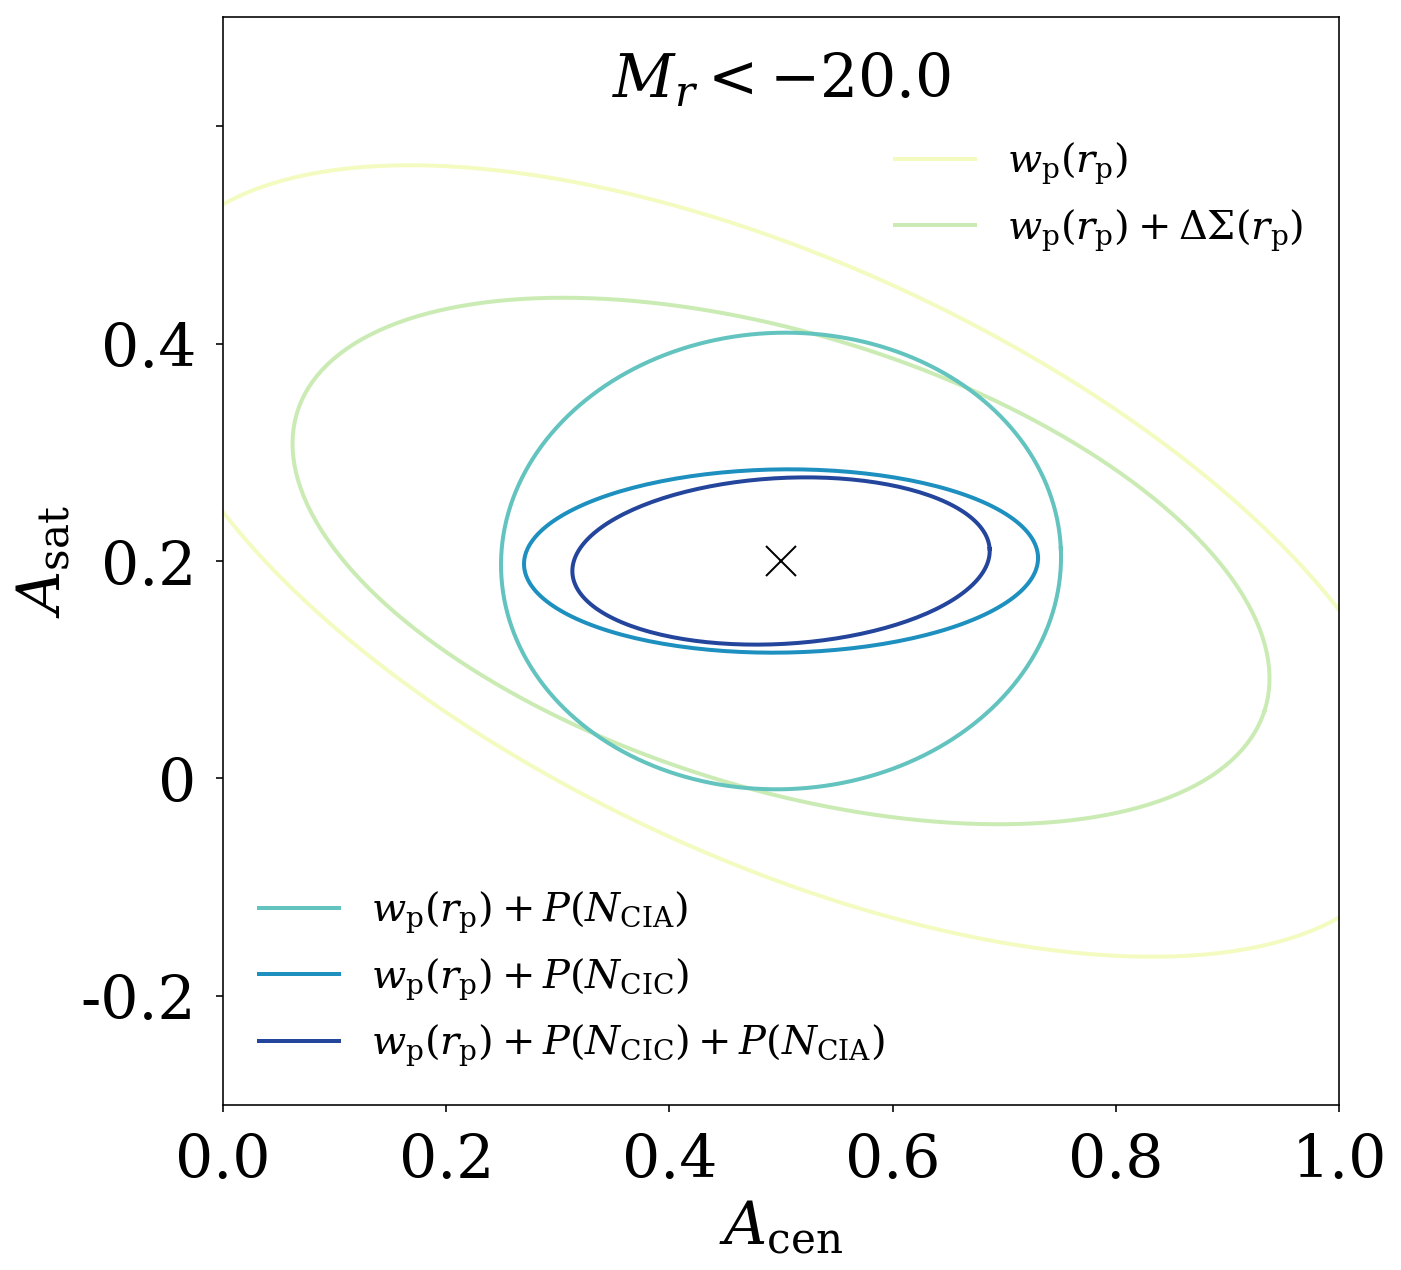

In [34]:
rcParams['axes.titlepad'] = -40
mean_aa = np.array((0.5,0))
cov_w_20p0 = np.linalg.inv(fisher_tm_20p0['w'])[4:,4:]
cov_wd_20p0 = np.linalg.inv(fisher_tm_20p0['wd'])[4:,4:]
cov_wc_20p0 = np.linalg.inv(fisher_tm_20p0['wc'])[4:,4:]
cov_wa_20p0 = np.linalg.inv(fisher_tm_20p0['wa'])[4:,4:]
cov_wca_20p0 = np.linalg.inv(fisher_tm_20p0['wca'])[4:,4:]

fig,ax = plt.subplots(figsize=(10,10))
label_list = [r'$w_\mathrm{p}(r_\mathrm{p})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+\Delta\Sigma(r_\mathrm{p})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{CIC}})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{CIA}})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{CIC}})+P(N_{\rm{CIA}})$']
e1 = ellipse_from_cov(mean_aa, cov_w_20p0, ax, label=label_list[0], color=cm.YlGnBu(20))
e2 = ellipse_from_cov(mean_aa, cov_wd_20p0, ax, label=label_list[1], color=cm.YlGnBu(60))
e3 = ellipse_from_cov(mean_aa, cov_wa_20p0, ax, label=label_list[3], color=cm.YlGnBu(110))
e4 = ellipse_from_cov(mean_aa, cov_wc_20p0, ax, label=label_list[2], color=cm.YlGnBu(160))
e5 = ellipse_from_cov(mean_aa, cov_wca_20p0, ax, label=label_list[4], color=cm.YlGnBu(210))
ax.plot(0.5,0,'x',color='k',markersize=15)

l1 = plt.legend([e1,e2], [label_list[0],label_list[1]], bbox_to_anchor=[0.57,0.75], fontsize=20, frameon=False)
ax.legend([e3,e4,e5], [label_list[3],label_list[2],label_list[4]], loc=3, fontsize=20, frameon=False) # this removes l1 from the axes.
plt.gca().add_artist(l1)
ax.set_xlabel(param_list[4],fontsize=30)
ax.set_ylabel(param_list[5],fontsize=30)
ax.set_xlim(0.0,1.0)
ax.set_ylim(-0.5,0.5)
ax.tick_params(pad=10)
ax.set_xticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=30)
ax.set_yticklabels([-0.4,-0.2,0,0.2,0.4],fontsize=30)
ax.set_title(r'$M_r<-20.0$',fontsize=30,)

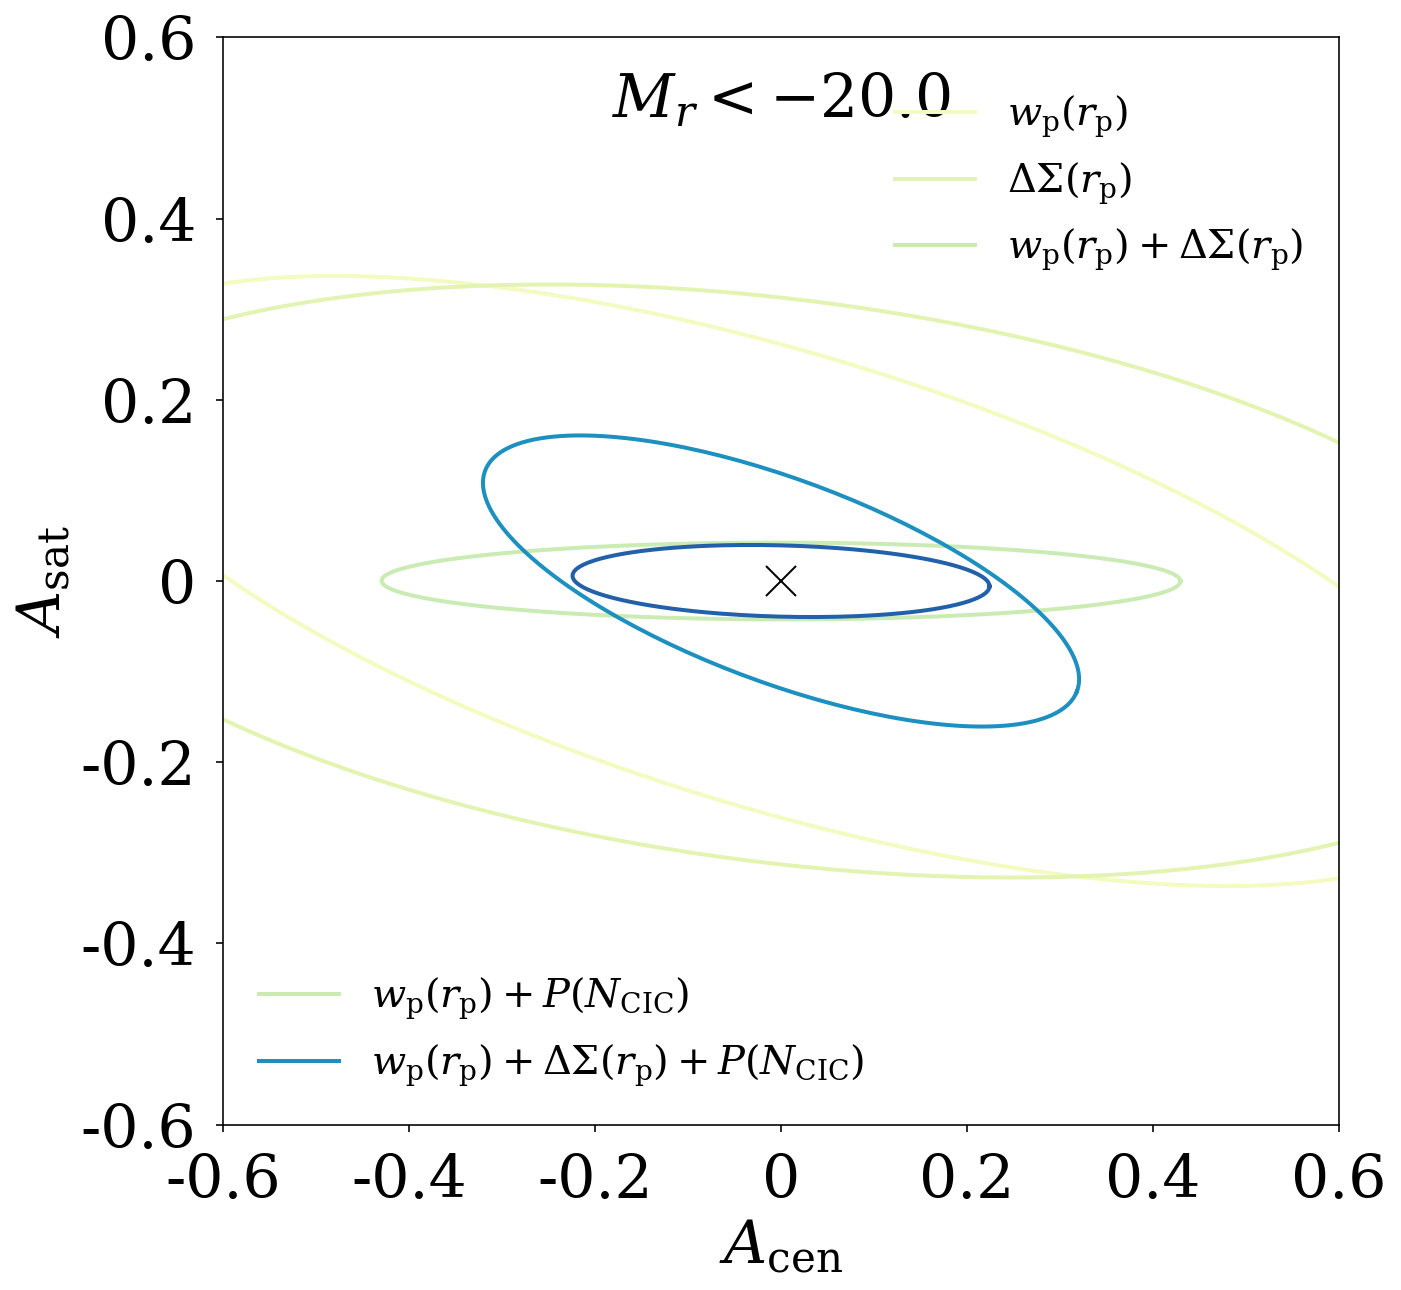

In [42]:
cov_wdc_20p0 = np.linalg.inv(fisher_tm_20p0['wdc'])[4:,4:]
cov_d_20p0 = np.linalg.inv(fisher_tm_20p0['d'])[4:,4:]

fig,ax = plt.subplots(figsize=(10,10))
label_list = [r'$w_\mathrm{p}(r_\mathrm{p})$',\
              r'$\Delta\Sigma(r_\mathrm{p})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+\Delta\Sigma(r_\mathrm{p})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{CIC}})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+\Delta\Sigma(r_\mathrm{p})+P(N_{\rm{CIC}})$']
e1 = ellipse_from_cov(mean_aa, cov_w_20p0, ax, label=label_list[0], color=cm.YlGnBu(20))
e2 = ellipse_from_cov(mean_aa, cov_d_20p0, ax, label=label_list[1], color=cm.YlGnBu(40))
e3 = ellipse_from_cov(mean_aa, cov_wd_20p0, ax, label=label_list[2], color=cm.YlGnBu(60))
e4 = ellipse_from_cov(mean_aa, cov_wc_20p0, ax, label=label_list[4], color=cm.YlGnBu(160))
e5 = ellipse_from_cov(mean_aa, cov_wdc_20p0, ax, label=label_list[3], color=cm.YlGnBu(190))
ax.plot(0,0,'x',color='k',markersize=15)

l1 = plt.legend([e1,e2,e3], [label_list[0],label_list[1],label_list[2]], bbox_to_anchor=[0.57,0.75], fontsize=20, frameon=False)
ax.legend([e3,e4], [label_list[3],label_list[4]], loc=3, fontsize=20, frameon=False) # this removes l1 from the axes.
plt.gca().add_artist(l1)
ax.set_xlabel(param_list[4],fontsize=30)
ax.set_ylabel(param_list[5],fontsize=30)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(-0.6,0.6)
ax.tick_params(pad=10)
ax.set_xticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6],fontsize=30)
ax.set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6],fontsize=30)
ax.set_title(r'$M_r<-20.0$',fontsize=30,)

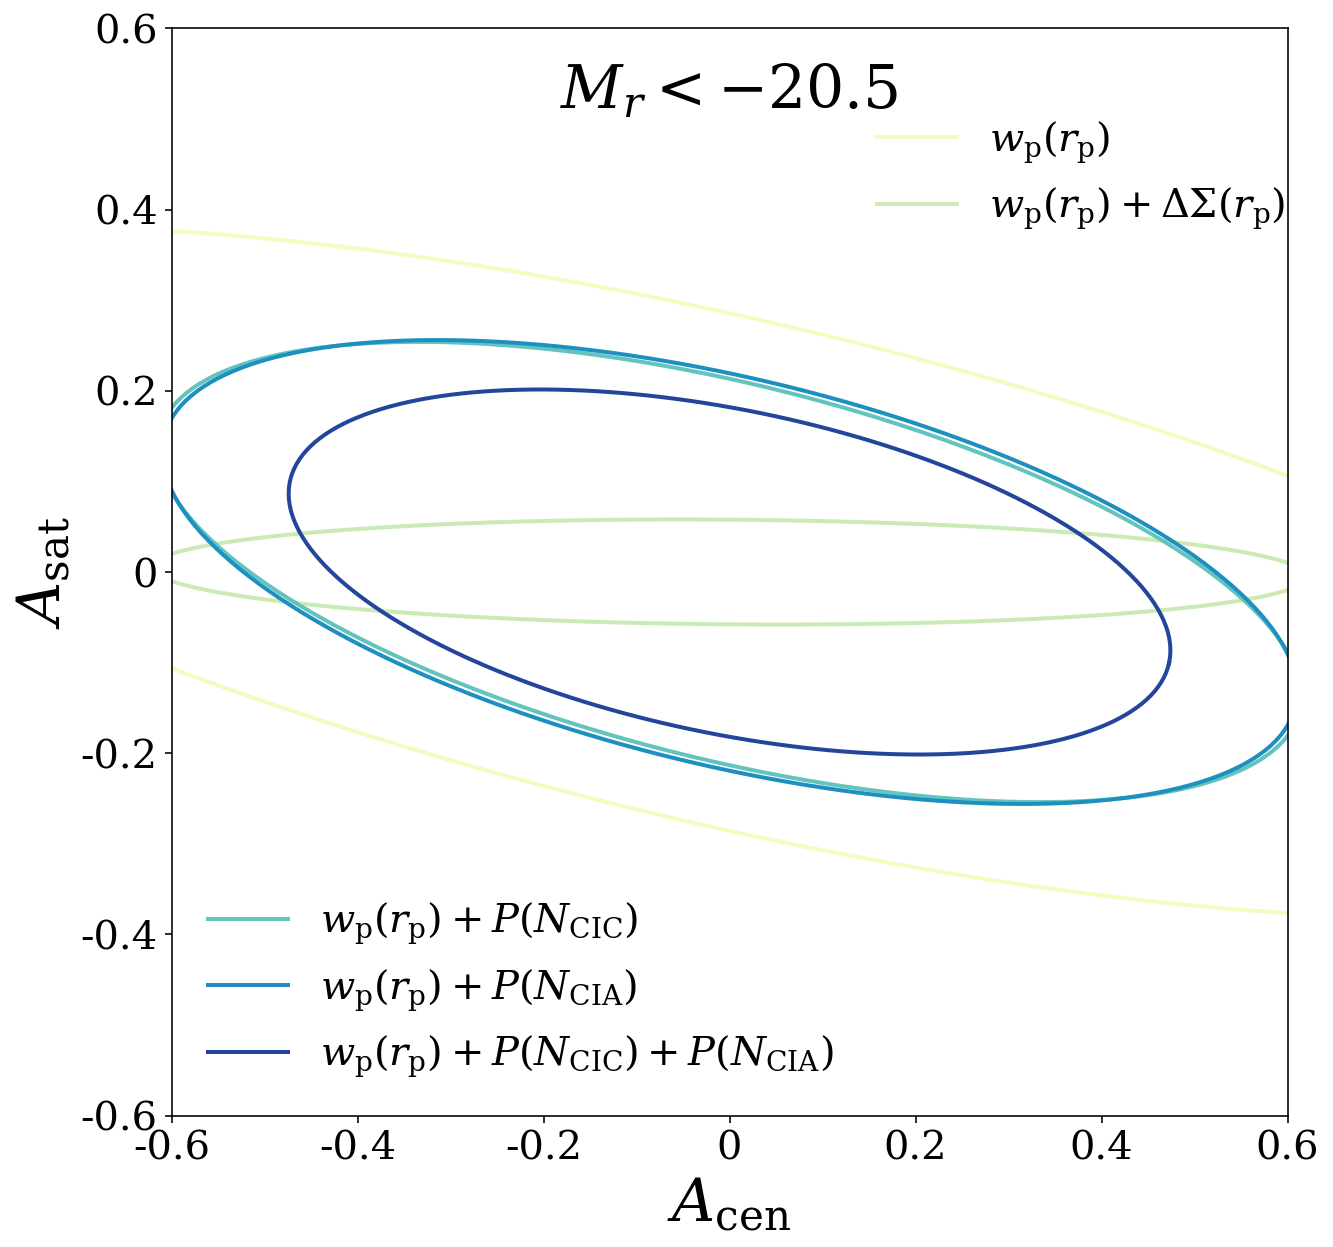

In [40]:
mean_aa = np.zeros(2)
cov_w_20p5 = np.linalg.inv(fisher_tm_20p5['w'])[4:,4:]
cov_wd_20p5 = np.linalg.inv(fisher_tm_20p5['wd'])[4:,4:]
cov_wc_20p5 = np.linalg.inv(fisher_tm_20p5['wc'])[4:,4:]
cov_wa_20p5 = np.linalg.inv(fisher_tm_20p5['wa'])[4:,4:]
cov_wca_20p5 = np.linalg.inv(fisher_tm_20p5['wca'])[4:,4:]

fig,ax = plt.subplots(figsize=(10,10))
label_list = [r'$w_\mathrm{p}(r_\mathrm{p})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+\Delta\Sigma(r_\mathrm{p})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{CIC}})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{CIA}})$',\
            r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{CIC}})+P(N_{\rm{CIA}})$']
e1 = ellipse_from_cov(mean_aa, cov_w_20p5, ax, label=label_list[0], color=cm.YlGnBu(20))
e2 = ellipse_from_cov(mean_aa, cov_wd_20p5, ax, label=label_list[1], color=cm.YlGnBu(60))
e3 = ellipse_from_cov(mean_aa, cov_wa_20p5, ax, label=label_list[3], color=cm.YlGnBu(110))
e4 = ellipse_from_cov(mean_aa, cov_wc_20p5, ax, label=label_list[2], color=cm.YlGnBu(160))
e5 = ellipse_from_cov(mean_aa, cov_wca_20p5, ax, label=label_list[4], color=cm.YlGnBu(210))

l1 = plt.legend([e1,e2], [label_list[0],label_list[1]], bbox_to_anchor=[0.6,0.78], fontsize=20, frameon=False)
ax.legend([e3,e4,e5], [label_list[2],label_list[3],label_list[4]], loc=3, fontsize=20, frameon=False) # this removes l1 from the axes.
plt.gca().add_artist(l1)
ax.set_xlabel(param_list[4],fontsize=30)
ax.set_ylabel(param_list[5],fontsize=30)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(-0.6,0.6)
ax.set_xticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6],fontsize=20)
ax.set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6],fontsize=20)
ax.set_title(r'$M_r<-20.5$',fontsize=30)

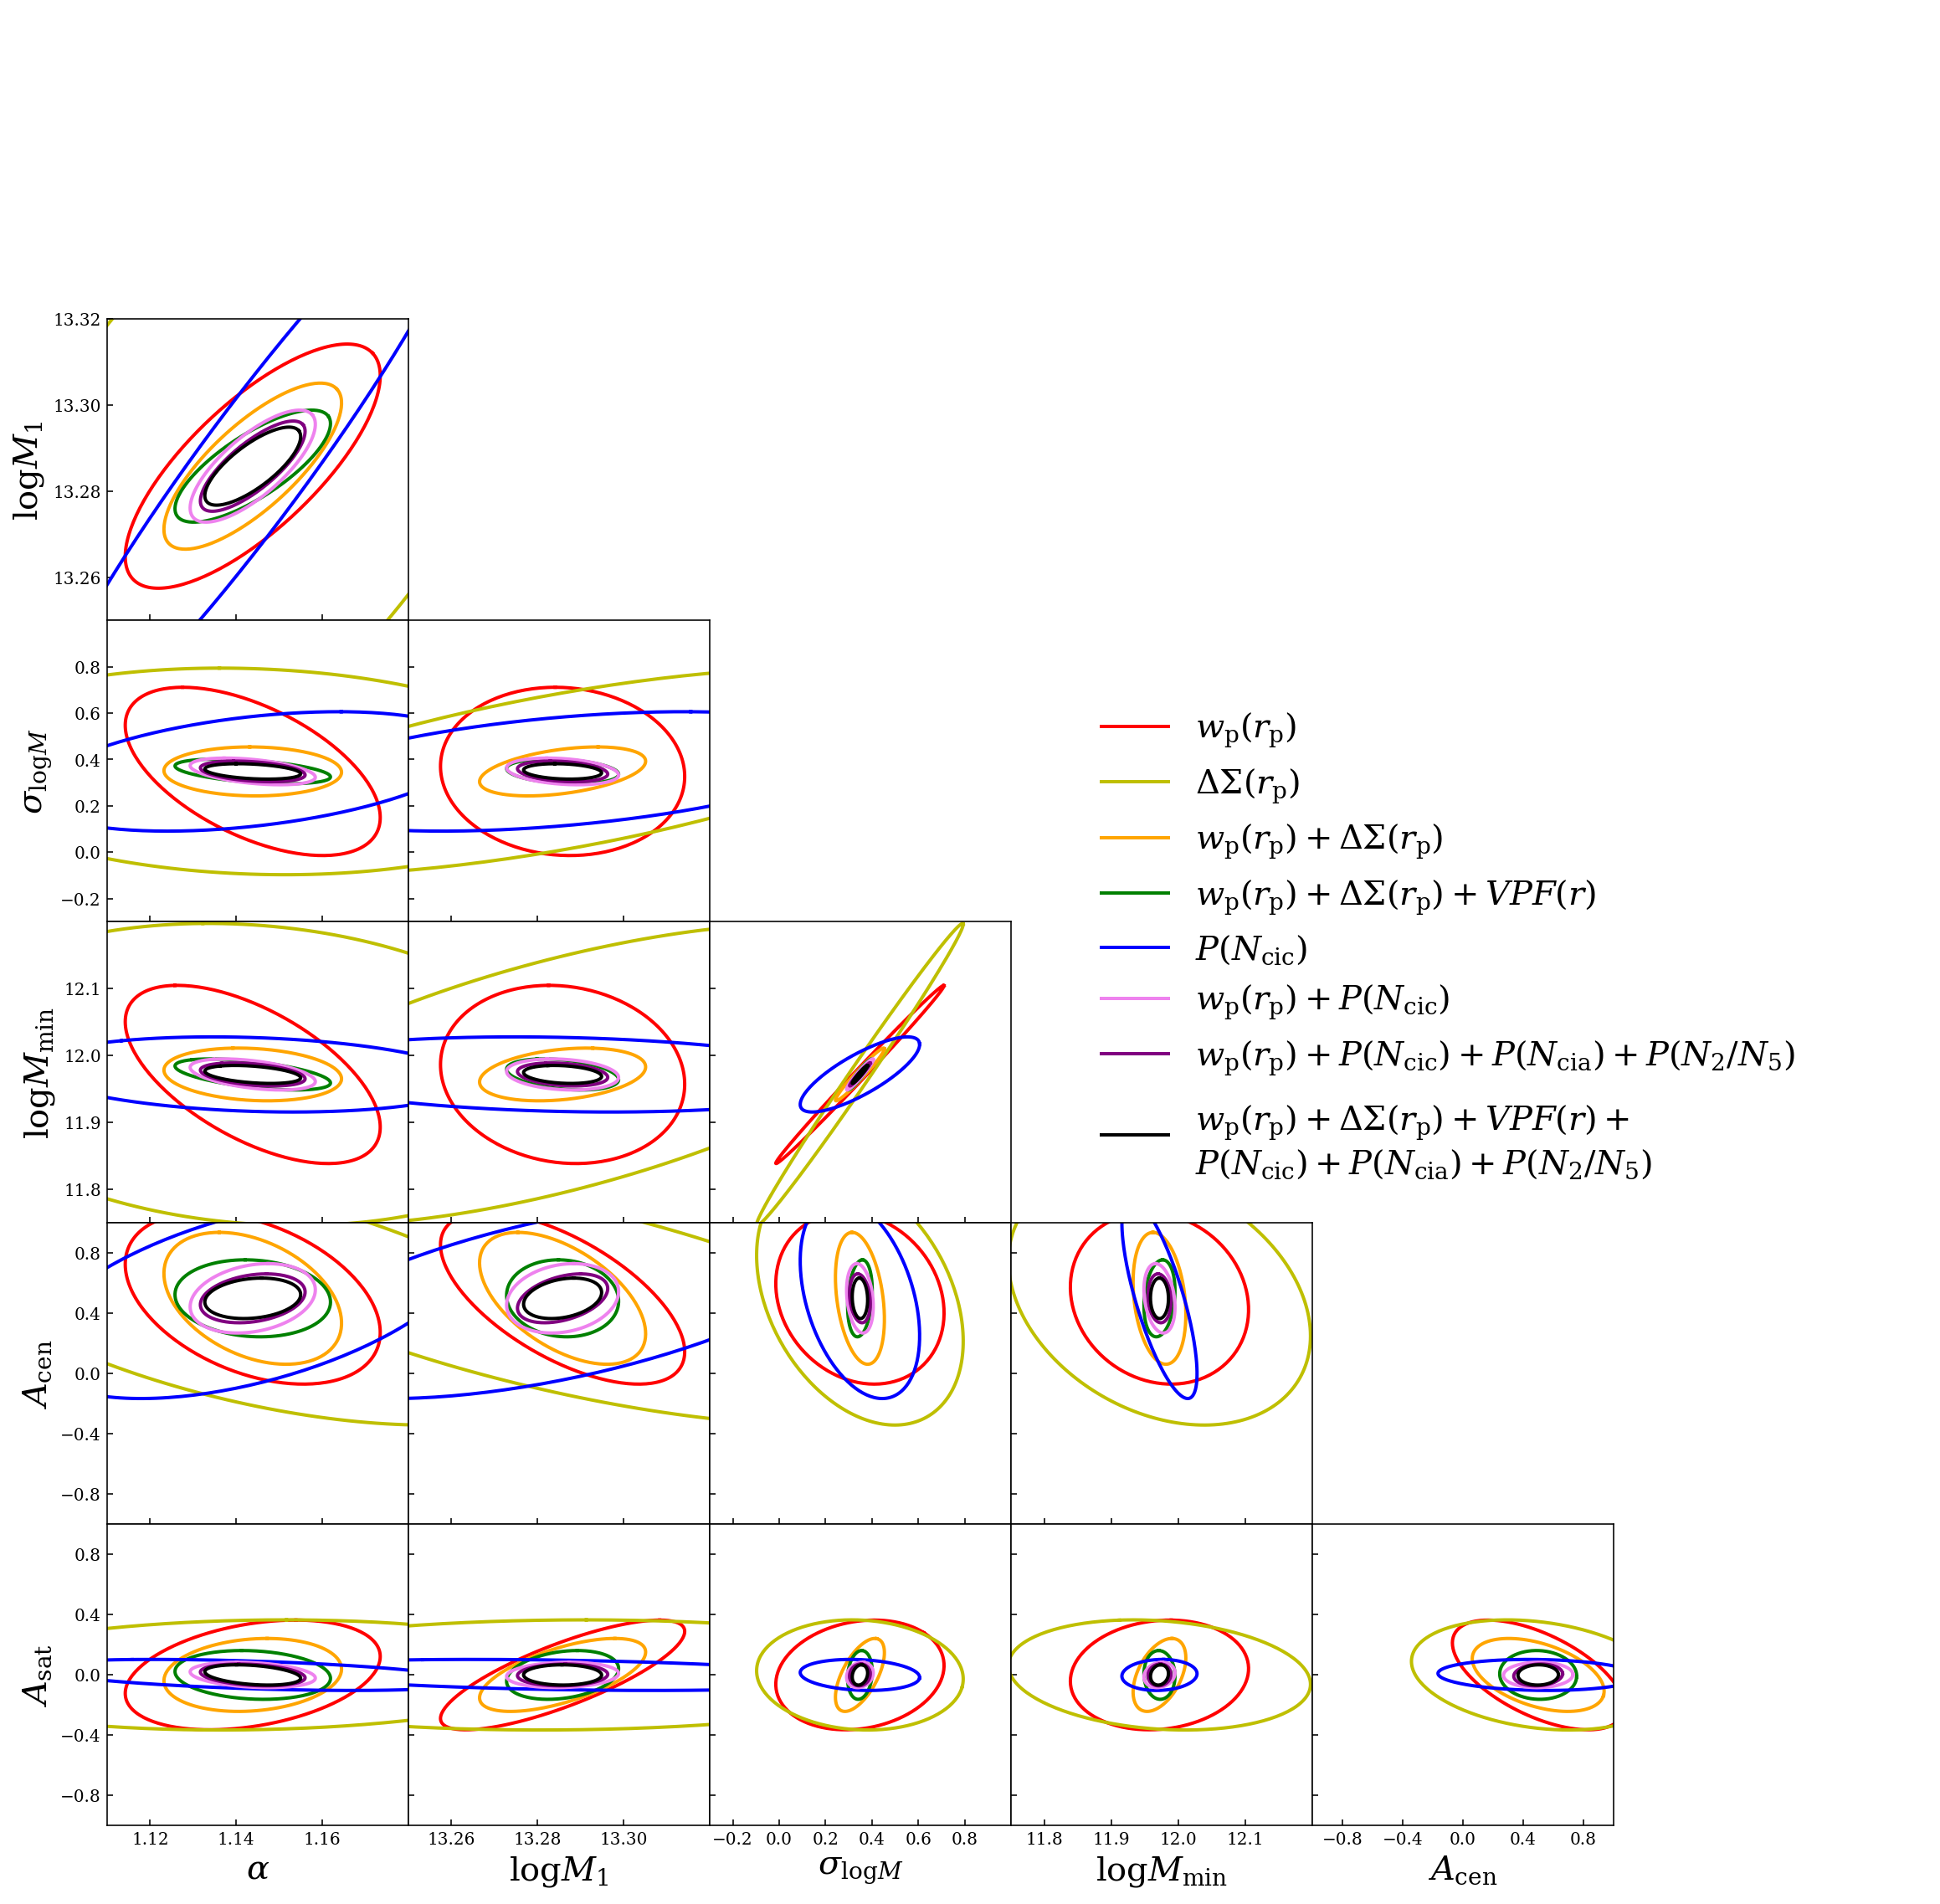

In [37]:
fidp = p20p0
postcov_mean = pf.apply_to_dict(np.linalg.inv,fisher_tm_20p0)

fig, axes = plt.subplots(6,6, figsize=(15, 15),sharex=u'col',sharey=u'row')
fig.subplots_adjust(left=1, bottom=1, right=2, top=2,
                      wspace=0., hspace=0.)

for i in range(6):
    #axes[i,0].set_ylim(fidp[i]-np.sqrt(cov_ij(postcov_mean['w'],0,i)[1,1])*1.5,\
    #                   fidp[i]+np.sqrt(cov_ij(postcov_mean['w'],0,i)[1,1])*1.5)
    axes[i,0].set_ylabel(param_list[i],fontsize=20)
    #axes[5,i].set_xlim(fidp[i]-np.sqrt(cov_ij(postcov_mean['w'],0,i)[1,1])*1.5,\
    #                   fidp[i]+np.sqrt(cov_ij(postcov_mean['w'],0,i)[1,1])*1.5)
    axes[5,i].set_xlabel(param_list[i],fontsize=20)
    for j in range(6):
        if i<=j:
            axes[i,j].axis('off')
        else:
            axes[i,j].tick_params(direction='in')
            ellipse_from_cov(np.array((fidp[j],fidp[i])),cov_ij(postcov_mean['w'],j,i),axes[i,j],color='r',\
                             label=r'$w_\mathrm{p}(r_\mathrm{p})$',fill=0)
            ellipse_from_cov(np.array((fidp[j],fidp[i])),cov_ij(postcov_mean['d'],j,i),axes[i,j],color='y',\
                             label=r'$\Delta\Sigma(r_\mathrm{p})$',fill=0)
            ellipse_from_cov(np.array((fidp[j],fidp[i])),cov_ij(postcov_mean['wd'],j,i),axes[i,j],color='orange',\
                             label=r'$w_\mathrm{p}(r_\mathrm{p})+\Delta\Sigma(r_\mathrm{p})$',fill=0)
            ellipse_from_cov(np.array((fidp[j],fidp[i])),cov_ij(postcov_mean['wdv'],j,i),axes[i,j],color='green',\
                             label=r'$w_\mathrm{p}(r_\mathrm{p})+\Delta\Sigma(r_\mathrm{p})+VPF(r)$',fill=0)
            ellipse_from_cov(np.array((fidp[j],fidp[i])),cov_ij(postcov_mean['c'],j,i),axes[i,j],color='blue',\
                             label=r'$P(N_{\rm{cic}})$',fill=0)
            """
            ellipse_from_cov(np.array((fidp[j],fidp[i])),cov_ij(postcov_mean['a'],j,i),axes[i,j],color='orange',\
                             label=r'$P(N_{\rm{cia}})$',fill=0)
            ellipse_from_cov(np.array((fidp[j],fidp[i])),cov_ij(postcov_mean['r'],j,i),axes[i,j],color='pink',\
                             label=r'$P(N_{\mathrm{2}}/N_{\mathrm{5}})$',fill=0)
                             """
            ellipse_from_cov(np.array((fidp[j],fidp[i])),cov_ij(postcov_mean['wc'],j,i),axes[i,j],color='violet',\
                             label=r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{cic}})$',fill=0)
            ellipse_from_cov(np.array((fidp[j],fidp[i])),cov_ij(postcov_mean['wcar'],j,i),axes[i,j],color='purple',\
                             label=r'$w_\mathrm{p}(r_\mathrm{p})+P(N_{\rm{cic}})+P(N_{\rm{cia}})+P(N_{\mathrm{2}}/N_{\mathrm{5}})$',fill=0)
            ellipse_from_cov(np.array((fidp[j],fidp[i])),cov_ij(postcov_mean['wdvcar'],j,i),axes[i,j],color='k',\
                             label=r'$w_\mathrm{p}(r_\mathrm{p})+\Delta\Sigma(r_\mathrm{p})+VPF(r)+$'+'\n'\
                             +r'$P(N_{\rm{cic}})+P(N_{\rm{cia}})+P(N_{\mathrm{2}}/N_{\mathrm{5}})$',fill=0)

axes[1,0].set_ylim(13.25,13.32)
axes[1,0].set_yticks([13.26,13.28,13.30,13.32])
axes[2,0].set_ylim(-0.3,1.0)
axes[2,0].set_yticks([-0.2,0,0.2,0.4,0.6,0.8])
axes[3,0].set_ylim(11.75,12.2)
axes[3,0].set_yticks([11.8,11.9,12.0,12.1])
axes[4,0].set_ylim(-1,1)
axes[4,0].set_yticks([-0.8,-0.4,0,0.4,0.8])
axes[5,0].set_ylim(-1,1)
axes[5,0].set_yticks([-0.8,-0.4,0,0.4,0.8])
axes[5,0].set_xlim(1.11,1.18)
axes[5,0].set_xticks([1.12,1.14,1.16])
axes[5,1].set_xlim(13.25,13.32)
axes[5,1].set_xticks([13.26,13.28,13.30])
axes[5,2].set_xlim(-0.3,1.0)
axes[5,2].set_xticks([-0.2,0,0.2,0.4,0.6,0.8])
axes[5,3].set_xlim(11.75,12.2)
axes[5,3].set_xticks([11.8,11.9,12.0,12.1])
axes[5,4].set_xlim(-1,1)
axes[5,4].set_xticks([-0.8,-0.4,0,0.4,0.8])


axes[2,1].legend(frameon=False,fontsize=20,bbox_to_anchor=[2.2,0.8])